In [ ]:
!pip install transformers torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

torch.manual_seed(42)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512, dropout=0):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(torch.log(torch.tensor(10000.0)) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return self.encoding[:, :x.size(1)].detach()



class WhisperModel(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_encoder_layers, num_decoder_layers, max_seq_len, d_ff, dropout=0):
        super(WhisperModel, self).__init__()

        self.src_embedding = nn.Linear(80, d_model)  # Assuming 80 Mel-frequency cepstral coefficients (MFCCs)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_seq_len)

        self.positional_encoding = PositionalEncoding(d_model, dropout=0, max_len=max_seq_len)


        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout,
            dim_feedforward=d_ff,
        )

        self.fc = nn.Linear(d_model, tgt_vocab_size)

    def generate_mask(self, src, tgt):
        src_mask = None
        seq_length = tgt.size(1)
        nopeak_mask = (torch.triu(torch.ones(seq_length, seq_length), diagonal=1)).bool()
        return src_mask, nopeak_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)

       # self.logger.log("Tgt mask shape = " + str(tgt_mask.shape))
        print("src (before embedding)",src.shape)
        print("tgt (before embedding)",tgt.shape)

        src = self.src_embedding(src) + self.positional_encoding(src)
        #self.logger.log(f"src (after embedding and positional encoding): {src.shape}")
        print("src (after embedding and positional encoding)",src.shape)
        tgt = self.tgt_embedding(tgt) + self.positional_encoding(tgt)

        print("tgt (after embedding and positional encoding)",tgt.shape)
        #self.logger.log(f"tgt (after embedding and positional encoding): {tgt.shape}")

        output = self.transformer(src, tgt, src_mask=src_mask, tgt_mask=tgt_mask, tgt_is_causal=False)
        #self.logger.log(f"output (after transformer): {output.shape}")
        output = self.fc(output)
        #print(f"output: {output}")

        return output

# Example usage:
src_vocab_size = 100  # Placeholder
tgt_vocab_size = 100  # Placeholder
d_model = 512
num_heads = 4
num_encoder_layers = 1
num_decoder_layers = 1
max_seq_len = 32
d_ff = 2048

model = WhisperModel(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_encoder_layers, num_decoder_layers, max_seq_len, d_ff)

# Sample input tensors (batch_size, seq_len, feature_dim)
src = torch.randn(32, max_seq_len, 80)  # Example source sequence
tgt = torch.randint(0, tgt_vocab_size, (32, max_seq_len))  # Example target sequence

output = model(src, tgt)
print(output.shape)

src (before embedding) torch.Size([32, 32, 80])
tgt (before embedding) torch.Size([32, 32])
src (after embedding and positional encoding) torch.Size([32, 32, 512])
tgt (after embedding and positional encoding) torch.Size([32, 32, 512])
torch.Size([32, 32, 100])


In [ ]:
##audio to waveform
import torchaudio
import torch
import torchaudio.transforms as transforms

In [ ]:
audio_file_path = "/Q.wav"
waveform, sample_rate = torchaudio.load(audio_file_path)
print(waveform.shape)

torch.Size([1, 53064])


In [ ]:
print(waveform)
print(sample_rate)

tensor([[ 0.0000e+00, -3.0518e-05,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])
16000


In [ ]:

mel_spectrogram = transforms.MelSpectrogram(sample_rate)(waveform)
print(mel_spectrogram.shape)


torch.Size([1, 128, 266])


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


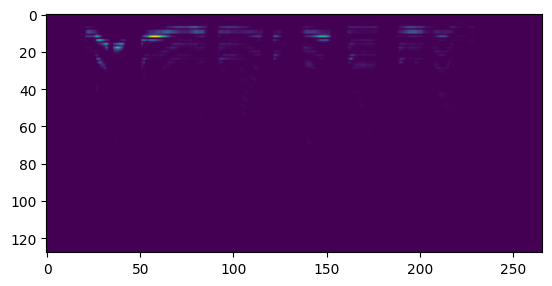

In [ ]:
from matplotlib import pyplot as plt
plt.imshow(mel_spectrogram.squeeze().numpy())
plt.show()

In [ ]:
num_frames = mel_spectrogram.shape[-1]
hop_length = 160
time_per_frame = hop_length / sample_rate
timestamps = [i * time_per_frame for i in range(num_frames)]

print(len(timestamps))

266


In [ ]:

expected_num_frames = math.ceil(waveform.shape[-1] / hop_length)
print(expected_num_frames)

332


In [ ]:
from transformers import WhisperForConditionalGeneration, WhisperProcessor
model_name = "openai/whisper-base"
model = WhisperForConditionalGeneration.from_pretrained(model_name)
processor = WhisperProcessor.from_pretrained(model_name)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
import torch
from transformers import pipeline

device = "cuda:0" if torch.cuda.is_available() else "cpu"
pipe = pipeline(
    "automatic-speech-recognition", model="openai/whisper-base", device=device
)
def transcribe(audio):

    #print(mel.shape)
    outputs = pipe(audio, max_new_tokens=256, generate_kwargs={"task": "transcribe"})
    return outputs["text"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.81k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

In [ ]:
text=transcribe("Q.wav")
print(text)

/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.


 What is the name of the largest rainforest in the world?


In [1]:
import torch
from transformers import pipeline

device = "cuda:0" if torch.cuda.is_available() else "cpu"
pipe = pipeline(
    "automatic-speech-recognition", model="openai/whisper-base", device=device
)
def transcribe(audio):

    #print(mel.shape)
    outputs = pipe(audio, max_new_tokens=256, generate_kwargs={"task": "transcribe"})
    return outputs["text"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modelling whisper
modeling_whisper.py
embed_dim 512
num_mel_bins 80
embed_dim 512
embed_dim 512
embed_dim 512
embed_dim 512
embed_dim 512
embed_dim 512


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:

embed_dim=512


In [2]:
text=transcribe("/Q.wav")
print(text)

/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.


expected_seq_length 3000
input_features: Float values of mel features extracted from the raw speech waveform. Raw speech waveform can be obtained by loading a `.flac` or `.wav` audio file into an array of type
input_features shape torch.Size([1, 80, 3000])
input_embeds torch.Size([1, 512, 3000])
input_embeds torch.Size([1, 512, 1500])
input_embeds after conv tensor([[[-0.1324, -0.1678, -0.1598,  ...,  0.0157,  0.7933,  0.1472],
         [-0.1080, -0.1688, -0.1192,  ...,  0.0541,  0.4403,  0.0848],
         [-0.1080, -0.1688, -0.1192,  ...,  0.0541,  0.4403,  0.0848],
         ...,
         [-0.1080, -0.1688, -0.1192,  ...,  0.0541,  0.4403,  0.0848],
         [-0.1080, -0.1688, -0.1192,  ...,  0.0541,  0.4403,  0.0848],
         [-0.0798, -0.1643, -0.1423,  ..., -0.0093,  0.2676,  0.0880]]])
input_embeds shape torch.Size([1, 1500, 512])
hidden states torch.Size([1, 1500, 512])
residual  torch.Size([1, 1500, 512])
hidden_states of sdpa attn  torch.Size([1, 1500, 512])
sdpa atnn after pr

The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


expected_seq_length 3000
input_features: Float values of mel features extracted from the raw speech waveform. Raw speech waveform can be obtained by loading a `.flac` or `.wav` audio file into an array of type
input_features shape torch.Size([1, 80, 3000])
input_embeds torch.Size([1, 512, 3000])
input_embeds torch.Size([1, 512, 1500])
input_embeds after conv tensor([[[-0.1324, -0.1678, -0.1598,  ...,  0.0157,  0.7933,  0.1472],
         [-0.1080, -0.1688, -0.1192,  ...,  0.0541,  0.4403,  0.0848],
         [-0.1080, -0.1688, -0.1192,  ...,  0.0541,  0.4403,  0.0848],
         ...,
         [-0.1080, -0.1688, -0.1192,  ...,  0.0541,  0.4403,  0.0848],
         [-0.1080, -0.1688, -0.1192,  ...,  0.0541,  0.4403,  0.0848],
         [-0.0798, -0.1643, -0.1423,  ..., -0.0093,  0.2676,  0.0880]]])
input_embeds shape torch.Size([1, 1500, 512])
hidden states torch.Size([1, 1500, 512])
residual  torch.Size([1, 1500, 512])
hidden_states of sdpa attn  torch.Size([1, 1500, 512])
sdpa atnn after pr

In [ ]:
text=transcribe("/Q.wav")
print(text)

/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:485: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.


waveform torch.Size([1, 480000])
window torch.Size([400])
stft torch.Size([1, 201, 3001])
magnitudes torch.Size([1, 201, 3000])
mel_filters torch.Size([201, 80])
mel_spec torch.Size([1, 80, 3000])
log_spec torch.Size([1, 80, 3000])
padded_inputs-input-features torch.Size([1, 80, 3000])
padded_inputs [input features] tensor([[[-0.6351, -0.6351, -0.6351,  ..., -0.6351, -0.6351, -0.6351],
         [-0.6351, -0.6351, -0.6351,  ..., -0.6351, -0.6351, -0.6351],
         [-0.6351, -0.6351, -0.6351,  ..., -0.6351, -0.6351, -0.6351],
         ...,
         [-0.6351, -0.6351, -0.6351,  ..., -0.6351, -0.6351, -0.6351],
         [-0.6351, -0.6351, -0.6351,  ..., -0.6351, -0.6351, -0.6351],
         [-0.6351, -0.6351, -0.6351,  ..., -0.6351, -0.6351, -0.6351]]])
num of frames tensor([331])
model_inputs {'input_features': tensor([[[-0.6351, -0.6351, -0.6351,  ..., -0.6351, -0.6351, -0.6351],
         [-0.6351, -0.6351, -0.6351,  ..., -0.6351, -0.6351, -0.6351],
         [-0.6351, -0.6351, -0.6351,  

The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


input_features: Float values of mel features extracted from the raw speech waveform. Raw speech waveform can be obtained by loading a `.flac` or `.wav` audio file into an array of type
input_features shape torch.Size([1, 80, 3000])
output after shortform  tensor([[50258, 50259, 50359, 50363,   708,   307,   264,  1315,   295,   264,
          6443, 48531,   294,   264,  1002,    30, 50257]])
 What is the name of the largest rainforest in the world?


In [ ]:
waveform torch.Size([1, 480000])
window torch.Size([400])
stft torch.Size([1, 201, 3001])
magnitudes torch.Size([1, 201, 3000])
mel_filters torch.Size([201, 80])
mel_spec torch.Size([1, 80, 3000])
log_spec torch.Size([1, 80, 3000])

## waveform - melspectrogram
stft-mel filter bank - log mel spectrogram


In [ ]:
import os
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
ipd.Audio("/Q.wav")

In [ ]:
scale, sr = librosa.load("/Q.wav")

In [ ]:
FRAME_SIZE = 400
HOP_SIZE = 160

In [ ]:
S_scale = librosa.stft(scale, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)

In [ ]:
S_scale.shape

(201, 458)

In [ ]:
Y_scale = np.abs(S_scale) ** 2

In [ ]:
Y_scale.shape

(513, 458)

In [ ]:
def plot_spectrogram(Y, sr, hop_length, y_axis="linear"):
    plt.figure(figsize=(25, 10))
    librosa.display.specshow(Y,
                             sr=sr,
                             hop_length=hop_length,
                             x_axis="time",
                             y_axis=y_axis)
    plt.colorbar(format="%+2.f")

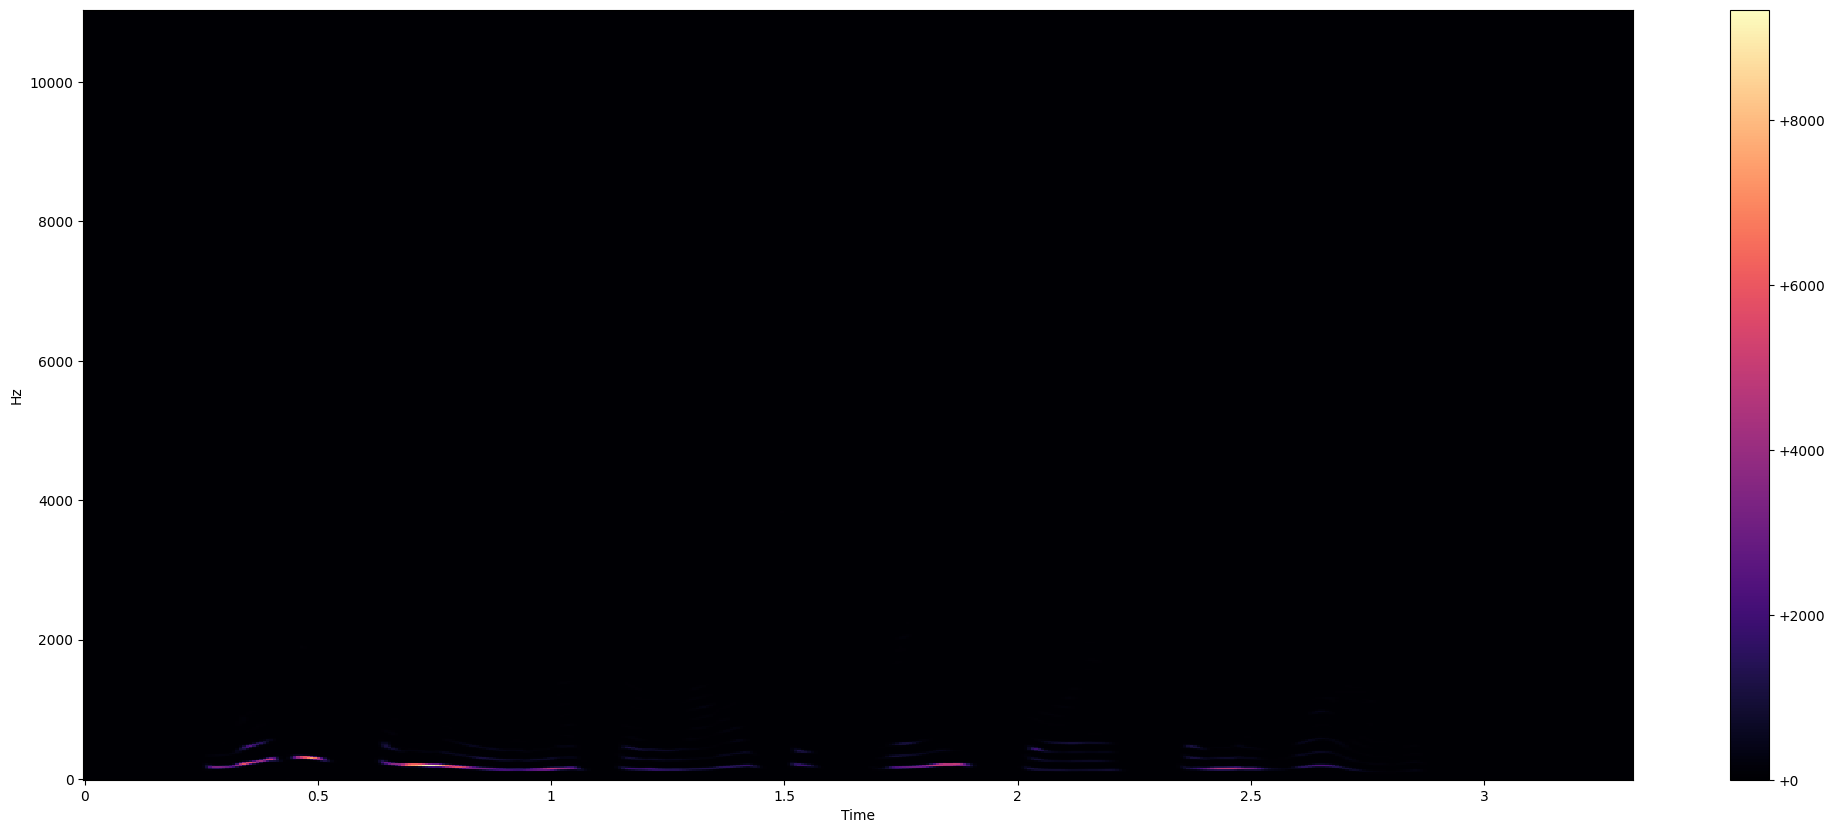

In [ ]:
plot_spectrogram(Y_scale, sr, HOP_SIZE)

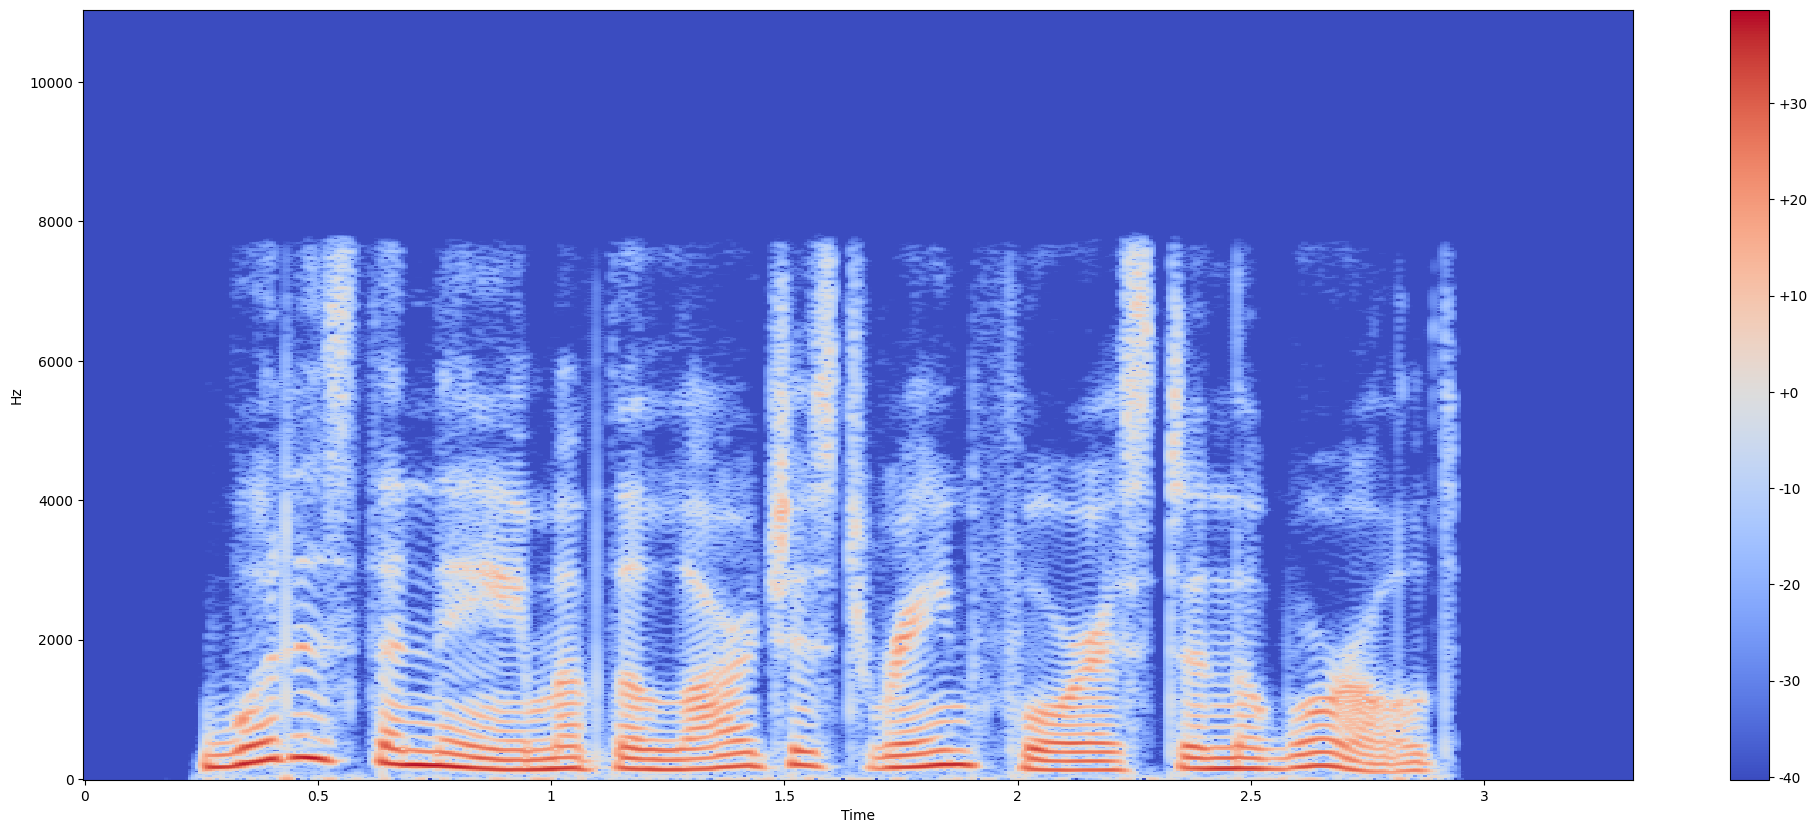

In [ ]:
Y_log_scale = librosa.power_to_db(Y_scale)
plot_spectrogram(Y_log_scale, sr, HOP_SIZE)

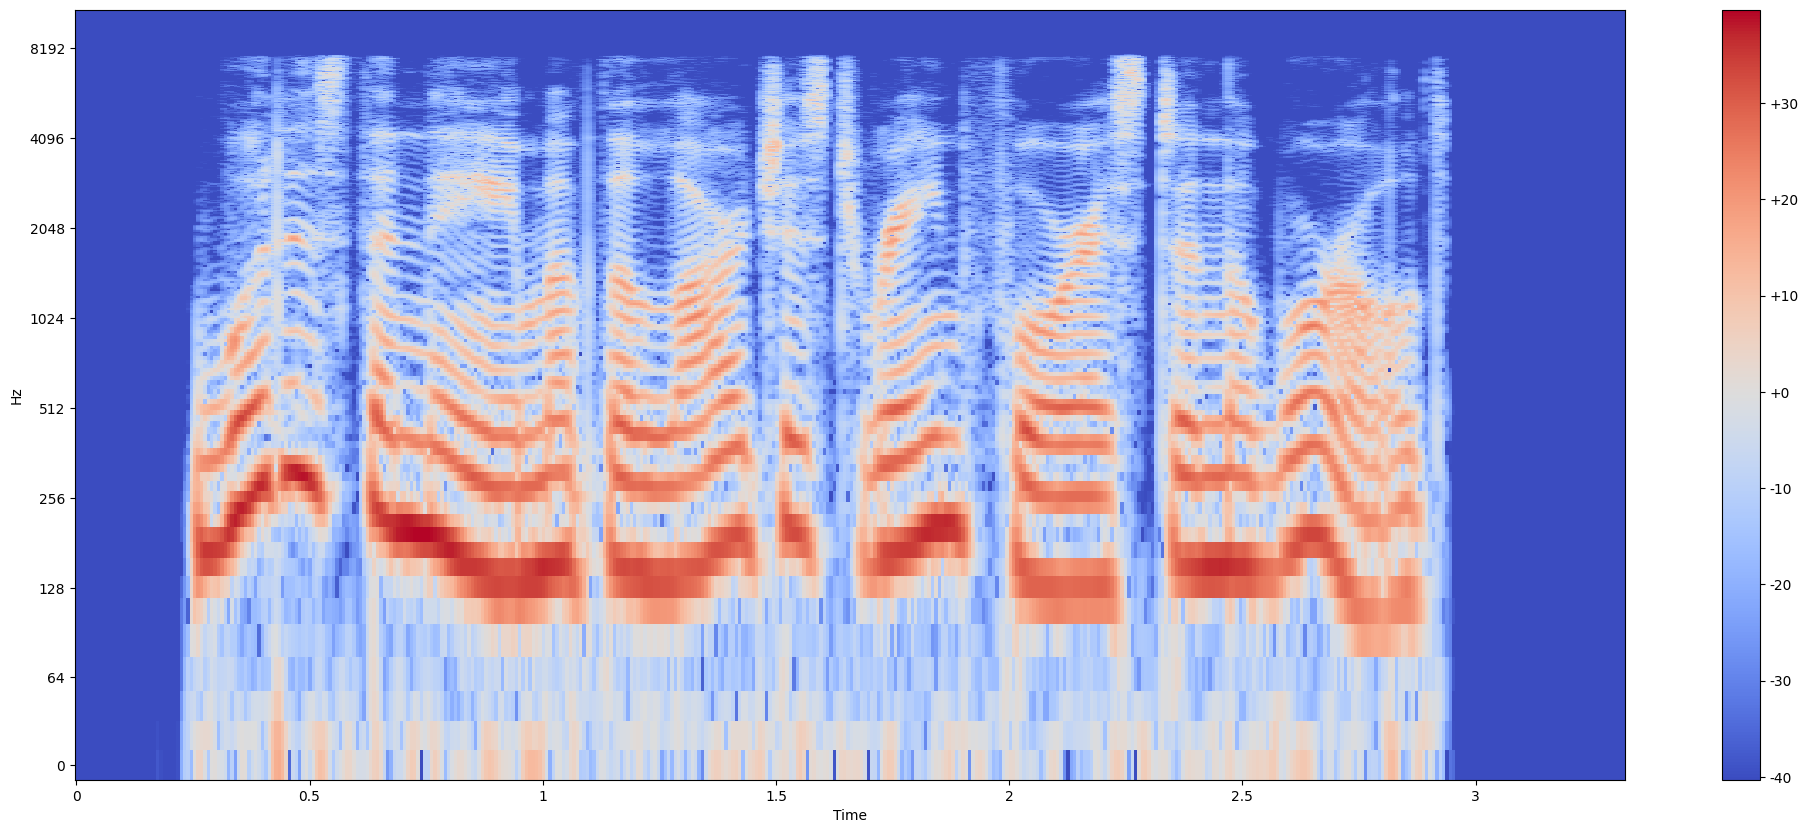

In [ ]:
plot_spectrogram(Y_log_scale, sr, HOP_SIZE, y_axis="log")

In [ ]:
filter_banks = librosa.filters.mel(n_fft=400, sr=22050, n_mels=80)

In [ ]:
filter_banks.shape

(80, 201)

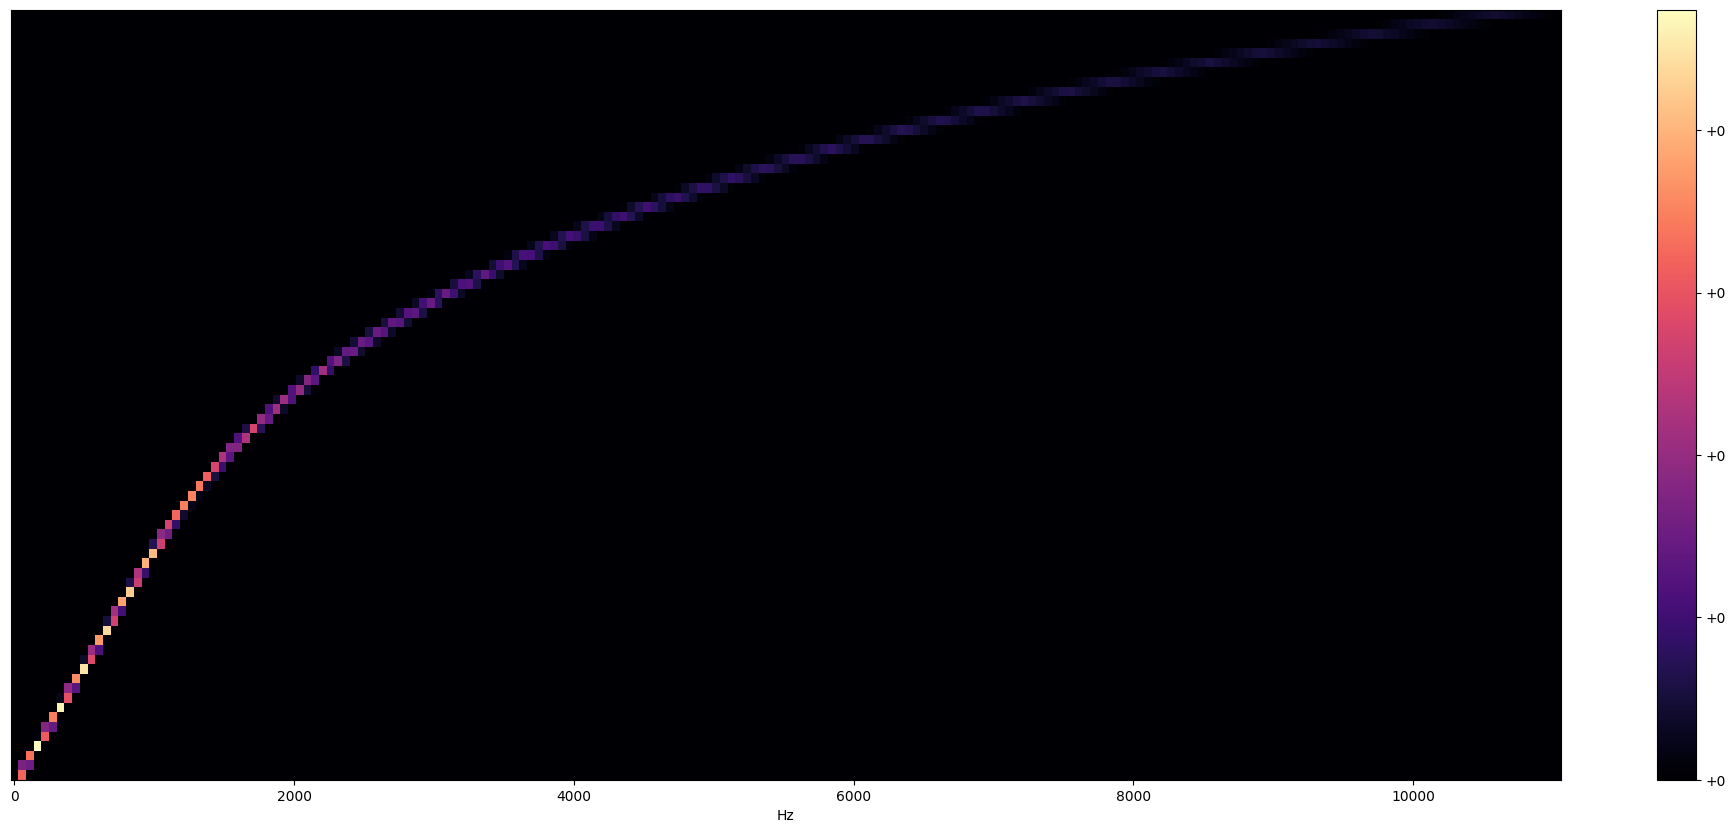

In [ ]:
plt.figure(figsize=(25, 10))
librosa.display.specshow(filter_banks,
                         sr=sr,
                         x_axis="linear")
plt.colorbar(format="%+2.f")
plt.show()



```
we take audio waveform - [1,480000] samples contain the info abt the amplitude at that second.

This is the length of each frame in terms of the number of samples. For example, if your frame size is 400 samples, each frame will contain 400 samples from the original waveform.

step size by which you move forward to the next frame. For example, if your hop size is 160 samples, the next frame will start 160 samples after the start of the current frame

frame:short, overlapping segment of the audio signal processed individually by the STFT to capture time-varying frequency content. Each frame contains a subset of the total samples, and the total number of frames depends on the hop size and the length of the audio signal.

STFT:
Short Time Fourier Transform or STFT and so what the short time Fourier
transform does it computes several Fourier transforms at different intervals and in doing so it preserves information about time
and the way sound evolved it’s over time right and so the different intervals at which we perform the Fourier transform is given by the frame size
and so a frame is a bunch of samples and so we fix the number of samples

let’s consider only for example 200 samples and do the Fourier transform there and
then let’s move on to let’s shift and move on to to the rest lack of the waveform and
what happens here is that we get a spectogram which gives us information of (time + frequency + magnitude).



waveform is converted to melspectrogram by performing stft.
In stft,we calculate for each frames and all samples of that frame unlike dft.
#frequency_bins=[framesize/2]+1 =400/2+1=201
#frames= 480000/160 +1 = 3001
hence the output of stft is [201,3001]
then this values of stft are complex so we square them to get real values and then get magnitude - [1,201,3000].
we have to convert the frequencies to mel scale by using no of mel bands =80 [hyperparameter] if it is lower then good for music.

construct mel-filter banks-apply triangular filters. mel filter shape (#bands,framesize/2+1)--[201,80]
then mel_spectrogram by multiplying the magnitudes with mel filter.T --[80,3000]
input features--[1,80,3000]
then you pass it through encoder and decoder to get the transcribed text.

melscale is better at detecting differences in lower frequencies than higher frequencies.

hop_length:length of hop between stft windows.




in case of long form transcription--

waveform torch.Size([1, 2878270])
window torch.Size([400])
stft torch.Size([1, 201, 17990])
magnitudes torch.Size([1, 201, 17989])
mel_filters torch.Size([201, 80])
mel_spec torch.Size([1, 80, 17989])

total_input_frames=17989
the input features are divided into segments where each segment has 3000 frames
each segment is passed through encoder and decoder and then get start and end time and tokens of the text
there are 6 segments here as 17989/3000 and then we add them to final segments
total sequences=478

as each of the segment is added we get our final_segment and detokenisation takes place.

MFCCS are not being used here - we can obtain them by performing discrete cosine transform on the log mel spectrogram  


In [ ]:
waveform torch.Size([1, 480000])
window torch.Size([400])
stft torch.Size([1, 201, 3001])
magnitudes torch.Size([1, 201, 3000])
mel_filters torch.Size([201, 80])
mel_spec torch.Size([1, 80, 3000])
log_spec torch.Size([1, 80, 3000])

self.mel_filters = mel_filter_bank
            num_frequency_bins=1 + n_fft // 2,
            num_mel_filters=feature_size,
            min_frequency=0.0,
            max_frequency=8000.0



In [ ]:
text1 = transcribe("/p020_freeform_speech_01.wav")
print(text1)


waveform torch.Size([1, 2878270])
window torch.Size([400])
stft torch.Size([1, 201, 17990])
magnitudes torch.Size([1, 201, 17989])
mel_filters torch.Size([201, 80])
mel_spec torch.Size([1, 80, 17989])
log_spec torch.Size([1, 80, 17989])
padded_inputs-input-features torch.Size([1, 80, 17989])
padded_inputs [input features] tensor([[[-0.3128,  0.0666,  0.0834,  ...,  0.3663,  0.3142,  0.1446],
         [-0.2027, -0.1945, -0.1649,  ...,  0.0923,  0.0495, -0.0991],
         [-0.3592, -0.5859, -0.5141,  ..., -0.6066, -0.3960, -0.4222],
         ...,
         [-1.0143, -1.0143, -1.0143,  ..., -1.0143, -1.0143, -1.0143],
         [-1.0143, -1.0143, -1.0143,  ..., -1.0143, -1.0143, -1.0143],
         [-1.0143, -1.0143, -1.0143,  ..., -1.0143, -1.0143, -1.0143]]])
num of frames None
model_inputs {'input_features': tensor([[[-0.3128,  0.0666,  0.0834,  ...,  0.3663,  0.3142,  0.1446],
         [-0.2027, -0.1945, -0.1649,  ...,  0.0923,  0.0495, -0.0991],
         [-0.3592, -0.5859, -0.5141,  ...

/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:485: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


longform transcription
inputfeatures,time_offset,seek_num_frames tensor([[[-0.3128,  0.0666,  0.0834,  ...,  0.3663,  0.3142,  0.1446],
         [-0.2027, -0.1945, -0.1649,  ...,  0.0923,  0.0495, -0.0991],
         [-0.3592, -0.5859, -0.5141,  ..., -0.6066, -0.3960, -0.4222],
         ...,
         [-1.0143, -1.0143, -1.0143,  ..., -1.0143, -1.0143, -1.0143],
         [-1.0143, -1.0143, -1.0143,  ..., -1.0143, -1.0143, -1.0143],
         [-1.0143, -1.0143, -1.0143,  ..., -1.0143, -1.0143, -1.0143]]]) tensor([0.]) tensor([3000])
segment_input -cut out next 30s segment tensor([[[-0.3128,  0.0666,  0.0834,  ...,  0.3890,  0.5028,  0.5289],
         [-0.2027, -0.1945, -0.1649,  ...,  0.1192,  0.2323,  0.2621],
         [-0.3592, -0.5859, -0.5141,  ..., -0.1592, -0.1420,  0.1180],
         ...,
         [-1.0143, -1.0143, -1.0143,  ..., -0.9686, -0.6927, -0.6642],
         [-1.0143, -1.0143, -1.0143,  ..., -0.9475, -0.5847, -0.6465],
         [-1.0143, -1.0143, -1.0143,  ..., -1.0143, -0.7

In [ ]:
print(text1)

 Alright, so I'm in this capture room that I think we called Audio and I see a lot of microphones around. I think probably over 100 outside Mulsons at. And there's a couple of cameras, different brands. I see a keynaked, I see another camera, with rectangular camera body and lens. I think they are pointing at the middle of the room. And the room is painted white. It's not painted actually, it's a lot of form, it's off to material. It's grayish, not grayish between white and gray, I think. I would say milk, something. I don't know. I'm not good at colors. Yeah, so there's a lot of cables around. I see there's a microphone in front of me. Actually, there are three microphones. One is, I think it's a boom microphone. looks like very professional and there's another like that look like a stick one is very thin and other is I think it's one inch something yeah they are shiny I think they are made of steel and the other one is black yeah so I think they are yeah probably there's a lot of mic

In [3]:
text1 = transcribe("/p020_freeform_speech_01.wav")
print(text1)

/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:480: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


input_features: Float values of mel features extracted from the raw speech waveform. Raw speech waveform can be obtained by loading a `.flac` or `.wav` audio file into an array of type
input_features shape torch.Size([1, 80, 3000])
hidden_states torch.Size([1, 1500, 512])
hidden_states torch.Size([1, 1500, 512])
hidden_states torch.Size([1, 1500, 512])
hidden_states torch.Size([1, 1500, 512])
hidden_states torch.Size([1, 1500, 512])
hidden_states torch.Size([1, 1500, 512])
hidden_states torch.Size([1, 1500, 512])
hidden_states torch.Size([1, 1500, 512])
hidden_states torch.Size([1, 1500, 512])
hidden_states torch.Size([1, 1500, 512])
hidden_states torch.Size([1, 1500, 512])
hidden_states torch.Size([1, 1500, 512])
hidden_states (`torch.FloatTensor`): input to the layer of shape `(batch, seq_len, embed_dim)
hidden_States torch.Size([1, 1, 512])
hidden_states torch.Size([1, 1, 512])
hidden_states torch.Size([1, 1, 512])
hidden_states (`torch.FloatTensor`): input to the layer of shape `(b

modeling_whisper.py


In [ ]:
# coding=utf-8
# Copyright 2022 The OpenAI Authors and The HuggingFace Inc. team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""PyTorch Whisper model."""

import math
from typing import Optional, Tuple, Union

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch import nn
from torch.nn import CrossEntropyLoss
from transformers.models.speecht5 import number_normalizer
print("modelling whisper")

from ...activations import ACT2FN
from ...modeling_attn_mask_utils import _prepare_4d_causal_attention_mask, _prepare_4d_causal_attention_mask_for_sdpa
from ...modeling_outputs import (
    BaseModelOutput,
    BaseModelOutputWithPastAndCrossAttentions,
    CausalLMOutputWithCrossAttentions,
    Seq2SeqLMOutput,
    Seq2SeqModelOutput,
    SequenceClassifierOutput,
)
from ...modeling_utils import PreTrainedModel
from ...utils import (
    add_start_docstrings,
    add_start_docstrings_to_model_forward,
    is_flash_attn_2_available,
    is_flash_attn_greater_or_equal_2_10,
    logging,
    replace_return_docstrings,
)
from .configuration_whisper import WhisperConfig
from .generation_whisper import WhisperGenerationMixin


if is_flash_attn_2_available():
    from flash_attn import flash_attn_func, flash_attn_varlen_func
    from flash_attn.bert_padding import index_first_axis, pad_input, unpad_input  # noqa


logger = logging.get_logger(__name__)

_HIDDEN_STATES_START_POSITION = 1

_CONFIG_FOR_DOC = "WhisperConfig"
_CHECKPOINT_FOR_DOC = "openai/whisper-base"


# Copied from transformers.models.llama.modeling_llama._get_unpad_data
def _get_unpad_data(attention_mask):
    seqlens_in_batch = attention_mask.sum(dim=-1, dtype=torch.int32)
    indices = torch.nonzero(attention_mask.flatten(), as_tuple=False).flatten()
    max_seqlen_in_batch = seqlens_in_batch.max().item()
    cu_seqlens = F.pad(torch.cumsum(seqlens_in_batch, dim=0, dtype=torch.int32), (1, 0))
    return (
        indices,
        cu_seqlens,
        max_seqlen_in_batch,
    )

print("modeling_whisper.py")

def sinusoids(length: int, channels: int, max_timescale: float = 10000) -> torch.Tensor:
    """Returns sinusoids for positional embedding"""
    if channels % 2 != 0:
        raise ValueError(
            f"Number of channels has to be divisible by 2 for sinusoidal positional embeddings, got {channels} channels."
        )
    log_timescale_increment = math.log(max_timescale) / (channels // 2 - 1)
    inv_timescales = torch.exp(-log_timescale_increment * torch.arange(channels // 2))
    scaled_time = torch.arange(length).view(-1, 1) * inv_timescales.view(1, -1)
    print("no of channels",channels)
    print("sinusoids:torch.cat([scaled_time.sin(), scaled_time.cos()], dim=1)",torch.cat([scaled_time.sin(), scaled_time.cos()], dim=1))


    return torch.cat([scaled_time.sin(), scaled_time.cos()], dim=1)


# Copied from transformers.models.bart.modeling_bart.shift_tokens_right
def shift_tokens_right(input_ids: torch.Tensor, pad_token_id: int, decoder_start_token_id: int):
    """
    Shift input ids one token to the right.
    """
    shifted_input_ids = input_ids.new_zeros(input_ids.shape)
    shifted_input_ids[:, 1:] = input_ids[:, :-1].clone()
    shifted_input_ids[:, 0] = decoder_start_token_id


    if pad_token_id is None:
        raise ValueError("self.model.config.pad_token_id has to be defined.")
    # replace possible -100 values in labels by `pad_token_id`
    shifted_input_ids.masked_fill_(shifted_input_ids == -100, pad_token_id)
    print("shifted_input_ids",shifted_input_ids)

    return shifted_input_ids


# Copied from transformers.models.wav2vec2.modeling_wav2vec2._compute_mask_indices
def _compute_mask_indices(
    shape: Tuple[int, int],
    mask_prob: float,
    mask_length: int,
    attention_mask: Optional[torch.LongTensor] = None,
    min_masks: int = 0,
) -> np.ndarray:
    """
    Computes random mask spans for a given shape. Used to implement [SpecAugment: A Simple Data Augmentation Method for
    ASR](https://arxiv.org/abs/1904.08779). Note that this method is not optimized to run on TPU and should be run on
    CPU as part of the preprocessing during training.

    Args:
        shape: The shape for which to compute masks. This should be of a tuple of size 2 where
               the first element is the batch size and the second element is the length of the axis to span.
        mask_prob:  The percentage of the whole axis (between 0 and 1) which will be masked. The number of
                    independently generated mask spans of length `mask_length` is computed by
                    `mask_prob*shape[1]/mask_length`. Note that due to overlaps, `mask_prob` is an upper bound and the
                    actual percentage will be smaller.
        mask_length: size of the mask
        min_masks: minimum number of masked spans
        attention_mask: A (right-padded) attention mask which independently shortens the feature axis of
                        each batch dimension.
    """
    batch_size, sequence_length = shape
    print("batch_size,sequence_length",batch_size,sequence_length)

    if mask_length < 1:
        raise ValueError("`mask_length` has to be bigger than 0.")

    if mask_length > sequence_length:
        raise ValueError(
            f"`mask_length` has to be smaller than `sequence_length`, but got `mask_length`: {mask_length}"
            f" and `sequence_length`: {sequence_length}`"
        )

    # epsilon is used for probabilistic rounding
    epsilon = np.random.rand(1).item()

    def compute_num_masked_span(input_length):
        """Given input length, compute how many spans should be masked"""
        num_masked_span = int(mask_prob * input_length / mask_length + epsilon)
        num_masked_span = max(num_masked_span, min_masks)

        # make sure num masked span <= sequence_length
        if num_masked_span * mask_length > sequence_length:
            num_masked_span = sequence_length // mask_length

        # make sure num_masked span is also <= input_length - (mask_length - 1)
        if input_length - (mask_length - 1) < num_masked_span:
            num_masked_span = max(input_length - (mask_length - 1), 0)
        print("input_length",input_length)
        #print("num_masked_span",len(num_masked_span))

        return num_masked_span

    # compute number of masked spans in batch
    input_lengths = (
        attention_mask.sum(-1).detach().tolist()
        if attention_mask is not None
        else [sequence_length for _ in range(batch_size)]
    )

    # SpecAugment mask to fill
    spec_aug_mask = np.zeros((batch_size, sequence_length), dtype=bool)
    spec_aug_mask_idxs = []

    max_num_masked_span = compute_num_masked_span(sequence_length)

    if max_num_masked_span == 0:
        return spec_aug_mask

    for input_length in input_lengths:
        # compute num of masked spans for this input
        num_masked_span = compute_num_masked_span(input_length)

        # get random indices to mask
        spec_aug_mask_idx = np.random.choice(
            np.arange(input_length - (mask_length - 1)), num_masked_span, replace=False
        )

        # pick first sampled index that will serve as a dummy index to pad vector
        # to ensure same dimension for all batches due to probabilistic rounding
        # Picking first sample just pads those vectors twice.
        if len(spec_aug_mask_idx) == 0:
            # this case can only happen if `input_length` is strictly smaller then
            # `sequence_length` in which case the last token has to be a padding
            # token which we can use as a dummy mask id
            dummy_mask_idx = sequence_length - 1
        else:
            dummy_mask_idx = spec_aug_mask_idx[0]

        spec_aug_mask_idx = np.concatenate(
            [spec_aug_mask_idx, np.ones(max_num_masked_span - num_masked_span, dtype=np.int32) * dummy_mask_idx]
        )
        spec_aug_mask_idxs.append(spec_aug_mask_idx)

    spec_aug_mask_idxs = np.array(spec_aug_mask_idxs)

    # expand masked indices to masked spans
    spec_aug_mask_idxs = np.broadcast_to(
        spec_aug_mask_idxs[:, :, None], (batch_size, max_num_masked_span, mask_length)
    )
    spec_aug_mask_idxs = spec_aug_mask_idxs.reshape(batch_size, max_num_masked_span * mask_length)

    # add offset to the starting indexes so that indexes now create a span
    offsets = np.arange(mask_length)[None, None, :]
    offsets = np.broadcast_to(offsets, (batch_size, max_num_masked_span, mask_length)).reshape(
        batch_size, max_num_masked_span * mask_length
    )
    spec_aug_mask_idxs = spec_aug_mask_idxs + offsets

    # ensure that we cannot have indices larger than sequence_length
    if spec_aug_mask_idxs.max() > sequence_length - 1:
        spec_aug_mask_idxs[spec_aug_mask_idxs > sequence_length - 1] = sequence_length - 1

    # scatter indices to mask
    np.put_along_axis(spec_aug_mask, spec_aug_mask_idxs, 1, -1)

    return spec_aug_mask


class WhisperPositionalEmbedding(nn.Embedding):
    def __init__(self, num_positions: int, embedding_dim: int, padding_idx: Optional[int] = None):
        super().__init__(num_positions, embedding_dim)

    def forward(self, input_ids, past_key_values_length=0, position_ids=None):
        #print("input_ids in whisperpositionalembeddings class",input_ids)

        if position_ids is None:
          #  print("postion_ids is none",self.weight[past_key_values_length : past_key_values_length + input_ids.shape[1]])
            return self.weight[past_key_values_length : past_key_values_length + input_ids.shape[1]]
        else:
            return self.weight[position_ids]


class WhisperAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(
        self,
        embed_dim: int,
        num_heads: int,
        dropout: float = 0.0,
        is_decoder: bool = False,
        bias: bool = True,
        is_causal: bool = False,
        config: Optional[WhisperConfig] = None,
    ):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = embed_dim // num_heads
        self.config = config
        #print("no of heads,head_dim,embed_dim",num_heads,embed_dim,embed_dim)

        if (self.head_dim * num_heads) != self.embed_dim:
            raise ValueError(
                f"embed_dim must be divisible by num_heads (got `embed_dim`: {self.embed_dim}"
                f" and `num_heads`: {num_heads})."
            )
        self.scaling = self.head_dim**-0.5
        self.is_decoder = is_decoder
        self.is_causal = is_causal

        self.k_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.v_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=bias)
        ##print("k,q,v",self.k_proj.shape,self.q_proj.shape,self.v_proj.shape)

    # Copied from transformers.models.bart.modeling_bart.BartAttention._shape with BART->whisper
    def _shape(self, tensor: torch.Tensor, seq_len: int, bsz: int):
        return tensor.view(bsz, seq_len, self.num_heads, self.head_dim).transpose(1, 2).contiguous()

    # Copied from transformers.models.bart.modeling_bart.BartAttention.forward with BART->whisper
    def forward(
        self,
        hidden_states: torch.Tensor,
        key_value_states: Optional[torch.Tensor] = None,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
        attention_mask: Optional[torch.Tensor] = None,
        layer_head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        """Input shape: Batch x Time x Channel"""

        # if key_value_states are provided this layer is used as a cross-attention layer
        # for the decoder
        print("hidden_states",hidden_states.shape)
        is_cross_attention = key_value_states is not None

        bsz, tgt_len, _ = hidden_states.size()
        print("bsz,tgt_len:",bsz,tgt_len)

        # get query proj
        query_states = self.q_proj(hidden_states) * self.scaling
        # get key, value proj
        # `past_key_value[0].shape[2] == key_value_states.shape[1]`
        # is checking that the `sequence_length` of the `past_key_value` is the same as
        # the provided `key_value_states` to support prefix tuning
        if (
            is_cross_attention
            and past_key_value is not None
            and past_key_value[0].shape[2] == key_value_states.shape[1]
        ):
            # reuse k,v, cross_attentions
            key_states = past_key_value[0]
            value_states = past_key_value[1]
        elif is_cross_attention:
            # cross_attentions
            key_states = self._shape(self.k_proj(key_value_states), -1, bsz)
            value_states = self._shape(self.v_proj(key_value_states), -1, bsz)
        elif past_key_value is not None:
            # reuse k, v, self_attention
            key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(hidden_states), -1, bsz)
            key_states = torch.cat([past_key_value[0], key_states], dim=2)
            value_states = torch.cat([past_key_value[1], value_states], dim=2)
        else:
            # self_attention
            key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(hidden_states), -1, bsz)

        if self.is_decoder:
            # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
            # Further calls to cross_attention layer can then reuse all cross-attention
            # key/value_states (first "if" case)
            # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
            # all previous decoder key/value_states. Further calls to uni-directional self-attention
            # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
            # if encoder bi-directional self-attention `past_key_value` is always `None`
            past_key_value = (key_states, value_states)

        proj_shape = (bsz * self.num_heads, -1, self.head_dim)
        query_states = self._shape(query_states, tgt_len, bsz).view(*proj_shape)
        key_states = key_states.reshape(*proj_shape)
        value_states = value_states.reshape(*proj_shape)
       # print("query,key,value",query_states.shape,key_states,value_states)

        src_len = key_states.size(1)
        attn_weights = torch.bmm(query_states, key_states.transpose(1, 2))
        #print("attn_weights",attn_weights.shape)

        if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
            raise ValueError(
                f"Attention weights should be of size {(bsz * self.num_heads, tgt_len, src_len)}, but is"
                f" {attn_weights.size()}"
            )

        if attention_mask is not None:
            if attention_mask.size() != (bsz, 1, tgt_len, src_len):
                raise ValueError(
                    f"Attention mask should be of size {(bsz, 1, tgt_len, src_len)}, but is {attention_mask.size()}"
                )
            attn_weights = attn_weights.view(bsz, self.num_heads, tgt_len, src_len) + attention_mask
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

        attn_weights = nn.functional.softmax(attn_weights, dim=-1)
        #print("attn_weights after softmax",attn_weights.shape)

        if layer_head_mask is not None:
            if layer_head_mask.size() != (self.num_heads,):
                raise ValueError(
                    f"Head mask for a single layer should be of size {(self.num_heads,)}, but is"
                    f" {layer_head_mask.size()}"
                )
            attn_weights = layer_head_mask.view(1, -1, 1, 1) * attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
            attn_weights = attn_weights.view(bsz * self.num_heads, tgt_len, src_len)

        if output_attentions:
            # this operation is a bit awkward, but it's required to
            # make sure that attn_weights keeps its gradient.
            # In order to do so, attn_weights have to be reshaped
            # twice and have to be reused in the following
            attn_weights_reshaped = attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
            attn_weights = attn_weights_reshaped.view(bsz * self.num_heads, tgt_len, src_len)
        else:
            attn_weights_reshaped = None

        attn_probs = nn.functional.dropout(attn_weights, p=self.dropout, training=self.training)

        attn_output = torch.bmm(attn_probs, value_states)

        if attn_output.size() != (bsz * self.num_heads, tgt_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(bsz * self.num_heads, tgt_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )

        attn_output = attn_output.view(bsz, self.num_heads, tgt_len, self.head_dim)
        attn_output = attn_output.transpose(1, 2)

        # Use the `embed_dim` from the config (stored in the class) rather than `hidden_state` because `attn_output` can be
        # partitioned across GPUs when using tensor-parallelism.
        attn_output = attn_output.reshape(bsz, tgt_len, self.embed_dim)

        attn_output = self.out_proj(attn_output)
        #print("attn_output",attn_output.shape)

        return attn_output, attn_weights_reshaped, past_key_value


# Copied from transformers.models.bart.modeling_bart.BartFlashAttention2 with Bart->Whisper
class WhisperFlashAttention2(WhisperAttention):
    """
    Whisper flash attention module. This module inherits from `WhisperAttention` as the weights of the module stays
    untouched. The only required change would be on the forward pass where it needs to correctly call the public API of
    flash attention and deal with padding tokens in case the input contains any of them.
    """

    # Copied from transformers.models.llama.modeling_llama.LlamaFlashAttention2.__init__
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # TODO: Should be removed once Flash Attention for RoCm is bumped to 2.1.
        # flash_attn<2.1 generates top-left aligned causal mask, while what is needed here is bottom-right alignement, that was made default for flash_attn>=2.1. This attribute is used to handle this difference. Reference: https://github.com/Dao-AILab/flash-attention/releases/tag/v2.1.0.
        # Beware that with flash_attn<2.1, using q_seqlen != k_seqlen (except for the case q_seqlen == 1) produces a wrong mask (top-left).
        self._flash_attn_uses_top_left_mask = not is_flash_attn_greater_or_equal_2_10()

    def _reshape(self, tensor: torch.Tensor, seq_len: int, bsz: int):
        return tensor.view(bsz, seq_len, self.num_heads, self.head_dim)

    def forward(
        self,
        hidden_states: torch.Tensor,
        key_value_states: Optional[torch.Tensor] = None,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
        attention_mask: Optional[torch.Tensor] = None,
        layer_head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        # WhisperFlashAttention2 attention does not support output_attentions
        if output_attentions:
            raise ValueError("WhisperFlashAttention2 attention does not support output_attentions")

        # if key_value_states are provided this layer is used as a cross-attention layer
        # for the decoder
        is_cross_attention = key_value_states is not None

        bsz, q_len, _ = hidden_states.size()

        # get query proj
        query_states = self._reshape(self.q_proj(hidden_states), -1, bsz)
        # get key, value proj
        # `past_key_value[0].shape[2] == key_value_states.shape[1]`
        # is checking that the `sequence_length` of the `past_key_value` is the same as
        # the provided `key_value_states` to support prefix tuning
        if (
            is_cross_attention
            and past_key_value is not None
            and past_key_value[0].shape[2] == key_value_states.shape[1]
        ):
            # reuse k,v, cross_attentions
            key_states = past_key_value[0].transpose(1, 2)
            value_states = past_key_value[1].transpose(1, 2)
        elif is_cross_attention:
            # cross_attentions
            key_states = self._reshape(self.k_proj(key_value_states), -1, bsz)
            value_states = self._reshape(self.v_proj(key_value_states), -1, bsz)
        elif past_key_value is not None:
            # reuse k, v, self_attention
            key_states = self._reshape(self.k_proj(hidden_states), -1, bsz)
            value_states = self._reshape(self.v_proj(hidden_states), -1, bsz)
            key_states = torch.cat([past_key_value[0].transpose(1, 2), key_states], dim=1)
            value_states = torch.cat([past_key_value[1].transpose(1, 2), value_states], dim=1)
        else:
            # self_attention
            key_states = self._reshape(self.k_proj(hidden_states), -1, bsz)
            value_states = self._reshape(self.v_proj(hidden_states), -1, bsz)

        if self.is_decoder:
            # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
            # Further calls to cross_attention layer can then reuse all cross-attention
            # key/value_states (first "if" case)
            # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
            # all previous decoder key/value_states. Further calls to uni-directional self-attention
            # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
            # if encoder bi-directional self-attention `past_key_value` is always `None`
            past_key_value = (key_states.transpose(1, 2), value_states.transpose(1, 2))

        kv_seq_len = key_states.shape[-2]
        if past_key_value is not None:
            kv_seq_len += past_key_value[0].shape[-2]

        # In PEFT, usually we cast the layer norms in float32 for training stability reasons
        # therefore the input hidden states gets silently casted in float32. Hence, we need
        # cast them back in the correct dtype just to be sure everything works as expected.
        # This might slowdown training & inference so it is recommended to not cast the LayerNorms
        # in fp32. (LlamaRMSNorm handles it correctly)

        input_dtype = query_states.dtype
        if input_dtype == torch.float32:
            if torch.is_autocast_enabled():
                target_dtype = torch.get_autocast_gpu_dtype()
            # Handle the case where the model is quantized
            elif hasattr(self.config, "_pre_quantization_dtype"):
                target_dtype = self.config._pre_quantization_dtype
            else:
                target_dtype = self.q_proj.weight.dtype

            logger.warning_once(
                f"The input hidden states seems to be silently casted in float32, this might be related to"
                f" the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in"
                f" {target_dtype}."
            )

            query_states = query_states.to(target_dtype)
            key_states = key_states.to(target_dtype)
            value_states = value_states.to(target_dtype)

        attn_output = self._flash_attention_forward(
            query_states, key_states, value_states, attention_mask, q_len, dropout=self.dropout
        )

        attn_output = attn_output.reshape(bsz, q_len, -1)
        attn_output = self.out_proj(attn_output)

        if not output_attentions:
            attn_weights = None
        print("whisper flash_attn-attn_output",attn_output)
        print("flash_attn_attn_weights",attn_weights)



        return attn_output, attn_weights, past_key_value

    # Copied from transformers.models.llama.modeling_llama.LlamaFlashAttention2._flash_attention_forward
    def _flash_attention_forward(
        self, query_states, key_states, value_states, attention_mask, query_length, dropout=0.0, softmax_scale=None
    ):
        """
        Calls the forward method of Flash Attention - if the input hidden states contain at least one padding token
        first unpad the input, then computes the attention scores and pad the final attention scores.

        Args:
            query_states (`torch.Tensor`):
                Input query states to be passed to Flash Attention API
            key_states (`torch.Tensor`):
                Input key states to be passed to Flash Attention API
            value_states (`torch.Tensor`):
                Input value states to be passed to Flash Attention API
            attention_mask (`torch.Tensor`):
                The padding mask - corresponds to a tensor of size `(batch_size, seq_len)` where 0 stands for the
                position of padding tokens and 1 for the position of non-padding tokens.
            dropout (`float`):
                Attention dropout
            softmax_scale (`float`, *optional*):
                The scaling of QK^T before applying softmax. Default to 1 / sqrt(head_dim)
        """
        if not self._flash_attn_uses_top_left_mask:
            causal = self.is_causal
        else:
            # TODO: Remove the `query_length != 1` check once Flash Attention for RoCm is bumped to 2.1. For details, please see the comment in LlamaFlashAttention2 __init__.
            causal = self.is_causal and query_length != 1

        # Contains at least one padding token in the sequence
        if attention_mask is not None:
            batch_size = query_states.shape[0]
            query_states, key_states, value_states, indices_q, cu_seq_lens, max_seq_lens = self._upad_input(
                query_states, key_states, value_states, attention_mask, query_length
            )

            cu_seqlens_q, cu_seqlens_k = cu_seq_lens
            max_seqlen_in_batch_q, max_seqlen_in_batch_k = max_seq_lens

            attn_output_unpad = flash_attn_varlen_func(
                query_states,
                key_states,
                value_states,
                cu_seqlens_q=cu_seqlens_q,
                cu_seqlens_k=cu_seqlens_k,
                max_seqlen_q=max_seqlen_in_batch_q,
                max_seqlen_k=max_seqlen_in_batch_k,
                dropout_p=dropout,
                softmax_scale=softmax_scale,
                causal=causal,
            )

            attn_output = pad_input(attn_output_unpad, indices_q, batch_size, query_length)
        else:
            attn_output = flash_attn_func(
                query_states, key_states, value_states, dropout, softmax_scale=softmax_scale, causal=causal
            )
        print("flash_attnforward-attn_output",attn_output.shape)


        return attn_output

    # Copied from transformers.models.llama.modeling_llama.LlamaFlashAttention2._upad_input
    def _upad_input(self, query_layer, key_layer, value_layer, attention_mask, query_length):
        indices_k, cu_seqlens_k, max_seqlen_in_batch_k = _get_unpad_data(attention_mask)
        batch_size, kv_seq_len, num_key_value_heads, head_dim = key_layer.shape

        key_layer = index_first_axis(
            key_layer.reshape(batch_size * kv_seq_len, num_key_value_heads, head_dim), indices_k
        )
        value_layer = index_first_axis(
            value_layer.reshape(batch_size * kv_seq_len, num_key_value_heads, head_dim), indices_k
        )
        if query_length == kv_seq_len:
            query_layer = index_first_axis(
                query_layer.reshape(batch_size * kv_seq_len, self.num_heads, head_dim), indices_k
            )
            cu_seqlens_q = cu_seqlens_k
            max_seqlen_in_batch_q = max_seqlen_in_batch_k
            indices_q = indices_k
        elif query_length == 1:
            max_seqlen_in_batch_q = 1
            cu_seqlens_q = torch.arange(
                batch_size + 1, dtype=torch.int32, device=query_layer.device
            )  # There is a memcpy here, that is very bad.
            indices_q = cu_seqlens_q[:-1]
            query_layer = query_layer.squeeze(1)
        else:
            # The -q_len: slice assumes left padding.
            attention_mask = attention_mask[:, -query_length:]
            query_layer, indices_q, cu_seqlens_q, max_seqlen_in_batch_q = unpad_input(query_layer, attention_mask)

        return (
            query_layer,
            key_layer,
            value_layer,
            indices_q,
            (cu_seqlens_q, cu_seqlens_k),
            (max_seqlen_in_batch_q, max_seqlen_in_batch_k),
        )


class WhisperSdpaAttention(WhisperAttention):
    # Copied from transformers.models.bart.modeling_bart.BartSdpaAttention.forward with BART->whisper, Bart->Whisper
    def forward(
        self,
        hidden_states: torch.Tensor,
        key_value_states: Optional[torch.Tensor] = None,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
        attention_mask: Optional[torch.Tensor] = None,
        layer_head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        """Input shape: Batch x Time x Channel"""
        if output_attentions or layer_head_mask is not None:
            # TODO: Improve this warning with e.g. `model.config._attn_implementation = "manual"` once this is implemented.
            logger.warning_once(
                "WhisperModel is using WhisperSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `layer_head_mask` not None. Falling back to the manual attention"
                ' implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.'
            )
            return super().forward(
                hidden_states,
                key_value_states=key_value_states,
                past_key_value=past_key_value,
                attention_mask=attention_mask,
                layer_head_mask=layer_head_mask,
                output_attentions=output_attentions,
            )

        # if key_value_states are provided this layer is used as a cross-attention layer
        # for the decoder
        print("hidden_states",hidden_states.size())
        is_cross_attention = key_value_states is not None

        bsz, tgt_len, _ = hidden_states.size()
        #print("sdpa attn :bsz,tgt_len",bsz,tgt_len)


        # get query proj
        query_states = self.q_proj(hidden_states)
        #print("query states",query_states.shape)

        # get key, value proj
        # `past_key_value[0].shape[2] == key_value_states.shape[1]`
        # is checking that the `sequence_length` of the `past_key_value` is the same as
        # the provided `key_value_states` to support prefix tuning
        if (
            is_cross_attention
            and past_key_value is not None
            and past_key_value[0].shape[2] == key_value_states.shape[1]
        ):
            # reuse k,v, cross_attentions
            key_states = past_key_value[0]
            value_states = past_key_value[1]
           # print("is cross_attn and pastkey_value is not none and past_key_value[0].shape[2] == key_value_states.shape[1] ")
            #print("key_states",key_states.shape)
            #print("value_states",value_states.shape)
        elif is_cross_attention:
            # cross_attentions
            key_states = self._shape(self.k_proj(key_value_states), -1, bsz)
            value_states = self._shape(self.v_proj(key_value_states), -1, bsz)
           # print("is cross_attn only")
            #print("key_states",key_states.shape)
            #print("value_states",value_states.shape)
        elif past_key_value is not None:
            # reuse k, v, self_attention
           # print("resuse k,v,self_attn")

            key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(hidden_states), -1, bsz)
            key_states = torch.cat([past_key_value[0], key_states], dim=2)
            value_states = torch.cat([past_key_value[1], value_states], dim=2)
           # print("key_states",key_states.shape)
            #print("value_states",value_states.shape)
        else:
            # self_attention
            key_states = self._shape(self.k_proj(hidden_states), -1, bsz)
            value_states = self._shape(self.v_proj(hidden_states), -1, bsz)
            #print("only self attn")
            #print("key_states",key_states.shape)
            #print("value_states",value_states.shape)


        if self.is_decoder:
            # if cross_attention save Tuple(torch.Tensor, torch.Tensor) of all cross attention key/value_states.
            # Further calls to cross_attention layer can then reuse all cross-attention
            # key/value_states (first "if" case)
            # if uni-directional self-attention (decoder) save Tuple(torch.Tensor, torch.Tensor) of
            # all previous decoder key/value_states. Further calls to uni-directional self-attention
            # can concat previous decoder key/value_states to current projected key/value_states (third "elif" case)
            # if encoder bi-directional self-attention `past_key_value` is always `None`
            past_key_value = (key_states, value_states)

        query_states = self._shape(query_states, tgt_len, bsz)


        # We dispatch to SDPA's Flash Attention or Efficient kernels via this `is_causal` if statement instead of an inline conditional assignment
        # in SDPA to support both torch.compile's dynamic shapes and full graph options. An inline conditional prevents dynamic shapes from compiling.
        # The tgt_len > 1 is necessary to match with AttentionMaskConverter.to_causal_4d that does not create a causal mask in case tgt_len == 1.
        is_causal = True if self.is_causal and attention_mask is None and tgt_len > 1 else False

        # NOTE: SDPA with memory-efficient backend is currently (torch==2.1.2) bugged when using non-contiguous inputs and a custom attn_mask,
        # but we are fine here as `_shape` do call `.contiguous()`. Reference: https://github.com/pytorch/pytorch/issues/112577
        attn_output = torch.nn.functional.scaled_dot_product_attention(
            query_states,
            key_states,
            value_states,
            attn_mask=attention_mask,
            dropout_p=self.dropout if self.training else 0.0,
            is_causal=is_causal,
        )
        #print("attn_output",attn_output.shape)

        if attn_output.size() != (bsz, self.num_heads, tgt_len, self.head_dim):
            raise ValueError(
                f"`attn_output` should be of size {(bsz, self.num_heads, tgt_len, self.head_dim)}, but is"
                f" {attn_output.size()}"
            )

        attn_output = attn_output.transpose(1, 2)

        # Use the `embed_dim` from the config (stored in the class) rather than `hidden_state` because `attn_output` can be
        # partitioned across GPUs when using tensor-parallelism.
        attn_output = attn_output.reshape(bsz, tgt_len, self.embed_dim)


        attn_output = self.out_proj(attn_output)
       # print("sdpa atnn after projection ",attn_output.shape)

        return attn_output, None, past_key_value


WHISPER_ATTENTION_CLASSES = {
    "eager": WhisperAttention,
    "flash_attention_2": WhisperFlashAttention2,
    "sdpa": WhisperSdpaAttention,
}

#print("whisper encoder layer")
# Copied from transformers.models.mbart.modeling_mbart.MBartEncoderLayer with MBart->Whisper, MBART->WHISPER
class WhisperEncoderLayer(nn.Module):
    def __init__(self, config: WhisperConfig):
        super().__init__()
        self.embed_dim = config.d_model

        self.self_attn = WHISPER_ATTENTION_CLASSES[config._attn_implementation](
            embed_dim=self.embed_dim,
            num_heads=config.encoder_attention_heads,
            dropout=config.attention_dropout,
            config=config,
        )
        self.self_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.dropout = config.dropout
        self.activation_fn = ACT2FN[config.activation_function]
        self.activation_dropout = config.activation_dropout
        self.fc1 = nn.Linear(self.embed_dim, config.encoder_ffn_dim)
        self.fc2 = nn.Linear(config.encoder_ffn_dim, self.embed_dim)
        self.final_layer_norm = nn.LayerNorm(self.embed_dim)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: torch.Tensor,
        layer_head_mask: torch.Tensor,
        output_attentions: bool = False,
    ) -> torch.Tensor:
        """
        Args:
            hidden_states (`torch.FloatTensor`): input to the layer of shape `(batch, seq_len, embed_dim)`
            attention_mask (`torch.FloatTensor`): attention mask of size
                `(batch, 1, tgt_len, src_len)` where padding elements are indicated by very large negative values.
            layer_head_mask (`torch.FloatTensor`): mask for attention heads in a given layer of size
                `(encoder_attention_heads,)`.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
        """
        residual = hidden_states
        hidden_states = self.self_attn_layer_norm(hidden_states)
        hidden_states, attn_weights, _ = self.self_attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            layer_head_mask=layer_head_mask,
            output_attentions=output_attentions,
        )
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
        #print("hidden_states",hidden_states)
        print("hidden_states",hidden_states.shape)

        residual = hidden_states
        hidden_states = self.final_layer_norm(hidden_states)
        hidden_states = self.activation_fn(self.fc1(hidden_states))
        hidden_states = nn.functional.dropout(hidden_states, p=self.activation_dropout, training=self.training)
        hidden_states = self.fc2(hidden_states)
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states

        if hidden_states.dtype == torch.float16 and (
            torch.isinf(hidden_states).any() or torch.isnan(hidden_states).any()
        ):
            clamp_value = torch.finfo(hidden_states.dtype).max - 1000
            hidden_states = torch.clamp(hidden_states, min=-clamp_value, max=clamp_value)

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (attn_weights,)
        ##print("output of encoder",outputs.shape)
        #print("output of encoder layer",len(outputs))


        return outputs


# Copied from transformers.models.mbart.modeling_mbart.MBartDecoderLayer with MBart->Whisper, MBART->WHISPER
class WhisperDecoderLayer(nn.Module):
    def __init__(self, config: WhisperConfig):
        super().__init__()
        self.embed_dim = config.d_model

        self.self_attn = WHISPER_ATTENTION_CLASSES[config._attn_implementation](
            embed_dim=self.embed_dim,
            num_heads=config.decoder_attention_heads,
            dropout=config.attention_dropout,
            is_decoder=True,
            is_causal=True,
            config=config,
        )
        self.dropout = config.dropout
        self.activation_fn = ACT2FN[config.activation_function]
        self.activation_dropout = config.activation_dropout

        self.self_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.encoder_attn = WHISPER_ATTENTION_CLASSES[config._attn_implementation](
            self.embed_dim,
            config.decoder_attention_heads,
            dropout=config.attention_dropout,
            is_decoder=True,
            config=config,
        )
        self.encoder_attn_layer_norm = nn.LayerNorm(self.embed_dim)
        self.fc1 = nn.Linear(self.embed_dim, config.decoder_ffn_dim)
        self.fc2 = nn.Linear(config.decoder_ffn_dim, self.embed_dim)
        self.final_layer_norm = nn.LayerNorm(self.embed_dim)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        layer_head_mask: Optional[torch.Tensor] = None,
        cross_attn_layer_head_mask: Optional[torch.Tensor] = None,
        past_key_value: Optional[Tuple[torch.Tensor]] = None,
        output_attentions: Optional[bool] = False,
        use_cache: Optional[bool] = True,
    ) -> torch.Tensor:
        """
        Args:
            hidden_states (`torch.FloatTensor`): input to the layer of shape `(batch, seq_len, embed_dim)`
            attention_mask (`torch.FloatTensor`): attention mask of size
                `(batch, 1, tgt_len, src_len)` where padding elements are indicated by very large negative values.
            encoder_hidden_states (`torch.FloatTensor`):
                cross attention input to the layer of shape `(batch, seq_len, embed_dim)`
            encoder_attention_mask (`torch.FloatTensor`): encoder attention mask of size
                `(batch, 1, tgt_len, src_len)` where padding elements are indicated by very large negative values.
            layer_head_mask (`torch.FloatTensor`): mask for attention heads in a given layer of size
                `(encoder_attention_heads,)`.
            cross_attn_layer_head_mask (`torch.FloatTensor`): mask for cross-attention heads in a given layer of
                size `(decoder_attention_heads,)`.
            past_key_value (`Tuple(torch.FloatTensor)`): cached past key and value projection states
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
        """
        residual = hidden_states
        hidden_states = self.self_attn_layer_norm(hidden_states)
        print("hidden_states (`torch.FloatTensor`): input to the layer of shape `(batch, seq_len, embed_dim)")
        print("hidden_States",hidden_states.shape)
        #print("this is decoder layer")

        # Self Attention
        # decoder uni-directional self-attention cached key/values tuple is at positions 1,2
        self_attn_past_key_value = past_key_value[:2] if past_key_value is not None else None
        # add present self-attn cache to positions 1,2 of present_key_value tuple
        hidden_states, self_attn_weights, present_key_value = self.self_attn(
            hidden_states=hidden_states,
            past_key_value=self_attn_past_key_value,
            attention_mask=attention_mask,
            layer_head_mask=layer_head_mask,
            output_attentions=output_attentions,
        )
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states
       # print("hidden_states",hidden_states.shape)

        # Cross-Attention Block
        cross_attn_present_key_value = None
        cross_attn_weights = None
        if encoder_hidden_states is not None:
            residual = hidden_states
            hidden_states = self.encoder_attn_layer_norm(hidden_states)
            #print("hidden_states when encoder_hidden is not none",hidden_states.shape)

            # cross_attn cached key/values tuple is at positions 3,4 of present_key_value tuple
            cross_attn_past_key_value = past_key_value[-2:] if past_key_value is not None else None
            hidden_states, cross_attn_weights, cross_attn_present_key_value = self.encoder_attn(
                hidden_states=hidden_states,
                key_value_states=encoder_hidden_states,
                attention_mask=encoder_attention_mask,
                layer_head_mask=cross_attn_layer_head_mask,
                past_key_value=cross_attn_past_key_value,
                output_attentions=output_attentions,
            )
            hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
            hidden_states = residual + hidden_states

            # add cross-attn to positions 3,4 of present_key_value tuple
            present_key_value = present_key_value + cross_attn_present_key_value
            #print("present_key_value after add cross attn to 3,4 positions",present_key_value.shape)

        # Fully Connected
        residual = hidden_states
        hidden_states = self.final_layer_norm(hidden_states)
        hidden_states = self.activation_fn(self.fc1(hidden_states))
        hidden_states = nn.functional.dropout(hidden_states, p=self.activation_dropout, training=self.training)
        hidden_states = self.fc2(hidden_states)
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        hidden_states = residual + hidden_states

        outputs = (hidden_states,)

        if output_attentions:
            outputs += (self_attn_weights, cross_attn_weights)

        if use_cache:
            outputs += (present_key_value,)
        #print("output after cross attn",outputs.shape)
        #print("output after fully connected layer:self,cross",len(outputs[0]),len(outputs[1]))
        #print("len of outputs after fc",len(outputs))



        return outputs


class WhisperPreTrainedModel(PreTrainedModel):
    config_class = WhisperConfig
    base_model_prefix = "model"
    main_input_name = "input_features"
    supports_gradient_checkpointing = True
    _no_split_modules = ["WhisperEncoderLayer", "WhisperDecoderLayer"]
    _supports_flash_attn_2 = True
    _supports_sdpa = True

    def _init_weights(self, module):
        std = self.config.init_std
        if isinstance(module, (nn.Linear, nn.Conv1d)):
            module.weight.data.normal_(mean=0.0, std=std)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=std)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, WhisperEncoder):
            with torch.no_grad():
                embed_positions = module.embed_positions.weight
                embed_positions.copy_(sinusoids(*embed_positions.shape))

    def _get_feat_extract_output_lengths(self, input_lengths: torch.LongTensor):
        """
        Computes the output length of the convolutional layers
        """
        input_lengths = (input_lengths - 1) // 2 + 1
        #print("output length of conv layers",input_lengths)

        return input_lengths


WHISPER_START_DOCSTRING = r"""
    This model inherits from [`PreTrainedModel`]. Check the superclass documentation for the generic methods the
    library implements for all its model (such as downloading or saving, resizing the input embeddings, pruning heads
    etc.)

    This model is also a PyTorch [torch.nn.Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module) subclass.
    Use it as a regular PyTorch Module and refer to the PyTorch documentation for all matter related to general usage
    and behavior.

    Parameters:
        config ([`WhisperConfig`]):
            Model configuration class with all the parameters of the model. Initializing with a config file does not
            load the weights associated with the model, only the configuration. Check out the
            [`~PreTrainedModel.from_pretrained`] method to load the model weights.
"""

WHISPER_INPUTS_DOCSTRING = r"""
    Args:
        input_features (`torch.FloatTensor` of shape `(batch_size, feature_size, sequence_length)`):
            Float values mel features extracted from the raw speech waveform. Raw speech waveform can be obtained by
            loading a `.flac` or `.wav` audio file into an array of type `List[float]` or a `numpy.ndarray`, *e.g.* via
            the soundfile library (`pip install soundfile`). To prepare the array into `input_features`, the
            [`AutoFeatureExtractor`] should be used for extracting the mel features, padding and conversion into a
            tensor of type `torch.FloatTensor`. See [`~WhisperFeatureExtractor.__call__`]
        attention_mask (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Mask to avoid performing *SpecAugment* data augmentation on padding token indices. Mask values selected in
            `[0, 1]`:

            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.

            [What are attention masks?](../glossary#attention-mask)
        decoder_input_ids (`torch.LongTensor` of shape `(batch_size, target_sequence_length)`, *optional*):
            Indices of decoder input sequence tokens in the vocabulary.

            Indices can be obtained using [`WhisperTokenizer`]. See [`PreTrainedTokenizer.encode`] and
            [`PreTrainedTokenizer.__call__`] for details.

            [What are decoder input IDs?](../glossary#decoder-input-ids)

            Whisper uses the `decoder_start_token_id` as the starting token for `decoder_input_ids` generation. If
            `past_key_values` is used, optionally only the last `decoder_input_ids` have to be input (see
            `past_key_values`).
        decoder_attention_mask (`torch.LongTensor` of shape `(batch_size, target_sequence_length)`, *optional*):
            Default behavior: generate a tensor that ignores pad tokens in `decoder_input_ids`. Causal mask will also
            be used by default.

            If you want to change padding behavior, you should read
            [`modeling_whisper._prepare_decoder_attention_mask`] and modify to your needs. See diagram 1 in [the BART
            paper](https://arxiv.org/abs/1910.13461) for more information on the default strategy.
        head_mask (`torch.Tensor` of shape `(encoder_layers, encoder_attention_heads)`, *optional*):
            Mask to nullify selected heads of the attention modules in the encoder. Mask values selected in `[0, 1]`:

            - 1 indicates the head is **not masked**,
            - 0 indicates the head is **masked**.

        decoder_head_mask (`torch.Tensor` of shape `(decoder_layers, decoder_attention_heads)`, *optional*):
            Mask to nullify selected heads of the attention modules in the decoder. Mask values selected in `[0, 1]`:

            - 1 indicates the head is **not masked**,
            - 0 indicates the head is **masked**.

        cross_attn_head_mask (`torch.Tensor` of shape `(decoder_layers, decoder_attention_heads)`, *optional*):
            Mask to nullify selected heads of the cross-attention modules. Mask values selected in `[0, 1]`:

            - 1 indicates the head is **not masked**,
            - 0 indicates the head is **masked**.

        encoder_outputs (`tuple(tuple(torch.FloatTensor)`, *optional*):
            Tuple consists of (`last_hidden_state`, *optional*: `hidden_states`, *optional*: `attentions`)
            `last_hidden_state` of shape `(batch_size, sequence_length, hidden_size)`, *optional*) is a sequence of
            hidden-states at the output of the last layer of the encoder. Used in the cross-attention of the decoder.
        past_key_values (`tuple(tuple(torch.FloatTensor))`, *optional*, returned when `use_cache=True` is passed or when `config.use_cache=True`):
            Tuple of `tuple(torch.FloatTensor)` of length `config.n_layers`, with each tuple having 2 tensors of shape
            `(batch_size, num_heads, sequence_length, embed_size_per_head)`) and 2 additional tensors of shape
            `(batch_size, num_heads, encoder_sequence_length, embed_size_per_head)`.

            Contains pre-computed hidden-states (key and values in the self-attention blocks and in the cross-attention
            blocks) that can be used (see `past_key_values` input) to speed up sequential decoding.

            If `past_key_values` are used, the user can optionally input only the last `decoder_input_ids` (those that
            don't have their past key value states given to this model) of shape `(batch_size, 1)` instead of all
            `decoder_input_ids` of shape `(batch_size, sequence_length)`.
        decoder_inputs_embeds (`torch.FloatTensor` of shape `(batch_size, target_sequence_length, hidden_size)`, *optional*):
            Optionally, instead of passing `decoder_input_ids` you can choose to directly pass an embedded
            representation. If `past_key_values` is used, optionally only the last `decoder_inputs_embeds` have to be
            input (see `past_key_values`). This is useful if you want more control over how to convert
            `decoder_input_ids` indices into associated vectors than the model's internal embedding lookup matrix.
        use_cache (`bool`, *optional*):
            If set to `True`, `past_key_values` key value states are returned and can be used to speed up decoding (see
            `past_key_values`).
        output_attentions (`bool`, *optional*):
            Whether or not to return the attentions tensors of all attention layers. See `attentions` under returned
            tensors for more detail.
        output_hidden_states (`bool`, *optional*):
            Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors for
            more detail.
        return_dict (`bool`, *optional*):
            Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
"""

WHISPER_ENCODER_INPUTS_DOCSTRING = r"""
    Args:
        input_features (`torch.FloatTensor` of shape `(batch_size, feature_size, sequence_length)`):
            Float values mel features extracted from the raw speech waveform. Raw speech waveform can be obtained by
            loading a `.flac` or `.wav` audio file into an array of type `List[float]` or a `numpy.ndarray`, *e.g.* via
            the soundfile library (`pip install soundfile`). To prepare the array into `input_features`, the
            [`AutoFeatureExtractor`] should be used for extracting the mel features, padding and conversion into a
            tensor of type `torch.FloatTensor`. See [`~WhisperFeatureExtractor.__call__`]
        head_mask (`torch.Tensor` of shape `(encoder_layers, encoder_attention_heads)`, *optional*):
            Mask to nullify selected heads of the attention modules in the encoder. Mask values selected in `[0, 1]`:

            - 1 indicates the head is **not masked**,
            - 0 indicates the head is **masked**.
        encoder_outputs (`tuple(tuple(torch.FloatTensor)`, *optional*):
            Tuple consists of (`last_hidden_state`, *optional*: `hidden_states`, *optional*: `attentions`)
            `last_hidden_state` of shape `(batch_size, sequence_length, hidden_size)`, *optional*) is a sequence of
            hidden-states at the output of the last layer of the encoder.
        output_attentions (`bool`, *optional*):
            Whether or not to return the attentions tensors of all attention layers. See `attentions` under returned
            tensors for more detail.
        output_hidden_states (`bool`, *optional*):
            Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors for
            more detail.
        return_dict (`bool`, *optional*):
            Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
"""


class WhisperEncoder(WhisperPreTrainedModel):
    """
    Transformer encoder consisting of *config.encoder_layers* self attention layers. Each layer is a
    [`WhisperEncoderLayer`].

    Args:
        config: WhisperConfig
    """

    def __init__(self, config: WhisperConfig):
        super().__init__(config)
        self.dropout = config.dropout
        self.layerdrop = config.encoder_layerdrop

        embed_dim = config.d_model
        print("embed_dim",embed_dim)
        self.num_mel_bins = config.num_mel_bins
        print("num_mel_bins",config.num_mel_bins)
        self.padding_idx = config.pad_token_id
       # print("padding_idx",self.padding_idx)
        self.max_source_positions = config.max_source_positions
        self.embed_scale = math.sqrt(embed_dim) if config.scale_embedding else 1.0

        self.conv1 = nn.Conv1d(self.num_mel_bins, embed_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(embed_dim, embed_dim, kernel_size=3, stride=2, padding=1)

        self.embed_positions = nn.Embedding(self.max_source_positions, embed_dim)

        self.embed_positions.requires_grad_(False)

        self.layers = nn.ModuleList([WhisperEncoderLayer(config) for _ in range(config.encoder_layers)])
        self.layer_norm = nn.LayerNorm(config.d_model)

        self.gradient_checkpointing = False
        # Initialize weights and apply final processing
        self.post_init()

    def _freeze_parameters(self):
        for param in self.parameters():
            param.requires_grad = False
        self._requires_grad = False

    def get_input_embeddings(self) -> nn.Module:
        return self.conv1

    def set_input_embeddings(self, value: nn.Module):
        self.conv1 = value

    def forward(
        self,
        input_features,
        attention_mask=None,
        head_mask=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        Args:
            input_features (`torch.LongTensor` of shape `(batch_size, feature_size, sequence_length)`):
                Float values of mel features extracted from the raw speech waveform. Raw speech waveform can be
                obtained by loading a `.flac` or `.wav` audio file into an array of type `List[float]` or a
                `numpy.ndarray`, *e.g.* via the soundfile library (`pip install soundfile`). To prepare the array into
                `input_features`, the [`AutoFeatureExtractor`] should be used for extracting the mel features, padding
                and conversion into a tensor of type `torch.FloatTensor`. See [`~WhisperFeatureExtractor.__call__`]
            attention_mask (`torch.Tensor`)`, *optional*):
                Whisper does not support masking of the `input_features`, this argument is preserved for compatibility,
                but it is not used. By default the silence in the input log mel spectrogram are ignored.
            head_mask (`torch.Tensor` of shape `(encoder_layers, encoder_attention_heads)`, *optional*):
                Mask to nullify selected heads of the attention modules. Mask values selected in `[0, 1]`:

                - 1 indicates the head is **not masked**,
                - 0 indicates the head is **masked**.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
            output_hidden_states (`bool`, *optional*):
                Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors
                for more detail.
            return_dict (`bool`, *optional*):
                Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
        """

        expected_seq_length = self.config.max_source_positions * self.conv1.stride[0] * self.conv2.stride[0]
        if input_features.shape[-1] != expected_seq_length:
            raise ValueError(
                f"Whisper expects the mel input features to be of length {expected_seq_length}, but found {input_features.shape[-1]}. Make sure to pad the input mel features to {expected_seq_length}."
            )
        print("input_features: Float values of mel features extracted from the raw speech waveform. Raw speech waveform can be obtained by loading a `.flac` or `.wav` audio file into an array of type")
        print("input_features shape",input_features.shape)


        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        inputs_embeds = nn.functional.gelu(self.conv1(input_features))
        inputs_embeds = nn.functional.gelu(self.conv2(inputs_embeds))

        inputs_embeds = inputs_embeds.permute(0, 2, 1)
        #print("input_embeds",inputs_embeds)
        #print("input_embeds shape",inputs_embeds.shape)
        embed_pos = self.embed_positions.weight

        hidden_states = inputs_embeds + embed_pos
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)
        #print("hidden states",hidden_states.shape)

        encoder_states = () if output_hidden_states else None
        all_attentions = () if output_attentions else None

        # check if head_mask has a correct number of layers specified if desired
        if head_mask is not None:
            assert head_mask.size()[0] == (
                len(self.layers)
            ), f"The head_mask should be specified for {len(self.layers)} layers, but it is for {head_mask.size()[0]}."

        for idx, encoder_layer in enumerate(self.layers):
            if output_hidden_states:
                encoder_states = encoder_states + (hidden_states,)
                #print("encoder_states",encoder_states)
            # add LayerDrop (see https://arxiv.org/abs/1909.11556 for description)
            to_drop = False
            if self.training:
                dropout_probability = torch.rand([])
                if dropout_probability < self.layerdrop:  # skip the layer
                    to_drop = True

            if to_drop:
                layer_outputs = (None, None)
            else:
                if self.gradient_checkpointing and self.training:
                    layer_outputs = self._gradient_checkpointing_func(
                        encoder_layer.__call__,
                        hidden_states,
                        None,
                        (head_mask[idx] if head_mask is not None else None),
                        output_attentions,
                    )
                else:
                    layer_outputs = encoder_layer(
                        hidden_states,
                        None,
                        layer_head_mask=(head_mask[idx] if head_mask is not None else None),
                        output_attentions=output_attentions,
                    )

                hidden_states = layer_outputs[0]

            if output_attentions:
                all_attentions = all_attentions + (layer_outputs[1],)

        hidden_states = self.layer_norm(hidden_states)
        if output_hidden_states:
            encoder_states = encoder_states + (hidden_states,)

        if not return_dict:
            return tuple(v for v in [hidden_states, encoder_states, all_attentions] if v is not None)
        return BaseModelOutput(
            last_hidden_state=hidden_states, hidden_states=encoder_states, attentions=all_attentions
        )


class WhisperDecoder(WhisperPreTrainedModel):
    """
    Transformer decoder consisting of *config.decoder_layers* layers. Each layer is a [`WhisperDecoderLayer`]

    Args:
        config: WhisperConfig
    """

    main_input_name = "input_ids"
    #print("pretrained decoder layer")

    def __init__(self, config: WhisperConfig):
        super().__init__(config)
        self.dropout = config.dropout
        self.layerdrop = config.decoder_layerdrop
        self.padding_idx = config.pad_token_id
        self.max_target_positions = config.max_target_positions
        self.max_source_positions = config.max_source_positions
        self.embed_scale = math.sqrt(config.d_model) if config.scale_embedding else 1.0

        self.embed_tokens = nn.Embedding(config.vocab_size, config.d_model, self.padding_idx)
        self.embed_positions = WhisperPositionalEmbedding(self.max_target_positions, config.d_model)

        self.layers = nn.ModuleList([WhisperDecoderLayer(config) for _ in range(config.decoder_layers)])
        self._use_flash_attention_2 = config._attn_implementation == "flash_attention_2"
        self._use_sdpa = config._attn_implementation == "sdpa"

        self.layer_norm = nn.LayerNorm(config.d_model)

        self.gradient_checkpointing = False
        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.embed_tokens

    def set_input_embeddings(self, value):
        self.embed_tokens = value

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        encoder_hidden_states=None,
        head_mask=None,
        cross_attn_head_mask=None,
        past_key_values=None,
        inputs_embeds=None,
        position_ids=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        Args:
            input_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`):
                Indices of input sequence tokens in the vocabulary. Padding will be ignored by default should you
                provide it.

                Indices can be obtained using [`WhisperTokenizer`]. See [`PreTrainedTokenizer.encode`] and
                [`PreTrainedTokenizer.__call__`] for details.

                [What are input IDs?](../glossary#input-ids)
            attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
                Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:

                - 1 for tokens that are **not masked**,
                - 0 for tokens that are **masked**.

                [What are attention masks?](../glossary#attention-mask)
            encoder_hidden_states (`torch.FloatTensor` of shape `(batch_size, encoder_sequence_length, hidden_size)`, *optional*):
                Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention
                of the decoder.
            head_mask (`torch.Tensor` of shape `(decoder_layers, decoder_attention_heads)`, *optional*):
                Mask to nullify selected heads of the attention modules. Mask values selected in `[0, 1]`:

                - 1 indicates the head is **not masked**,
                - 0 indicates the head is **masked**.

            cross_attn_head_mask (`torch.Tensor` of shape `(decoder_layers, decoder_attention_heads)`, *optional*):
                Mask to nullify selected heads of the attention modules in encoder to avoid performing cross-attention
                on hidden heads. Mask values selected in `[0, 1]`:

                - 1 indicates the head is **not masked**,
                - 0 indicates the head is **masked**.

            past_key_values (`tuple(tuple(torch.FloatTensor))`, *optional*, returned when `use_cache=True` is passed or when `config.use_cache=True`):
                Tuple of `tuple(torch.FloatTensor)` of length `config.n_layers`, with each tuple having 2 tensors of
                shape `(batch_size, num_heads, sequence_length, embed_size_per_head)`) and 2 additional tensors of
                shape `(batch_size, num_heads, encoder_sequence_length, embed_size_per_head)`.

                Contains pre-computed hidden-states (key and values in the self-attention blocks and in the
                cross-attention blocks) that can be used (see `past_key_values` input) to speed up sequential decoding.

                If `past_key_values` are used, the user can optionally input only the last `decoder_input_ids` (those
                that don't have their past key value states given to this model) of shape `(batch_size, 1)` instead of
                all `decoder_input_ids` of shape `(batch_size, sequence_length)`.
            inputs_embeds (`torch.FloatTensor` of
                shape `(batch_size, sequence_length, hidden_size)`, *optional*): Optionally, instead of passing
                `input_ids` you can choose to directly pass an embedded representation. This is useful if you want more
                control over how to convert `input_ids` indices into associated vectors than the model's internal
                embedding lookup matrix.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
            output_hidden_states (`bool`, *optional*):
                Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors
                for more detail.
            return_dict (`bool`, *optional*):
                Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.
        """
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else self.config.use_cache
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # retrieve input_ids and inputs_embeds
        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both decoder_input_ids and decoder_inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
            input_ids = input_ids.view(-1, input_shape[-1])
           # print("input_ids",input_shape)

        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
            #print("input_embeds",input_shape)

        else:
            raise ValueError("You have to specify either decoder_input_ids or decoder_inputs_embeds")

        # past_key_values_length
        past_key_values_length = past_key_values[0][0].shape[2] if past_key_values is not None else 0

        if inputs_embeds is None:
            inputs_embeds = self.embed_tokens(input_ids)

        if self._use_flash_attention_2:
            # 2d mask is passed through the layers
            attention_mask = attention_mask if (attention_mask is not None and 0 in attention_mask) else None
        elif self._use_sdpa and head_mask is None and not output_attentions:
            # output_attentions=True & head_mask can not be supported when using SDPA.
            attention_mask = _prepare_4d_causal_attention_mask_for_sdpa(
                attention_mask, input_shape, inputs_embeds, past_key_values_length
            )
        else:
            # 4d mask is passed through the layers
            attention_mask = _prepare_4d_causal_attention_mask(
                attention_mask, input_shape, inputs_embeds, past_key_values_length
            )

        # embed positions
        if input_ids is not None:
            positions = self.embed_positions(
                input_ids, past_key_values_length=past_key_values_length, position_ids=position_ids
            )
        else:
            positions = self.embed_positions(
                inputs_embeds, past_key_values_length=past_key_values_length, position_ids=position_ids
            )

        hidden_states = inputs_embeds + positions.to(inputs_embeds.device)
        hidden_states = nn.functional.dropout(hidden_states, p=self.dropout, training=self.training)

        if self.gradient_checkpointing and self.training:
            if use_cache:
                logger.warning_once(
                    "`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`..."
                )
                use_cache = False
        # decoder layers
        all_hidden_states = () if output_hidden_states else None
        all_self_attns = () if output_attentions else None
        all_cross_attentions = () if (output_attentions and encoder_hidden_states is not None) else None
        next_decoder_cache = () if use_cache else None

        # check if head_mask/cross_attn_head_mask has a correct number of layers specified if desired
        for attn_mask, mask_name in zip([head_mask, cross_attn_head_mask], ["head_mask", "cross_attn_head_mask"]):
            if attn_mask is not None:
                assert attn_mask.size()[0] == (len(self.layers)), (
                    f"The `{mask_name}` should be specified for {len(self.layers)} layers, but it is for"
                    f" {head_mask.size()[0]}."
                )
        for idx, decoder_layer in enumerate(self.layers):
            # add LayerDrop (see https://arxiv.org/abs/1909.11556 for description)
            if output_hidden_states:
                all_hidden_states += (hidden_states,)
            if self.training:
                dropout_probability = torch.rand([])
                if dropout_probability < self.layerdrop:
                    continue

            past_key_value = past_key_values[idx] if past_key_values is not None else None

            if self.gradient_checkpointing and self.training:
                layer_outputs = self._gradient_checkpointing_func(
                    decoder_layer.__call__,
                    hidden_states,
                    attention_mask,
                    encoder_hidden_states,
                    None,  # encoder attention mask
                    head_mask[idx] if head_mask is not None else None,
                    cross_attn_head_mask[idx] if cross_attn_head_mask is not None else None,
                    None,  # past_key_value
                    output_attentions,
                    use_cache,
                )
            else:
                layer_outputs = decoder_layer(
                    hidden_states,
                    attention_mask=attention_mask,
                    encoder_hidden_states=encoder_hidden_states,
                    layer_head_mask=(head_mask[idx] if head_mask is not None else None),
                    cross_attn_layer_head_mask=(
                        cross_attn_head_mask[idx] if cross_attn_head_mask is not None else None
                    ),
                    past_key_value=past_key_value,
                    output_attentions=output_attentions,
                    use_cache=use_cache,
                )
            hidden_states = layer_outputs[0]

            if use_cache:
                next_decoder_cache += (layer_outputs[3 if output_attentions else 1],)

            if output_attentions:
                all_self_attns += (layer_outputs[1],)

                if encoder_hidden_states is not None:
                    all_cross_attentions += (layer_outputs[2],)

        hidden_states = self.layer_norm(hidden_states)
        # add hidden states from the last decoder layer
        if output_hidden_states:
            all_hidden_states += (hidden_states,)

        next_cache = next_decoder_cache if use_cache else None
        if not return_dict:
            return tuple(
                v
                for v in [hidden_states, next_cache, all_hidden_states, all_self_attns, all_cross_attentions]
                if v is not None
            )
        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=next_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attns,
            cross_attentions=all_cross_attentions,
        )


@add_start_docstrings(
    "The bare Whisper Model outputting raw hidden-states without any specific head on top.",
    WHISPER_START_DOCSTRING,
)
class WhisperModel(WhisperPreTrainedModel):
    def __init__(self, config: WhisperConfig):
        super().__init__(config)

        self.encoder = WhisperEncoder(config)
        self.decoder = WhisperDecoder(config)
        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.decoder.embed_tokens

    def set_input_embeddings(self, value):
        self.decoder.embed_tokens = value

    def get_encoder(self):
        return self.encoder

    def get_decoder(self):
        return self.decoder

    def freeze_encoder(self):
        """
        Calling this function will disable the gradient computation for the Whisper encoder so that its parameters will
        not be updated during training.
        """
        self.encoder._freeze_parameters()

    def _mask_input_features(
        self,
        input_features: torch.FloatTensor,
        attention_mask: Optional[torch.LongTensor] = None,
    ):
        """
        Masks extracted features along time axis and/or along feature axis according to
        [SpecAugment](https://arxiv.org/abs/1904.08779).
        """

        # `config.apply_spec_augment` can set masking to False
        if not getattr(self.config, "apply_spec_augment", True):
            return input_features

        # generate indices & apply SpecAugment along time axis
        batch_size, hidden_size, sequence_length = input_features.size()
        print("batch_size, hidden_size, sequence_length = input_features.size()",batch_size, hidden_size, sequence_length)

        if self.config.mask_time_prob > 0 and self.training:
            # generate indices & apply SpecAugment along time axis
            mask_time_indices = _compute_mask_indices(
                (batch_size, sequence_length),
                mask_prob=self.config.mask_time_prob,
                mask_length=self.config.mask_time_length,
                attention_mask=attention_mask,
                min_masks=self.config.mask_time_min_masks,
            )
            mask_time_indices = torch.tensor(mask_time_indices, device=input_features.device, dtype=torch.bool)
            mask_time_indices = mask_time_indices[:, None].expand(-1, hidden_size, -1)
            input_features[mask_time_indices] = 0

        if self.config.mask_feature_prob > 0 and self.training:
            # generate indices & apply SpecAugment along feature axis
            mask_feature_indices = _compute_mask_indices(
                (batch_size, hidden_size),
                mask_prob=self.config.mask_feature_prob,
                mask_length=self.config.mask_feature_length,
                min_masks=self.config.mask_feature_min_masks,
            )
            mask_feature_indices = torch.tensor(mask_feature_indices, device=input_features.device, dtype=torch.bool)
            input_features[mask_feature_indices] = 0
        print("input_features of whisper model class ",input_features)


        return input_features

    @add_start_docstrings_to_model_forward(WHISPER_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=Seq2SeqModelOutput, config_class=_CONFIG_FOR_DOC)
    def forward(
        self,
        input_features: Optional[torch.FloatTensor] = None,
        attention_mask: Optional[torch.LongTensor] = None,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        decoder_head_mask: Optional[torch.Tensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        encoder_outputs: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        decoder_inputs_embeds: Optional[Tuple[torch.FloatTensor]] = None,
        decoder_position_ids: Optional[Tuple[torch.LongTensor]] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], Seq2SeqModelOutput]:
        r"""
        Returns:

        Example:
         ```python
         >>> import torch
         >>> from transformers import AutoFeatureExtractor, WhisperModel
         >>> from datasets import load_dataset

         >>> model = WhisperModel.from_pretrained("openai/whisper-base")
         >>> feature_extractor = AutoFeatureExtractor.from_pretrained("openai/whisper-base")
         >>> ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation", trust_remote_code=True)
         >>> inputs = feature_extractor(ds[0]["audio"]["array"], return_tensors="pt")
         >>> input_features = inputs.input_features
         >>> decoder_input_ids = torch.tensor([[1, 1]]) * model.config.decoder_start_token_id
         >>> last_hidden_state = model(input_features, decoder_input_ids=decoder_input_ids).last_hidden_state
         >>> list(last_hidden_state.shape)
         [1, 2, 512]
         ```"""
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        use_cache = use_cache if use_cache is not None else self.config.use_cache
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if encoder_outputs is None:
            input_features = self._mask_input_features(input_features, attention_mask=attention_mask)

            encoder_outputs = self.encoder(
                input_features,
                head_mask=head_mask,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
            )
            #print("encoder_outputs",encoder_outputs)
        # If the user passed a tuple for encoder_outputs, we wrap it in a BaseModelOutput when return_dict=True
        elif return_dict and not isinstance(encoder_outputs, BaseModelOutput):
            encoder_outputs = BaseModelOutput(
                last_hidden_state=encoder_outputs[0],
                hidden_states=encoder_outputs[1] if len(encoder_outputs) > 1 else None,
                attentions=encoder_outputs[2] if len(encoder_outputs) > 2 else None,
            )

        # decoder outputs consists of (dec_features, past_key_value, dec_hidden, dec_attn)
        decoder_outputs = self.decoder(
            input_ids=decoder_input_ids,
            attention_mask=decoder_attention_mask,
            encoder_hidden_states=encoder_outputs[0],
            head_mask=decoder_head_mask,
            cross_attn_head_mask=cross_attn_head_mask,
            past_key_values=past_key_values,
            inputs_embeds=decoder_inputs_embeds,
            position_ids=decoder_position_ids,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        #print("decoder_outputs",decoder_outputs)

        if not return_dict:
            return decoder_outputs + encoder_outputs

        return Seq2SeqModelOutput(
            last_hidden_state=decoder_outputs.last_hidden_state,
            past_key_values=decoder_outputs.past_key_values,
            decoder_hidden_states=decoder_outputs.hidden_states,
            decoder_attentions=decoder_outputs.attentions,
            cross_attentions=decoder_outputs.cross_attentions,
            encoder_last_hidden_state=encoder_outputs.last_hidden_state,
            encoder_hidden_states=encoder_outputs.hidden_states,
            encoder_attentions=encoder_outputs.attentions,
        )


@add_start_docstrings(
    "The Whisper Model with a language modeling head. Can be used for automatic speech recognition.",
    WHISPER_START_DOCSTRING,
)
class WhisperForConditionalGeneration(WhisperGenerationMixin, WhisperPreTrainedModel):
    base_model_prefix = "model"
    _tied_weights_keys = ["proj_out.weight"]

    def __init__(self, config: WhisperConfig):
        super().__init__(config)
        self.model = WhisperModel(config)
        self.proj_out = nn.Linear(config.d_model, config.vocab_size, bias=False)

        # Initialize weights and apply final processing
        self.post_init()

    def get_encoder(self):
        return self.model.get_encoder()

    def get_decoder(self):
        return self.model.get_decoder()

    def get_output_embeddings(self):
        return self.proj_out

    def set_output_embeddings(self, new_embeddings):
        self.proj_out = new_embeddings

    def get_input_embeddings(self) -> nn.Module:
        return self.model.get_input_embeddings()

    def freeze_encoder(self):
        """
        Calling this function will disable the gradient computation for the Whisper encoder so that its parameters will
        not be updated during training.
        """
        self.model.encoder._freeze_parameters()

    @add_start_docstrings_to_model_forward(WHISPER_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=Seq2SeqLMOutput, config_class=_CONFIG_FOR_DOC)
    def forward(
        self,
        input_features: Optional[torch.FloatTensor] = None,
        attention_mask: Optional[torch.LongTensor] = None,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        decoder_head_mask: Optional[torch.Tensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        encoder_outputs: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        decoder_inputs_embeds: Optional[Tuple[torch.FloatTensor]] = None,
        decoder_position_ids: Optional[Tuple[torch.LongTensor]] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], Seq2SeqLMOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Labels for computing the language modeling loss. Indices should either be in `[0, ..., config.vocab_size]`
            or -100 (see `input_ids` docstring). Tokens with indices set to `-100` are ignored (masked), the loss is
            only computed for the tokens with labels in `[0, ..., config.vocab_size]`.

        Returns:

        Example:

        ```python
        >>> import torch
        >>> from transformers import AutoProcessor, WhisperForConditionalGeneration
        >>> from datasets import load_dataset

        >>> processor = AutoProcessor.from_pretrained("openai/whisper-tiny.en")
        >>> model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en")

        >>> ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation", trust_remote_code=True)

        >>> inputs = processor(ds[0]["audio"]["array"], return_tensors="pt")
        >>> input_features = inputs.input_features

        >>> generated_ids = model.generate(inputs=input_features)

        >>> transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        >>> transcription
        ' Mr. Quilter is the apostle of the middle classes, and we are glad to welcome his gospel.'
        ```"""
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if labels is not None:
            if decoder_input_ids is None and decoder_inputs_embeds is None:
                decoder_input_ids = shift_tokens_right(
                    labels, self.config.pad_token_id, self.config.decoder_start_token_id
                )

        outputs = self.model(
            input_features,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            encoder_outputs=encoder_outputs,
            decoder_attention_mask=decoder_attention_mask,
            head_mask=head_mask,
            decoder_head_mask=decoder_head_mask,
            cross_attn_head_mask=cross_attn_head_mask,
            past_key_values=past_key_values,
            decoder_inputs_embeds=decoder_inputs_embeds,
            decoder_position_ids=decoder_position_ids,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        lm_logits = self.proj_out(outputs[0])

        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss()
            # move labels to correct device to enable PP
            labels = labels.to(lm_logits.device)
            loss = loss_fct(lm_logits.view(-1, self.config.vocab_size), labels.reshape(-1))

        if not return_dict:
            output = (lm_logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return Seq2SeqLMOutput(
            loss=loss,
            logits=lm_logits,
            past_key_values=outputs.past_key_values,
            decoder_hidden_states=outputs.decoder_hidden_states,
            decoder_attentions=outputs.decoder_attentions,
            cross_attentions=outputs.cross_attentions,
            encoder_last_hidden_state=outputs.encoder_last_hidden_state,
            encoder_hidden_states=outputs.encoder_hidden_states,
            encoder_attentions=outputs.encoder_attentions,
        )

    def prepare_inputs_for_generation(
        self,
        decoder_input_ids,
        past_key_values=None,
        use_cache=None,
        encoder_outputs=None,
        attention_mask=None,
        decoder_attention_mask=None,
        **kwargs,
    ):
        decoder_position_ids = None
        if decoder_attention_mask is not None:
            decoder_position_ids = (decoder_attention_mask.cumsum(-1) - 1).clamp(min=0)

        if past_key_values is not None:
            past_length = past_key_values[0][0].shape[2]

            # Some generation methods already pass only the last input ID
            if decoder_input_ids.shape[1] > past_length:
                remove_prefix_length = past_length
            else:
                # Default to old behavior: keep only final ID
                remove_prefix_length = decoder_input_ids.shape[1] - 1

            decoder_input_ids = decoder_input_ids[:, remove_prefix_length:]

            if decoder_position_ids is not None and decoder_position_ids.shape[1] > decoder_input_ids.shape[1]:
                decoder_position_ids = decoder_position_ids[:, remove_prefix_length:]

        return {
            "encoder_outputs": encoder_outputs,
            "past_key_values": past_key_values,
            "decoder_input_ids": decoder_input_ids,
            "use_cache": use_cache,
            "decoder_attention_mask": decoder_attention_mask,
            "decoder_position_ids": decoder_position_ids,
        }

    @staticmethod
    def _reorder_cache(past_key_values, beam_idx):
        reordered_past = ()
        for layer_past in past_key_values:
            reordered_past += (
                tuple(past_state.index_select(0, beam_idx.to(past_state.device)) for past_state in layer_past),
            )
        return reordered_past


class WhisperDecoderWrapper(WhisperPreTrainedModel):
    """
    This wrapper class is a helper class to correctly load pretrained checkpoints when the causal language model is
    used in combination with the [`EncoderDecoderModel`] framework.
    """

    def __init__(self, config):
        super().__init__(config)
        config.is_encoder_decoder = False
        self.decoder = WhisperDecoder(config)

    def get_input_embeddings(self):
        return self.decoder.embed_tokens

    def set_input_embeddings(self, value):
        self.decoder.embed_tokens = value

    def forward(self, *args, **kwargs):
        return self.decoder(*args, **kwargs)


@add_start_docstrings(
    """
    Whisper decoder with a language modeling head on top (linear layer with weights tied to the input embeddings).
    """,
    WHISPER_START_DOCSTRING,
)
class WhisperForCausalLM(WhisperPreTrainedModel):
    _tied_weights_keys = ["proj_out.weight"]
    main_input_name = "input_ids"

    def __init__(self, config):
        super().__init__(config)
        config.is_encoder_decoder = False
        self.model = WhisperDecoderWrapper(config)

        self.proj_out = nn.Linear(config.hidden_size, config.vocab_size, bias=False)

        # Initialize weights and apply final processing
        self.post_init()

    def get_output_embeddings(self):
        return self.proj_out

    def set_output_embeddings(self, new_embeddings):
        self.proj_out = new_embeddings

    def get_input_embeddings(self) -> nn.Module:
        return self.model.get_input_embeddings()

    def set_input_embeddings(self, value):
        self.model.set_input_embeddings(value)

    def set_decoder(self, decoder):
        self.model.decoder = decoder

    def get_decoder(self):
        return self.model.decoder

    @replace_return_docstrings(output_type=CausalLMOutputWithCrossAttentions, config_class=_CONFIG_FOR_DOC)
    def forward(
        self,
        input_ids: torch.LongTensor = None,
        attention_mask: Optional[torch.Tensor] = None,
        encoder_outputs: Optional[Tuple[torch.FloatTensor]] = None,
        head_mask: Optional[torch.Tensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, CausalLMOutputWithCrossAttentions]:
        r"""
        Args:
            input_ids (`torch.LongTensor` of shape `(batch_size, sequence_length)`):
                Indices of input sequence tokens in the vocabulary. Padding will be ignored by default should you
                provide it. Indices can be obtained using [`AutoTokenizer`]. See [`PreTrainedTokenizer.encode`] and
                [`PreTrainedTokenizer.__call__`] for details. [What are input IDs?](../glossary#input-ids)
            attention_mask (`torch.Tensor` of shape `(batch_size, sequence_length)`, *optional*):
                Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`:
                - 1 for tokens that are **not masked**,
                - 0 for tokens that are **masked**.
                [What are attention masks?](../glossary#attention-mask)
            encoder_outputs  (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
                Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention
                if the model is configured as a decoder.
            head_mask (`torch.Tensor` of shape `(decoder_layers, decoder_attention_heads)`, *optional*):
                Mask to nullify selected heads of the attention modules. Mask values selected in `[0, 1]`:
                - 1 indicates the head is **not masked**,
                - 0 indicates the head is **masked**.
            cross_attn_head_mask (`torch.Tensor` of shape `(decoder_layers, decoder_attention_heads)`, *optional*):
                Mask to nullify selected heads of the cross-attention modules. Mask values selected in `[0, 1]`:
                - 1 indicates the head is **not masked**,
                - 0 indicates the head is **masked**.
            past_key_values (`tuple(tuple(torch.FloatTensor))`, *optional*, returned when `use_cache=True` is passed or when `config.use_cache=True`):
                Tuple of `tuple(torch.FloatTensor)` of length `config.n_layers`, with each tuple having 2 tensors of
                shape `(batch_size, num_heads, sequence_length, embed_size_per_head)`) and 2 additional tensors of
                shape `(batch_size, num_heads, encoder_sequence_length, embed_size_per_head)`. The two additional
                tensors are only required when the model is used as a decoder in a Sequence to Sequence model. Contains
                pre-computed hidden-states (key and values in the self-attention blocks and in the cross-attention
                blocks) that can be used (see `past_key_values` input) to speed up sequential decoding. If
                `past_key_values` are used, the user can optionally input only the last `decoder_input_ids` (those that
                don't have their past key value states given to this model) of shape `(batch_size, 1)` instead of all
                `decoder_input_ids` of shape `(batch_size, sequence_length)`.
            inputs_embeds (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
                Optionally, instead of passing `input_ids` you can choose to directly pass an embedded representation.
                This is useful if you want more control over how to convert `input_ids` indices into associated vectors
                than the model's internal embedding lookup matrix.
            labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
                Labels for computing the masked language modeling loss. Indices should either be in `[0, ...,
                config.vocab_size]` or -100 (see `input_ids` docstring). Tokens with indices set to `-100` are ignored
                (masked), the loss is only computed for the tokens with labels in `[0, ..., config.vocab_size]`.
            use_cache (`bool`, *optional*):
                If set to `True`, `past_key_values` key value states are returned and can be used to speed up decoding
                (see `past_key_values`).
                - 1 for tokens that are **not masked**,
                - 0 for tokens that are **masked**.
            output_attentions (`bool`, *optional*):
                Whether or not to return the attentions tensors of all attention layers. See `attentions` under
                returned tensors for more detail.
            output_hidden_states (`bool`, *optional*):
                Whether or not to return the hidden states of all layers. See `hidden_states` under returned tensors
                for more detail.
            return_dict (`bool`, *optional*):
                Whether or not to return a [`~utils.ModelOutput`] instead of a plain tuple.

        Returns:

        Example:

        ```python
        >>> from transformers import WhisperForCausalLM, WhisperForConditionalGeneration, WhisperProcessor
        >>> import torch
        >>> from datasets import load_dataset

        >>> processor = WhisperProcessor.from_pretrained("openai/whisper-large-v2")
        >>> model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-large-v2")

        >>> assistant_model = WhisperForCausalLM.from_pretrained("distil-whisper/distil-large-v2")

        >>> ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation", trust_remote_code=True)
        >>> sample = ds[0]["audio"]
        >>> input_features = processor(
        ...     sample["array"], sampling_rate=sample["sampling_rate"], return_tensors="pt"
        ... ).input_features

        >>> predicted_ids = model.generate(input_features, assistant_model=assistant_model)

        >>> # decode token ids to text
        >>> transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
        >>> transcription
        ' Mr. Quilter is the apostle of the middle classes and we are glad to welcome his gospel.'
        ```"""
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # If the user passed a tuple or `BaseModelOutput` for encoder_outputs, we extract only the hidden states
        if isinstance(encoder_outputs, (BaseModelOutput, tuple, list)):
            encoder_outputs = encoder_outputs[0]

        # decoder outputs consists of (dec_features, layer_state, dec_hidden, dec_attn)
        outputs = self.model.decoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=encoder_outputs,
            head_mask=head_mask,
            cross_attn_head_mask=cross_attn_head_mask,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        logits = self.proj_out(outputs[0])

        loss = None
        if labels is not None:
            labels = labels.to(logits.device)
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.config.vocab_size), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[1:]
            return (loss,) + output if loss is not None else output

        return CausalLMOutputWithCrossAttentions(
            loss=loss,
            logits=logits,
            past_key_values=outputs.past_key_values,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
            cross_attentions=outputs.cross_attentions,
        )

    def prepare_inputs_for_generation(
        self,
        input_ids,
        past_key_values=None,
        use_cache=None,
        encoder_outputs=None,
        attention_mask=None,
        **kwargs,
    ):
        if past_key_values is not None:
            past_length = past_key_values[0][0].shape[2]

            # Some generation methods already pass only the last input ID
            if input_ids.shape[1] > past_length:
                remove_prefix_length = past_length
            else:
                # Default to old behavior: keep only final ID
                remove_prefix_length = input_ids.shape[1] - 1

            input_ids = input_ids[:, remove_prefix_length:]

        return {
            "encoder_outputs": encoder_outputs,
            "past_key_values": past_key_values,
            "input_ids": input_ids,
            "use_cache": use_cache,
            "attention_mask": attention_mask,
        }

    @staticmethod
    def _reorder_cache(past_key_values, beam_idx):
        reordered_past = ()
        for layer_past in past_key_values:
            reordered_past += (
                tuple(past_state.index_select(0, beam_idx.to(past_state.device)) for past_state in layer_past),
            )
        return reordered_past


@add_start_docstrings(
    """
    Whisper Encoder Model with a sequence classification head on top (a linear layer over the pooled output) for tasks
    like SUPERB Keyword Spotting.
    """,
    WHISPER_ENCODER_INPUTS_DOCSTRING,
)
class WhisperForAudioClassification(WhisperPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        self.encoder = WhisperEncoder(config)
        num_layers = config.num_hidden_layers + 1  # transformer layers + input embeddings
        if config.use_weighted_layer_sum:
            self.layer_weights = nn.Parameter(torch.ones(num_layers) / num_layers)
        self.projector = nn.Linear(config.hidden_size, config.classifier_proj_size)
        self.classifier = nn.Linear(config.classifier_proj_size, config.num_labels)

        # Initialize weights and apply final processing
        self.post_init()

    def freeze_encoder(self):
        """
        Calling this function will disable the gradient computation for the Whisper encoder so that its parameters will
        not be updated during training. Only the projection layers and classification head will be updated.
        """
        self.encoder._freeze_parameters()

    def get_input_embeddings(self) -> nn.Module:
        return self.encoder.get_input_embeddings()

    def set_input_embeddings(self, value: nn.Module):
        self.encoder.set_input_embeddings(value)

    @add_start_docstrings_to_model_forward(WHISPER_ENCODER_INPUTS_DOCSTRING)
    @replace_return_docstrings(output_type=SequenceClassifierOutput, config_class=_CONFIG_FOR_DOC)
    def forward(
        self,
        input_features: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        encoder_outputs: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], SequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).

        Returns:

        Example:

        ```python
        >>> import torch
        >>> from transformers import AutoFeatureExtractor, WhisperForAudioClassification
        >>> from datasets import load_dataset

        >>> feature_extractor = AutoFeatureExtractor.from_pretrained("sanchit-gandhi/whisper-medium-fleurs-lang-id")
        >>> model = WhisperForAudioClassification.from_pretrained("sanchit-gandhi/whisper-medium-fleurs-lang-id")

        >>> ds = load_dataset("google/fleurs", "all", split="validation", streaming=True)
        >>> sample = next(iter(ds))

        >>> inputs = feature_extractor(
        ...     sample["audio"]["array"], sampling_rate=sample["audio"]["sampling_rate"], return_tensors="pt"
        ... )
        >>> input_features = inputs.input_features

        >>> with torch.no_grad():
        ...     logits = model(input_features).logits

        >>> predicted_class_ids = torch.argmax(logits).item()
        >>> predicted_label = model.config.id2label[predicted_class_ids]
        >>> predicted_label
        'Afrikaans'
        ```"""

        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        if self.config.use_weighted_layer_sum:
            output_hidden_states = True
        elif output_hidden_states is None:
            output_hidden_states = self.config.output_hidden_states

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if encoder_outputs is None:
            encoder_outputs = self.encoder(
                input_features,
                head_mask=head_mask,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
            )

        if self.config.use_weighted_layer_sum:
            hidden_states = encoder_outputs[_HIDDEN_STATES_START_POSITION]
            hidden_states = torch.stack(hidden_states, dim=1)
            norm_weights = nn.functional.softmax(self.layer_weights, dim=-1)
            hidden_states = (hidden_states * norm_weights.view(-1, 1, 1)).sum(dim=1)
        else:
            hidden_states = encoder_outputs[0]

        hidden_states = self.projector(hidden_states)
        pooled_output = hidden_states.mean(dim=1)

        logits = self.classifier(pooled_output)

        loss = None

        if labels is not None:
            loss_fct = CrossEntropyLoss()
            # move labels to correct device to enable PP
            labels = labels.to(logits.device)
            loss = loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + encoder_outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
        )


feature_extraction.py


In [ ]:
# coding=utf-8
# Copyright 2022 The HuggingFace Inc. team.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""
Feature extractor class for Whisper
"""

from typing import List, Optional, Union

import numpy as np

from ... import is_torch_available
from ...audio_utils import mel_filter_bank, spectrogram, window_function
from ...feature_extraction_sequence_utils import SequenceFeatureExtractor
from ...feature_extraction_utils import BatchFeature
from ...utils import TensorType, logging


if is_torch_available():
    import torch

logger = logging.get_logger(__name__)


class WhisperFeatureExtractor(SequenceFeatureExtractor):
    r"""
    Constructs a Whisper feature extractor.

    This feature extractor inherits from [`~feature_extraction_sequence_utils.SequenceFeatureExtractor`] which contains
    most of the main methods. Users should refer to this superclass for more information regarding those methods.

    This class extracts mel-filter bank features from raw speech using a custom numpy implementation of the `Short Time
    Fourier Transform` which should match pytorch's `torch.stft` equivalent.

    Args:
        feature_size (`int`, defaults to 80):
            The feature dimension of the extracted features.
        sampling_rate (`int`, defaults to 16000):
            The sampling rate at which the audio files should be digitalized expressed in hertz (Hz).
        hop_length (`int`, defaults to 160):
            Length of the overlaping windows for the STFT used to obtain the Mel Frequency coefficients.
        chunk_length (`int`, defaults to 30):
            The maximum number of chuncks of `sampling_rate` samples used to trim and pad longer or shorter audio
            sequences.
        n_fft (`int`, defaults to 400):
            Size of the Fourier transform.
        padding_value (`float`, *optional*, defaults to 0.0):
            Padding value used to pad the audio. Should correspond to silences.
    """

    model_input_names = ["input_features"]

    def __init__(
        self,
        feature_size=80,
        sampling_rate=16000,
        hop_length=160,
        chunk_length=30,
        n_fft=400,
        padding_value=0.0,
        return_attention_mask=False,  # pad inputs to max length with silence token (zero) and no attention mask
        **kwargs,
    ):
        super().__init__(
            feature_size=feature_size,
            sampling_rate=sampling_rate,
            padding_value=padding_value,
            return_attention_mask=return_attention_mask,
            **kwargs,
        )
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.chunk_length = chunk_length
        self.n_samples = chunk_length * sampling_rate
        self.nb_max_frames = self.n_samples // hop_length
        self.sampling_rate = sampling_rate
        self.mel_filters = mel_filter_bank(
            num_frequency_bins=1 + n_fft // 2,
            num_mel_filters=feature_size,
            min_frequency=0.0,
            max_frequency=8000.0,
            sampling_rate=sampling_rate,
            norm="slaney",
            mel_scale="slaney",
        )

    def _np_extract_fbank_features(self, waveform_batch: np.array, device: str) -> np.ndarray:
        """
        Compute the log-mel spectrogram of the provided audio, gives similar results to Whisper's original torch
        implementation with 1e-5 tolerance.
        """
        if device != "cpu":
            raise ValueError(
                f"Got device `{device}` for feature extraction, but feature extraction on CUDA accelerator "
                "devices requires torch, which is not installed. Either set `device='cpu'`, or "
                "install torch according to the official instructions: https://pytorch.org/get-started/locally/"
            )
        log_spec_batch = []
        for waveform in waveform_batch:
            log_spec = spectrogram(
                waveform,
                window_function(self.n_fft, "hann"),
                frame_length=self.n_fft,
                hop_length=self.hop_length,
                power=2.0,
                mel_filters=self.mel_filters,
                log_mel="log10",
            )
            log_spec = log_spec[:, :-1]
            log_spec = np.maximum(log_spec, log_spec.max() - 8.0)
            log_spec = (log_spec + 4.0) / 4.0
            log_spec_batch.append(log_spec)
        log_spec_batch = np.array(log_spec_batch)
        print("log_spec_batch",log_spec_batch.shape)
        return log_spec_batch

    def _torch_extract_fbank_features(self, waveform: np.array, device: str = "cpu") -> np.ndarray:
        """
        Compute the log-mel spectrogram of the audio using PyTorch's GPU-accelerated STFT implementation with batching,
        yielding results similar to cpu computing with 1e-5 tolerance.
        """
        waveform = torch.from_numpy(waveform).type(torch.float32)
        print("waveform",waveform.shape)

        window = torch.hann_window(self.n_fft)
        print("window",window.shape)
        if device != "cpu":
            waveform = waveform.to(device)
            window = window.to(device)
        stft = torch.stft(waveform, self.n_fft, self.hop_length, window=window, return_complex=True)
        print("stft",stft.shape)
        magnitudes = stft[..., :-1].abs() ** 2
        print("magnitudes",magnitudes.shape)


        mel_filters = torch.from_numpy(self.mel_filters).type(torch.float32)
        print("mel_filters",mel_filters.shape)
        if device != "cpu":
            mel_filters = mel_filters.to(device)
        mel_spec = mel_filters.T @ magnitudes
        print("mel_spec",mel_spec.shape)

        log_spec = torch.clamp(mel_spec, min=1e-10).log10()
        print("log_spec",log_spec.shape)
        if waveform.dim() == 2:
            max_val = log_spec.max(dim=2, keepdim=True)[0].max(dim=1, keepdim=True)[0]
            log_spec = torch.maximum(log_spec, max_val - 8.0)
        else:
            log_spec = torch.maximum(log_spec, log_spec.max() - 8.0)
        log_spec = (log_spec + 4.0) / 4.0
        if device != "cpu":
            log_spec = log_spec.detach().cpu()
        return log_spec.numpy()

    @staticmethod
    # Copied from transformers.models.wav2vec2.feature_extraction_wav2vec2.Wav2Vec2FeatureExtractor.zero_mean_unit_var_norm
    def zero_mean_unit_var_norm(
        input_values: List[np.ndarray], attention_mask: List[np.ndarray], padding_value: float = 0.0
    ) -> List[np.ndarray]:
        """
        Every array in the list is normalized to have zero mean and unit variance
        """
        if attention_mask is not None:
            attention_mask = np.array(attention_mask, np.int32)
            normed_input_values = []

            for vector, length in zip(input_values, attention_mask.sum(-1)):
                normed_slice = (vector - vector[:length].mean()) / np.sqrt(vector[:length].var() + 1e-7)
                if length < normed_slice.shape[0]:
                    normed_slice[length:] = padding_value

                normed_input_values.append(normed_slice)
        else:
            normed_input_values = [(x - x.mean()) / np.sqrt(x.var() + 1e-7) for x in input_values]

        print("normed_input_values",normed_input_values.shape)

        return normed_input_values

    def __call__(
        self,
        raw_speech: Union[np.ndarray, List[float], List[np.ndarray], List[List[float]]],
        truncation: bool = True,
        pad_to_multiple_of: Optional[int] = None,
        return_tensors: Optional[Union[str, TensorType]] = None,
        return_attention_mask: Optional[bool] = None,
        padding: Optional[str] = "max_length",
        max_length: Optional[int] = None,
        sampling_rate: Optional[int] = None,
        do_normalize: Optional[bool] = None,
        device: Optional[str] = "cpu",
        return_token_timestamps: Optional[bool] = None,
        **kwargs,
    ) -> BatchFeature:
        """
        Main method to featurize and prepare for the model one or several sequence(s). Implementation uses PyTorch for
        the STFT computation if available, otherwise a slower NumPy based one.

        Args:
            raw_speech (`np.ndarray`, `List[float]`, `List[np.ndarray]`, `List[List[float]]`):
                The sequence or batch of sequences to be padded. Each sequence can be a numpy array, a list of float
                values, a list of numpy arrays or a list of list of float values. Must be mono channel audio, not
                stereo, i.e. single float per timestep.
            truncation (`bool`, *optional*, default to `True`):
                Activates truncation to cut input sequences longer than *max_length* to *max_length*.
            pad_to_multiple_of (`int`, *optional*, defaults to None):
                If set will pad the sequence to a multiple of the provided value.

                This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability
                `>= 7.5` (Volta), or on TPUs which benefit from having sequence lengths be a multiple of 128.
            return_attention_mask (`bool`, *optional*):
                Whether to return the attention mask. If left to the default, will return the attention mask according
                to the specific feature_extractor's default.

                [What are attention masks?](../glossary#attention-mask)

                <Tip>

                For Whisper models, `attention_mask` should always be passed for batched inference, to avoid subtle
                bugs.

                </Tip>

            return_tensors (`str` or [`~utils.TensorType`], *optional*):
                If set, will return tensors instead of list of python integers. Acceptable values are:

                - `'tf'`: Return TensorFlow `tf.constant` objects.
                - `'pt'`: Return PyTorch `torch.Tensor` objects.
                - `'np'`: Return Numpy `np.ndarray` objects.
            sampling_rate (`int`, *optional*):
                The sampling rate at which the `raw_speech` input was sampled. It is strongly recommended to pass
                `sampling_rate` at the forward call to prevent silent errors and allow automatic speech recognition
                pipeline.
            padding_value (`float`, defaults to 0.0):
                The value that is used to fill the padding values / vectors.
            do_normalize (`bool`, *optional*, defaults to `False`):
                Whether or not to zero-mean unit-variance normalize the input. Normalizing can help to significantly
                improve the performance of the model.
            device (`str`, *optional*, defaults to `'cpu'`):
                Specifies the device for computation of the log-mel spectrogram of audio signals in the
                `_torch_extract_fbank_features` method. (e.g., "cpu", "cuda")
            return_token_timestamps (`bool`, *optional*, defaults to `None`):
                Whether or not to return the number of frames of the input raw_speech.
                These num_frames can be used by the model to compute word level timestamps.
        """

        if sampling_rate is not None:
            if sampling_rate != self.sampling_rate:
                raise ValueError(
                    f"The model corresponding to this feature extractor: {self.__class__.__name__} was trained using a"
                    f" sampling rate of {self.sampling_rate}. Please make sure that the provided `raw_speech` input"
                    f" was sampled with {self.sampling_rate} and not {sampling_rate}."
                )
        else:
            logger.warning(
                "It is strongly recommended to pass the `sampling_rate` argument to this function. "
                "Failing to do so can result in silent errors that might be hard to debug."
            )

        is_batched_numpy = isinstance(raw_speech, np.ndarray) and len(raw_speech.shape) > 1
        if is_batched_numpy and len(raw_speech.shape) > 2:
            raise ValueError(f"Only mono-channel audio is supported for input to {self}")
        is_batched = is_batched_numpy or (
            isinstance(raw_speech, (list, tuple)) and (isinstance(raw_speech[0], (np.ndarray, tuple, list)))
        )

        if is_batched:
            raw_speech = [np.asarray([speech], dtype=np.float32).T for speech in raw_speech]
        elif not is_batched and not isinstance(raw_speech, np.ndarray):
            raw_speech = np.asarray(raw_speech, dtype=np.float32)
        elif isinstance(raw_speech, np.ndarray) and raw_speech.dtype is np.dtype(np.float64):
            raw_speech = raw_speech.astype(np.float32)

        # always return batch
        if not is_batched:
            raw_speech = [np.asarray([raw_speech]).T]

        batched_speech = BatchFeature({"input_features": raw_speech})

        # convert into correct format for padding

        padded_inputs = self.pad(
            batched_speech,
            padding=padding,
            max_length=max_length if max_length else self.n_samples,
            truncation=truncation,
            pad_to_multiple_of=pad_to_multiple_of,
            return_attention_mask=return_attention_mask or do_normalize,
        )

        # zero-mean and unit-variance normalization
        if do_normalize:
            padded_inputs["input_features"] = self.zero_mean_unit_var_norm(
                padded_inputs["input_features"],
                attention_mask=padded_inputs["attention_mask"],
                padding_value=self.padding_value,
            )
            padded_inputs["input_features"] = np.stack(padded_inputs["input_features"], axis=0)

        # make sure list is in array format
        input_features = padded_inputs.get("input_features").transpose(2, 0, 1)

        extract_fbank_features = (
            self._torch_extract_fbank_features if is_torch_available() else self._np_extract_fbank_features
        )
        input_features = extract_fbank_features(input_features[0], device)

        if isinstance(input_features[0], List):
            padded_inputs["input_features"] = [np.asarray(feature, dtype=np.float32) for feature in input_features]

        else:
            padded_inputs["input_features"] = input_features

        if return_attention_mask:
            # rescale from sample (48000) to feature (3000)
            padded_inputs["attention_mask"] = padded_inputs["attention_mask"][:, :: self.hop_length]

        if return_token_timestamps is not None:
            padded_inputs["num_frames"] = [len(raw_speech_i) // self.hop_length for raw_speech_i in raw_speech]

        if return_tensors is not None:
            padded_inputs = padded_inputs.convert_to_tensors(return_tensors)
        print("padded_inputs-input-features",padded_inputs["input_features"].shape)
        print("padded_inputs [input features]",padded_inputs["input_features"])



        return padded_inputs


generation_whisper.py

In [ ]:
# coding=utf-8
# Copyright 2024 The HuggingFace Inc. team.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import copy
import math
import warnings
import zlib
from typing import Callable, Iterator, List, Optional, Tuple, Union

import numpy as np
import torch
import torch.nn.functional as F
from torch import nn

from ...generation.configuration_utils import GenerationConfig
from ...generation.logits_process import (
    LogitsProcessorList,
    SuppressTokensAtBeginLogitsProcessor,
    SuppressTokensLogitsProcessor,
    WhisperNoSpeechDetection,
    WhisperTimeStampLogitsProcessor,
)
from ...generation.stopping_criteria import StoppingCriteriaList
from ...modeling_outputs import BaseModelOutput
from ...utils import logging
from .tokenization_whisper import TASK_IDS, TO_LANGUAGE_CODE


logger = logging.get_logger(__name__)

print("generation whisper")
def _median_filter(inputs: torch.Tensor, filter_width: int) -> torch.Tensor:
    """
    Applies a median filter of width `filter_width` along the last dimension of the input.

    The `inputs` tensor is assumed to be 3- or 4-dimensional.
    """
    if filter_width <= 0 or filter_width % 2 != 1:
        raise ValueError("`filter_width` should be an odd number")

    pad_width = filter_width // 2
    if inputs.shape[-1] <= pad_width:
        return inputs

    # Pad the left and right edges.
    inputs = nn.functional.pad(inputs, (pad_width, pad_width, 0, 0), mode="reflect")
    print("inputs in the median filter",inputs.shape)

    # sort() is faster than torch.median (https://github.com/pytorch/pytorch/issues/51450)
    result = inputs.unfold(-1, filter_width, 1).sort()[0][..., pad_width]
    print("result of median filter",result.shape)

    return result


def _dynamic_time_warping(matrix: np.ndarray):
    """
    Measures similarity between two temporal sequences: the input audio and the output tokens. Used to generate
    token-level timestamps.
    """
    output_length, input_length = matrix.shape
    cost = np.ones((output_length + 1, input_length + 1), dtype=np.float32) * np.inf
    trace = -np.ones((output_length + 1, input_length + 1), dtype=np.float32)

    cost[0, 0] = 0
    for j in range(1, input_length + 1):
        for i in range(1, output_length + 1):
            c0 = cost[i - 1, j - 1]
            c1 = cost[i - 1, j]
            c2 = cost[i, j - 1]

            if c0 < c1 and c0 < c2:
                c, t = c0, 0
            elif c1 < c0 and c1 < c2:
                c, t = c1, 1
            else:
                c, t = c2, 2

            cost[i, j] = matrix[i - 1, j - 1] + c
            trace[i, j] = t

    # backtrace
    i = trace.shape[0] - 1
    j = trace.shape[1] - 1
    trace[0, :] = 2
    trace[:, 0] = 1

    text_indices = []
    time_indices = []
    while i > 0 or j > 0:
        text_indices.append(i - 1)
        time_indices.append(j - 1)
        if trace[i, j] == 0:
            i -= 1
            j -= 1
        elif trace[i, j] == 1:
            i -= 1
        elif trace[i, j] == 2:
            j -= 1
        else:
            raise RuntimeError(
                f"Internal error in dynamic time warping. Unexpected trace[{i}, {j}]. Please file a bug report."
            )

    text_indices = np.array(text_indices)[::-1]
    time_indices = np.array(time_indices)[::-1]
    return text_indices, time_indices


def _get_attr_from_logit_processors(logits_processor, logit_processor_class, attribute_name):
    logit_processor = next((cls for cls in logits_processor if isinstance(cls, logit_processor_class)), None)
    if logit_processor:
        return getattr(logit_processor, attribute_name, None)
    return None


def _pad_to_max_length(
    current_segments, pad_token_id, device, padding="right", bos_token_tensor=None, cut_off_length=None
):
    max_total_length = 0
    sequences = []
    if padding not in ["right", "left"]:
        raise ValueError(f"`padding` must be either 'right' or 'left', not {padding}")

    for current_segment_list in current_segments:
        if current_segment_list is not None and len([d["tokens"] for d in current_segment_list]) > 0:
            sequence = torch.cat([d["tokens"] for d in current_segment_list], dim=-1)

            if cut_off_length is not None:
                sequence = sequence[-cut_off_length:]

            if bos_token_tensor is not None:
                sequence = torch.cat([bos_token_tensor, sequence])

            sequences.append(sequence)
            max_total_length = max(max_total_length, len(sequences[-1]))
        elif bos_token_tensor is not None:
            sequences.append(bos_token_tensor)
        else:
            sequences.append(torch.tensor([], device=device))

    for i in range(len(current_segments)):
        pad_length = max_total_length - len(sequences[i])
        pad = (0, pad_length) if padding == "right" else (pad_length, 0)
        sequences[i] = F.pad(sequences[i], pad=pad, value=pad_token_id)

    sequences = torch.stack(sequences, dim=0)
    print("sequences",sequences.shape)
    return sequences


class WhisperGenerationMixin:
    def _extract_token_timestamps(self, generate_outputs, alignment_heads, time_precision=0.02, num_frames=None):
        """
        Calculates token-level timestamps using the encoder-decoder cross-attentions and dynamic time-warping (DTW) to
        map each output token to a position in the input audio. If `num_frames` is specified, the encoder-decoder
        cross-attentions will be cropped before applying DTW.

        Returns:
            tensor containing the timestamps in seconds for each predicted token
        """
        # Create a list with `decoder_layers` elements, each a tensor of shape
        # (batch size, attention_heads, output length, input length).
        cross_attentions = []
        for i in range(self.config.decoder_layers):
            cross_attentions.append(torch.cat([x[i] for x in generate_outputs.cross_attentions], dim=2))

        # Select specific cross-attention layers and heads. This is a tensor
        # of shape (batch size, num selected, output length, input length).
        weights = torch.stack([cross_attentions[l][:, h] for l, h in alignment_heads])
        weights = weights.permute([1, 0, 2, 3])

        weight_length = None

        if "beam_indices" in generate_outputs:
            # If beam search has been used, the output sequences may have been generated for more timesteps than their sequence_lengths
            # since the beam search strategy chooses the most probable sequences at the end of the search.
            # In that case, the cross_attentions weights are too long and we have to make sure that they have the right output_length
            weight_length = (generate_outputs.beam_indices != -1).sum(-1).max()
            weights = weights[:, :, :weight_length]

            # If beam index is still -1, it means that the associated token id is EOS
            # We need to replace the index with 0 since index_select gives an error if any of the indexes is -1.
            beam_indices = generate_outputs.beam_indices[:, :weight_length]
            beam_indices = beam_indices.masked_fill(beam_indices == -1, 0)

            # Select the cross attention from the right beam for each output sequences
            weights = torch.stack(
                [
                    torch.index_select(weights[:, :, i, :], dim=0, index=beam_indices[:, i])
                    for i in range(beam_indices.shape[1])
                ],
                dim=2,
            )

        # make sure timestamps are as long as weights
        input_length = weight_length or cross_attentions[0].shape[2]
        timestamps = torch.zeros_like(generate_outputs.sequences, dtype=torch.float32)[:, : input_length + 1]
        batch_size = timestamps.shape[0]

        if num_frames is not None:
            # two cases:
            # 1. num_frames is the same for each sample -> compute the DTW matrix for each sample in parallel
            # 2. num_frames is different, compute the DTW matrix for each sample sequentially

            # we're using np.unique because num_frames can be int/list/tuple
            if isinstance(num_frames, int):
                weights = weights[..., : num_frames // 2]

            elif isinstance(num_frames, (list, tuple, np.ndarray)) and len(np.unique(num_frames)) == 1:
                weights = weights[..., : num_frames[0] // 2]

            elif isinstance(num_frames, (torch.Tensor)) and len(torch.unique(num_frames)) == 1:
                weights = weights[..., : num_frames[0] // 2]

            else:
                # num_frames is of shape (batch_size,) whereas batch_size is truely batch_size*num_return_sequences
                repeat_time = batch_size if isinstance(num_frames, int) else batch_size // len(num_frames)
                num_frames = np.repeat(num_frames, repeat_time)

        if num_frames is None or isinstance(num_frames, int):
            # Normalize and smoothen the weights.
            std = torch.std(weights, dim=-2, keepdim=True, unbiased=False)
            mean = torch.mean(weights, dim=-2, keepdim=True)
            weights = (weights - mean) / std
            weights = _median_filter(weights, self.config.median_filter_width)

            # Average the different cross-attention heads.
            weights = weights.mean(dim=1)

        # Perform dynamic time warping on each element of the batch.
        for batch_idx in range(batch_size):
            if num_frames is not None and isinstance(num_frames, (tuple, list, np.ndarray, torch.Tensor)):
                matrix = weights[batch_idx, ..., : num_frames[batch_idx] // 2]

                # Normalize and smoothen the weights.
                std = torch.std(matrix, dim=-2, keepdim=True, unbiased=False)
                mean = torch.mean(matrix, dim=-2, keepdim=True)
                matrix = (matrix - mean) / std
                matrix = _median_filter(matrix, self.config.median_filter_width)

                # Average the different cross-attention heads.
                matrix = matrix.mean(dim=0)
            else:
                matrix = weights[batch_idx]

            text_indices, time_indices = _dynamic_time_warping(-matrix.cpu().double().numpy())
            jumps = np.pad(np.diff(text_indices), (1, 0), constant_values=1).astype(bool)
            jump_times = time_indices[jumps] * time_precision
            timestamps[batch_idx, 1:] = torch.tensor(jump_times)
        print("timestamps",timestamps)

        return timestamps

    def generate(
        self,
        input_features: Optional[torch.Tensor] = None,
        generation_config: Optional[GenerationConfig] = None,
        logits_processor: Optional[LogitsProcessorList] = None,
        stopping_criteria: Optional[StoppingCriteriaList] = None,
        prefix_allowed_tokens_fn: Optional[Callable[[int, torch.Tensor], List[int]]] = None,
        synced_gpus: bool = False,
        return_timestamps: Optional[bool] = None,
        task: Optional[str] = None,
        language: Optional[Union[str, List[str]]] = None,
        is_multilingual: Optional[bool] = None,
        prompt_ids: Optional[torch.Tensor] = None,
        prompt_condition_type: Optional[str] = None,  # first-segment, all-segments
        condition_on_prev_tokens: Optional[bool] = None,
        temperature: Optional[Union[float, Tuple[float, ...]]] = None,
        compression_ratio_threshold: Optional[float] = None,
        logprob_threshold: Optional[float] = None,
        no_speech_threshold: Optional[float] = None,
        num_segment_frames: Optional[int] = None,
        attention_mask: Optional[torch.Tensor] = None,
        time_precision: float = 0.02,
        return_token_timestamps: Optional[bool] = None,
        return_segments: bool = False,
        return_dict_in_generate: Optional[bool] = None,
        **kwargs,
    ):
        """
        Transcribes or translates log-mel input features to a sequence of auto-regressively generated token ids.

        <Tip warning={true}>

        Most generation-controlling parameters are set in `generation_config` which, if not passed, will be set to the
        model's default generation configuration. You can override any `generation_config` by passing the corresponding
        parameters to generate(), e.g. `.generate(inputs, num_beams=4, do_sample=True)`.

        For an overview of generation strategies and code examples, check out the [following
        guide](./generation_strategies).

        </Tip>

        Parameters:
            input_features (`torch.Tensor` of shape `(batch_size, feature_size, sequence_length)`, *optional*):
                Float values of log-mel features extracted from the raw speech waveform. The raw speech waveform can be obtained by
                loading a `.flac` or `.wav` audio file into an array of type `List[float]` or a `numpy.ndarray`, *e.g.* via
                the soundfile library (`pip install soundfile`). To prepare the array into `input_features`, the
                [`AutoFeatureExtractor`] should be used for extracting the mel features, padding and conversion into a
                tensor of type `torch.FloatTensor`. See [`~WhisperFeatureExtractor.__call__`] for details.
            generation_config (`~generation.GenerationConfig`, *optional*):
                The generation configuration to be used as base parametrization for the generation call. `**kwargs`
                passed to generate matching the attributes of `generation_config` will override them. If
                `generation_config` is not provided, the default will be used, which had the following loading
                priority: 1) from the `generation_config.json` model file, if it exists; 2) from the model
                configuration. Please note that unspecified parameters will inherit [`~generation.GenerationConfig`]'s
                default values, whose documentation should be checked to parameterize generation.
            logits_processor (`LogitsProcessorList`, *optional*):
                Custom logits processors that complement the default logits processors built from arguments and
                generation config. If a logit processor is passed that is already created with the arguments or a
                generation config an error is thrown. This feature is intended for advanced users.
            stopping_criteria (`StoppingCriteriaList`, *optional*):
                Custom stopping criteria that complement the default stopping criteria built from arguments and a
                generation config. If a stopping criteria is passed that is already created with the arguments or a
                generation config an error is thrown. This feature is intended for advanced users.
            prefix_allowed_tokens_fn (`Callable[[int, torch.Tensor], List[int]]`, *optional*):
                If provided, this function constraints the beam search to allowed tokens only at each step. If not
                provided no constraint is applied. This function takes 2 arguments: the batch ID `batch_id` and
                `input_ids`. It has to return a list with the allowed tokens for the next generation step conditioned
                on the batch ID `batch_id` and the previously generated tokens `inputs_ids`. This argument is useful
                for constrained generation conditioned on the prefix, as described in [Autoregressive Entity
                Retrieval](https://arxiv.org/abs/2010.00904).
            synced_gpus (`bool`, *optional*, defaults to `False`):
                Whether to continue running the while loop until max_length (needed for ZeRO stage 3)
            return_timestamps (`bool`, *optional*):
                Whether to return the timestamps with the text. This enables the `WhisperTimestampsLogitsProcessor`.
            task (`str`, *optional*):
                Task to use for generation, either "translate" or "transcribe". The `model.config.forced_decoder_ids`
                will be updated accordingly.
            language (`str` or list of `str`, *optional*):
                Language token to use for generation, can be either in the form of `<|en|>`, `en` or `english`. For
                batched generation, a list of language tokens can be passed. You can find all the possible language
                tokens in the `model.generation_config.lang_to_id` dictionary.
            is_multilingual (`bool`, *optional*):
                Whether or not the model is multilingual.
            prompt_ids (`torch.Tensor`, *optional*):
                Rank-1 tensor of token IDs created by passing text to [`~WhisperProcessor.get_prompt_ids`] that is
                provided as a prompt to each chunk. This can be used to provide or "prompt-engineer" a context for
                transcription, e.g. custom vocabularies or proper nouns to make it more likely to predict those words
                correctly. It cannot be used in conjunction with `decoder_start_token_id` as it overwrites this value.
            prompt_condition_type (`str`, *optional*):
                Only relevant for long-form transcription. Condition type of `prompt_ids`. 'first-segment' means only the first segment is conditioned on `prompt_ids`. 'all-segments' means each segment is conditioned on `prompt_ids`. Make sure to enable `condition_on_prev_tokens` for 'all-segments'.
                Defaults to 'first-segment'. For short-term transcription only 'first-segment' is possible.
            condition_on_prev_tokens (`bool`, *optional*):
                Only relevant for long-form transcription. Whether to condition each segment on the previous segment.
                As shown in the [the Whisper paper](https://cdn.openai.com/papers/whisper.pdf), this can help to improve
                performance.
            temperature (`float` or list of `float`, *optional*):
                The temperature to be used for generation. Passing a single `float` value and `do_sample=True` activates
                generation using sampling. For long-form transcription, temperature fallback can be activated by passing
                a list of float values such as (0.0, 0.2, 0.4, 0.6, 0.8, 1.0). As shown in the [the Whisper paper](https://cdn.openai.com/papers/whisper.pdf), this can help to improve
                performance.
            compression_ratio_threshold (`float`, *optional*):
                Only relevant for long-form transcription. If defined, the zlib compression rate of each segment will be computed. If the compression rate of
                a segment is higher than `compression_ratio_threshold`, temperature fallback is activated: the generated segment is discarded and the generation is
                repeated using a higher temperature. The intuition behind this feature is that segments with very high compression rates
                suffer from a lot of repetition. The unwanted repetition can be reduced by injecting more randomness by increasing the temperature. If `compression_ratio_threshold` is defined
                make sure that `temperature` is a list of values. A common value for `compression_ratio_threshold` is 1.35.
                As shown in the [the Whisper paper](https://cdn.openai.com/papers/whisper.pdf), this can help to improve
                performance.
            logprob_threshold (`float`, *optional*):
                Only relevant for long-form transcription. If defined, the average log-probability of each segment will be computed. If the log-probability of
                a given segment is lower than `logprob_threshold`, temperature fallback is activated: the generated segment is discarded and the generation is
                repeated using a higher temperature. The intuition behind this feature is that segments of low log-probability
                can be improved by injecting more randomness by increasing the temperature. If `logprob_threshold` is defined
                make sure that `temperature` is a list of values. A common value for `logprob_threshold` is -1.0.
                As shown in the [the Whisper paper](https://cdn.openai.com/papers/whisper.pdf), this can help to improve
                performance.
            no_speech_threshold (`float`, *optional*):
                Only relevant for long-form transcription. If defined, the "no-speech" token combined with the `logprob_threshold`
                is used to determine whether a segment contains only silence. In this case, the transcription for this segment
                is skipped.
                As shown in the [the Whisper paper](https://cdn.openai.com/papers/whisper.pdf), this can help to improve
                performance.
            num_segment_frames (`int`, *optional*):
                The number of frames a single segment is made of. If not defined, `num_segment_frames` defaults to the model's stride
                times the maximum input length.
            attention_mask (`torch.Tensor`, *optional*):
                `attention_mask` needs to be passed when doing long-form transcription using a batch size > 1.
            time_precision (`int`, *optional*, defaults to 0.02):
                The duration of output token in seconds. *E.g.* 0.02 means that a generated token on average accounts
                for 20 ms.
            return_token_timestamps (`bool`, *optional*):
                Whether to return token-level timestamps with the text. This can be used with or without the
                `return_timestamps` option. To get word-level timestamps, use the tokenizer to group the tokens into
                words.
            return_segments (`bool`, *optional*, defaults to `False`):
                Whether to additionally return a list of all segments. Note that this option can only be enabled
                when doing long-form transcription.
            return_dict_in_generate (`bool`, *optional*, defaults to `False`):
                Whether or not to return a [`~utils.ModelOutput`] instead of just returning the generated tokens.
                Note that when doing long-form transcription, `return_dict_in_generate` can only be enabled when
                `return_segments` is set True. In this case the generation outputs of each segment is added to each
                segment.
            kwargs (`Dict[str, Any]`, *optional*):
                Ad hoc parametrization of `generate_config` and/or additional model-specific kwargs that will be
                forwarded to the `forward` function of the model. If the model is an encoder-decoder model, encoder
                specific kwargs should not be prefixed and decoder specific kwargs should be prefixed with *decoder_*.

        Return:
            [`~utils.ModelOutput`] or `torch.LongTensor` or `Dict[str, Any]`: A [`~utils.ModelOutput`] (if `return_dict_in_generate=True`
            or when `config.return_dict_in_generate=True`) or a `torch.FloatTensor` or a dict of segments when `return_segments=True`.

                If the passed input is > 30 seconds / > 3000 mel input features and `return_segments=True` then a dictionary of generated sequence ids, called `sequences` and a list of each generated segment is returned.

                else if the passed input is <= 30 seconds / >= 3000 mel input features, the possible [`~utils.ModelOutput`] types are:

                    - [`~generation.GenerateEncoderDecoderOutput`],
                    - [`~generation.GenerateBeamEncoderDecoderOutput`]

                else only the generated output sequence ids are returned.

        Example:

        - *Longform transcription*: To transcribe or translate audios longer than 30 seconds, process the audio files without truncation and pass all mel features at once to generate.

        ```python
        >>> import torch
        >>> from transformers import AutoProcessor, WhisperForConditionalGeneration
        >>> from datasets import load_dataset, Audio

        >>> processor = AutoProcessor.from_pretrained("openai/whisper-tiny.en")
        >>> model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en")
        >>> model.cuda()  # doctest: +IGNORE_RESULT

        >>> # load audios > 30 seconds
        >>> ds = load_dataset("distil-whisper/meanwhile", "default")["test"]
        >>> # resample to 16kHz
        >>> ds = ds.cast_column("audio", Audio(sampling_rate=16000))
        >>> # take first 8 audios and retrieve array
        >>> audio = ds[:8]["audio"]
        >>> audio = [x["array"] for x in audio]

        >>> # make sure to NOT truncate the input audio, to return the `attention_mask` and to pad to the longest audio
        >>> inputs = processor(audio, return_tensors="pt", truncation=False, padding="longest", return_attention_mask=True, sampling_rate=16_000)
        >>> inputs = inputs.to("cuda", torch.float32)

        >>> # transcribe audio to ids
        >>> generated_ids = model.generate(**inputs)

        >>> transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)
        >>> transcription[0]
        " Folks, if you watch the show, you know, I spent a lot of time right over there. Patiently and astutely scrutinizing the boxwood and mahogany chest set of the day's biggest stories developing the central headline pawns, definitely maneuvering an oso topical night to F6, fainting a classic Sicilian, nade door variation on the news, all the while seeing eight moves deep and patiently marshalling the latest press releases into a fisher's shows in Lip Nitsky attack that culminates in the elegant lethal slow-played, all-passant checkmate that is my nightly monologue. But sometimes, sometimes, folks, I. CHEERING AND APPLAUSE Sometimes I startle away, cubside down in the monkey bars of a condemned playground on a super fun site. Get all hept up on goofballs. Rummage that were discarded tag bag of defective toys. Yank out a fist bowl of disembodied doll limbs, toss them on a stained kid's place mat from a defunct dennies. set up a table inside a rusty cargo container down by the Wharf and challenged toothless drifters to the godless bughouse blitz of tournament that is my segment. Meanwhile."
        ```

        - *Shortform transcription*: If passed mel input features are < 30 seconds, the whole audio will be transcribed with a single call to generate.

        ```python
        >>> import torch
        >>> from transformers import AutoProcessor, WhisperForConditionalGeneration
        >>> from datasets import load_dataset

        >>> processor = AutoProcessor.from_pretrained("openai/whisper-tiny.en")
        >>> model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en")

        >>> ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation", trust_remote_code=True)

        >>> inputs = processor(ds[0]["audio"]["array"], return_tensors="pt")
        >>> input_features = inputs.input_features

        >>> generated_ids = model.generate(inputs=input_features)

        >>> transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        >>> transcription
        ' Mr. Quilter is the apostle of the middle classes, and we are glad to welcome his gospel.'
        ```

        """
        # 0. deprecate old inputs
        if "inputs" in kwargs:
            input_features = kwargs.pop("inputs")
            warnings.warn(
                "The input name `inputs` is deprecated. Please make sure to use `input_features` instead.",
                FutureWarning,
            )

        # 1. prepare generation config
        generation_config, kwargs = self._prepare_generation_config(generation_config, **kwargs)

        # 2. set global generate variables
        input_stride = self.model.encoder.conv1.stride[0] * self.model.encoder.conv2.stride[0]
        print("input_stride",input_stride)
        num_segment_frames = input_stride * self.config.max_source_positions
        #print("total_input_frames",total_input_frames)
        #print("num_segment_frames",num_segment_frames)
        batch_size, total_input_frames = self._retrieve_total_input_frames(
            input_features=input_features, input_stride=input_stride, kwargs=kwargs
        )
        print("total_input_frames",total_input_frames)
        print("num_segment_frames",num_segment_frames)
        is_shortform = total_input_frames <= num_segment_frames

        if is_shortform:
            # warn user of ignored inputs
            self._maybe_warn_unused_inputs(
                condition_on_prev_tokens=condition_on_prev_tokens,
                temperature=temperature,
                compression_ratio_threshold=compression_ratio_threshold,
                logprob_threshold=logprob_threshold,
                no_speech_threshold=no_speech_threshold,
                total_input_frames=total_input_frames,
            )

        # 3. Make sure generation config is correctly set
        # Make sure the generation config is correctly set depending on whether timestamps are to be returned or not
        self._set_return_outputs(
            return_dict_in_generate=return_dict_in_generate,
            return_token_timestamps=return_token_timestamps,
            is_shortform=is_shortform,
            logprob_threshold=logprob_threshold,
            generation_config=generation_config,
        )
        self._set_return_timestamps(
            return_timestamps=return_timestamps, is_shortform=is_shortform, generation_config=generation_config
        )
        self._set_language_and_task(
            language=language, task=task, is_multilingual=is_multilingual, generation_config=generation_config
        )
        self._set_num_frames(
            return_token_timestamps=return_token_timestamps, generation_config=generation_config, kwargs=kwargs
        )
        self._set_thresholds_and_condition(
            generation_config=generation_config,
            logprob_threshold=logprob_threshold,
            compression_ratio_threshold=compression_ratio_threshold,
            no_speech_threshold=no_speech_threshold,
            condition_on_prev_tokens=condition_on_prev_tokens,
        )
        self._set_prompt_condition_type(
            generation_config=generation_config,
            prompt_condition_type=prompt_condition_type,
        )

        # pass self.config for backward compatibility
        init_tokens = self._retrieve_init_tokens(
            input_features,
            batch_size=batch_size,
            generation_config=generation_config,
            config=self.config,
            num_segment_frames=num_segment_frames,
            kwargs=kwargs,
        )
        # passing `decoder_input_ids` is deprecated - the only exception is for assisted generation
        # where the input ids are handled explicitly by the generate method
        self._check_decoder_input_ids(kwargs=kwargs)

        # 3. Retrieve logits processors
        device = kwargs["encoder_outputs"][0].device if "encoder_outputs" in kwargs else input_features.device
        begin_index = init_tokens.shape[1]
        logits_processor = self._retrieve_logit_processors(
            generation_config=generation_config,
            logits_processor=logits_processor,
            begin_index=begin_index,  # begin index is index of first generated decoder token
            is_shortform=is_shortform,
            num_beams=kwargs.get("num_beams", 1),
            device=device,
        )

        # 5. If we're in shortform mode, simple generate the whole input at once and return the output
        if is_shortform:
            if temperature is not None:
                generation_config.temperature = temperature

            decoder_input_ids = kwargs.pop("decoder_input_ids", None)
            if decoder_input_ids is None:
                decoder_input_ids = init_tokens

            if prompt_ids is not None:
                decoder_input_ids = torch.cat(
                    [prompt_ids[None].repeat(decoder_input_ids.shape[0], 1), decoder_input_ids], dim=-1
                )

            max_new_tokens = generation_config.max_new_tokens if generation_config.max_new_tokens is not None else 0
            if max_new_tokens + decoder_input_ids.shape[-1] > self.config.max_target_positions:
                raise ValueError(
                    f"The length of `decoder_input_ids` equal `prompt_ids` plus special start tokens is {decoder_input_ids.shape[-1]}, and the `max_new_tokens` "
                    f"is {max_new_tokens}. Thus, the combined length of "
                    f"`decoder_input_ids` and `max_new_tokens` is: {max_new_tokens + decoder_input_ids.shape[-1]}. This exceeds the "
                    f"`max_target_positions` of the Whisper model: {self.config.max_target_positions}. "
                    "You should either reduce the length of your prompt, or reduce the value of `max_new_tokens`, "
                    f"so that their combined length is less than {self.config.max_target_positions}."
                )

            outputs = super().generate(
                input_features,
                generation_config=generation_config,
                logits_processor=logits_processor,
                stopping_criteria=stopping_criteria,
                prefix_allowed_tokens_fn=prefix_allowed_tokens_fn,
                synced_gpus=synced_gpus,
                decoder_input_ids=decoder_input_ids,
                **kwargs,
            )

            if generation_config.return_token_timestamps and hasattr(generation_config, "alignment_heads"):
                outputs["token_timestamps"] = self._extract_token_timestamps(
                    outputs, generation_config.alignment_heads, num_frames=generation_config.num_frames
                )
            print("output after shortform ",outputs)

            return outputs

        # 6. Else we're in longform mode which is more complex.
        # We need to chunk the audio input depending on when the model generates timestamp tokens

        # 6.1 Set and retrieve global longform generation variables
        self._set_condition_on_prev_tokens(
            condition_on_prev_tokens=condition_on_prev_tokens, generation_config=generation_config
        )

        timestamp_begin = generation_config.no_timestamps_token_id + 1
        temperatures = [temperature] if not isinstance(temperature, (list, tuple)) else temperature
        temperature = temperatures[0]
        batch_size = input_features.shape[0]

        max_frames, seek = self._retrieve_max_frames_and_seek(
            batch_size=batch_size, attention_mask=attention_mask, total_input_frames=total_input_frames
        )

        # 6.2 Preppare running variables, list for generation
        cur_bsz = batch_size
        current_segments = self._prepare_segments(
            prompt_ids=prompt_ids,
            batch_size=batch_size,
            generation_config=generation_config,
        )

        batch_idx_map = list(range(batch_size))
        do_condition_on_prev_tokens = [condition_on_prev_tokens for _ in range(batch_size)]

        # 6.2 Transcribe audio until we reach the end of all input audios
        while (seek < max_frames).any():
            # 6.3 NOTE: When in longform transcription mode and batch size > 1 we need to dynamically reduce the batch size during the loop
            # in case one audio finished earlier than another one. Thus, we need to keep a table of "previous-index-2-current-index" in order
            # to know which original audio is being decoded
            # Set updated index map, duration of previously decoded chunks and number of max frames of current decoding chunk
            input_features, cur_bsz, batch_idx_map = self._maybe_reduce_batch(
                input_features=input_features,
                seek=seek,
                max_frames=max_frames,
                cur_bsz=cur_bsz,
                batch_idx_map=batch_idx_map,
            )
            time_offset = seek * time_precision / input_stride
            seek_num_frames = (max_frames - seek).clamp(max=num_segment_frames)
            print("longform transcription")
            print("inputfeatures,time_offset,seek_num_frames",input_features,time_offset,seek_num_frames)


            # 6.4 cut out next 30s segment from input features
            segment_input = self._get_input_segment(
                input_features=input_features,
                seek=seek,
                seek_num_frames=seek_num_frames,
                num_segment_frames=num_segment_frames,
                cur_bsz=cur_bsz,
                batch_idx_map=batch_idx_map,
            )
            print("segment_input -cut out next 30s segment",segment_input)

            # 6.5 prepare decoder input ids
            suppress_tokens = _get_attr_from_logit_processors(
                logits_processor, SuppressTokensLogitsProcessor, "suppress_tokens"
            )
            decoder_input_ids, kwargs = self._prepare_decoder_input_ids(
                cur_bsz=cur_bsz,
                init_tokens=init_tokens,
                current_segments=current_segments,
                batch_idx_map=batch_idx_map,
                do_condition_on_prev_tokens=do_condition_on_prev_tokens,
                prompt_ids=prompt_ids,
                generation_config=generation_config,
                config=self.config,
                device=segment_input.device,
                suppress_tokens=suppress_tokens,
                kwargs=kwargs,
            )

            # 6.6 set max new tokens or max length
            self._set_max_new_tokens_and_length(
                config=self.config,
                decoder_input_ids=decoder_input_ids,
                generation_config=generation_config,
            )

            # 6.7 Set current `begin_index` for all logit processors
            for proc in logits_processor:
                if hasattr(proc, "set_begin_index"):
                    proc.set_begin_index(decoder_input_ids.shape[-1])

            # 6.8 Run generate with fallback
            seek_sequences, seek_outputs, should_skip, do_condition_on_prev_tokens = self.generate_with_fallback(
                segment_input=segment_input,
                decoder_input_ids=decoder_input_ids,
                cur_bsz=cur_bsz,
                batch_idx_map=batch_idx_map,
                seek=seek,
                num_segment_frames=num_segment_frames,
                max_frames=max_frames,
                temperatures=temperatures,
                generation_config=generation_config,
                logits_processor=logits_processor,
                stopping_criteria=stopping_criteria,
                prefix_allowed_tokens_fn=prefix_allowed_tokens_fn,
                synced_gpus=synced_gpus,
                return_token_timestamps=return_token_timestamps,
                do_condition_on_prev_tokens=do_condition_on_prev_tokens,
                kwargs=kwargs,
            )

            # 6.9 In every generated sequence, split by timestamp tokens and extract segments
            for i, seek_sequence in enumerate(seek_sequences):
                prev_i = batch_idx_map[i]

                if should_skip[i]:
                    seek[prev_i] += seek_num_frames[prev_i]
                    continue

                segments, segment_offset = self._retrieve_segment(
                    seek_sequence=seek_sequence,
                    seek_outputs=seek_outputs,
                    time_offset=time_offset,
                    timestamp_begin=timestamp_begin,
                    seek_num_frames=seek_num_frames,
                    time_precision=time_precision,
                    input_stride=input_stride,
                    prev_idx=prev_i,
                    idx=i,
                    return_token_timestamps=return_token_timestamps,
                )

                current_segments[prev_i] += segments
                seek[prev_i] += segment_offset

        # 7. Once all segments are added to the list of all segments, called `current_segments`, we extract the predicted
        # output tokens from the list of dicts. If we use batch size > 1, we make sure to pad the output
        final_segments = (
            [x[1:] for x in current_segments]
            if (prompt_ids is not None and generation_config.prompt_condition_type == "first-segment")
            else current_segments
        )
        print("final_segments",final_segments)
        sequences = _pad_to_max_length(
            final_segments, generation_config.pad_token_id, device=self.device, padding="right"
        )
        print("after padding ",sequences)
        print("length of final segments",sequences.shape)

        # 8. If we return all segments, the predicted output sequences are put under `"sequences"`.
        if return_segments:
            return {"sequences": sequences, "segments": final_segments}

        return sequences

    def generate_with_fallback(
        self,
        segment_input,
        decoder_input_ids,
        cur_bsz,
        batch_idx_map,
        seek,
        num_segment_frames,
        max_frames,
        temperatures,
        generation_config,
        logits_processor,
        stopping_criteria,
        prefix_allowed_tokens_fn,
        synced_gpus,
        return_token_timestamps,
        do_condition_on_prev_tokens,
        kwargs,
    ):
        kwargs = copy.copy(kwargs)

        # 6.6 Batch generate current chunk
        seek_sequence_list = [None for _ in range(cur_bsz)]
        seek_outputs_list = [None for _ in range(cur_bsz)]
        needs_fallback = [False for _ in range(cur_bsz)]
        should_skip = [False for _ in range(cur_bsz)]
        fallback_index_map = list(range(cur_bsz))

        if generation_config.no_speech_threshold is not None:
            self._setup_no_speech_detection(logits_processor, segment_input, decoder_input_ids, kwargs)

        for fallback_idx, temperature in enumerate(temperatures):
            generation_config.do_sample = temperature is not None and temperature > 0.0
            generation_config.temperature = temperature if generation_config.do_sample else 1.0
            if generation_config.do_sample:
                generation_config.num_beams = 1

            generate_kwargs = copy.copy(kwargs)
            for key in ["do_sample", "temperature", "num_beams"]:
                if key in generate_kwargs:
                    del generate_kwargs[key]
            seek_outputs = super().generate(
                segment_input,
                generation_config=generation_config,
                logits_processor=logits_processor,
                stopping_criteria=stopping_criteria,
                prefix_allowed_tokens_fn=prefix_allowed_tokens_fn,
                synced_gpus=synced_gpus,
                decoder_input_ids=decoder_input_ids,
                **generate_kwargs,
            )

            # post-process sequence tokens and outputs to be in list form
            seek_sequences, seek_outputs = self._postprocess_outputs(
                seek_outputs=seek_outputs,
                decoder_input_ids=decoder_input_ids,
                return_token_timestamps=return_token_timestamps,
                generation_config=generation_config,
            )

            # 6.7 Extract cut sequences from every sequence and check if fallback should be applied
            # Loop over each decoded audio individually as each decoding can be of a different length
            new_fallback_index_map = []
            new_segment_input = []
            new_decoder_input_ids = []
            new_decoder_attention_mask = []

            for i, seek_sequence in enumerate(seek_sequences):
                # make sure we cut a predicted EOS token if we are not finished with the generation yet
                prev_i = batch_idx_map[fallback_index_map[i]]
                is_not_final = (seek[prev_i] + num_segment_frames) < max_frames[prev_i]

                # remove eos token id
                if is_not_final and seek_sequence[-1] == generation_config.eos_token_id:
                    seek_sequence = seek_sequence[:-1]
                    if return_token_timestamps:
                        seek_outputs[i]["token_timestamps"] = seek_outputs[i]["token_timestamps"][:-1]

                # remove all padding tokens
                if seek_sequence[-1] == generation_config.pad_token_id:
                    num_paddings = (seek_sequence == generation_config.pad_token_id).sum()
                    seek_sequence = seek_sequence[:-num_paddings]
                    if return_token_timestamps:
                        seek_outputs[i]["token_timestamps"] = seek_outputs[i]["token_timestamps"][:-num_paddings]

                # check which sequences in batch need fallback & which should be skipped
                needs_fallback[i], should_skip[i] = self._need_fallback(
                    seek_sequence,
                    seek_outputs,
                    i,
                    logits_processor,
                    generation_config,
                    self.config.vocab_size,
                    temperature,
                )

                seek_sequence_list[fallback_index_map[i]] = seek_sequence
                seek_outputs_list[fallback_index_map[i]] = seek_outputs[i]
                is_low_temperature = temperature is None or temperature < 0.5
                do_condition_on_prev_tokens[fallback_index_map[i]] = (
                    generation_config.condition_on_prev_tokens and is_low_temperature
                )

                if needs_fallback[i]:
                    new_fallback_index_map.append(fallback_index_map[i])
                    new_segment_input.append(segment_input[i])
                    new_decoder_input_ids.append(decoder_input_ids[i])
                    if "decoder_attention_mask" in kwargs:
                        new_decoder_attention_mask.append(kwargs["decoder_attention_mask"][i])

            fallback_index_map = new_fallback_index_map

            # if no sequence needs to be run with temperature fallback, we're finished
            if len(fallback_index_map) == 0 or fallback_idx == len(temperatures) - 1:
                seek_sequences = seek_sequence_list
                seek_outputs = seek_outputs_list
                break

            # if we're still in the loop, make sure that decoder_input_ids and segment inputs are tensors
            decoder_input_ids = torch.stack(new_decoder_input_ids)
            segment_input = torch.stack(new_segment_input)
            if "decoder_attention_mask" in kwargs:
                kwargs["decoder_attention_mask"] = torch.stack(new_decoder_attention_mask)

        return seek_sequences, seek_outputs, should_skip, do_condition_on_prev_tokens

    @staticmethod
    def _prepare_segments(prompt_ids, batch_size, generation_config):
        if prompt_ids is not None and generation_config.prompt_condition_type == "first-segment":
            prev_sot_token_id = getattr(generation_config, "prev_sot_token_id", None)
            prompt_ids = prompt_ids[1:] if prompt_ids[0] == prev_sot_token_id else prompt_ids
            current_segments = [[{"tokens": prompt_ids}] for _ in range(batch_size)]
        else:
            current_segments = [[] for _ in range(batch_size)]

        return current_segments

    def _postprocess_outputs(self, seek_outputs, decoder_input_ids, return_token_timestamps, generation_config):
        # remove all previously passed decoder input ids
        if isinstance(seek_outputs, torch.Tensor):
            seek_outputs = seek_outputs[:, decoder_input_ids.shape[-1] :]
            return seek_outputs, seek_outputs

        if return_token_timestamps and hasattr(generation_config, "alignment_heads"):
            num_frames = getattr(generation_config, "num_frames", None)
            seek_outputs["token_timestamps"] = self._extract_token_timestamps(
                seek_outputs, generation_config.alignment_heads, num_frames=num_frames
            )
            seek_outputs["token_timestamps"] = seek_outputs["token_timestamps"][:, decoder_input_ids.shape[-1] :]

        seek_outputs["sequences"] = seek_outputs["sequences"][:, decoder_input_ids.shape[-1] :]

        def split_by_batch_index(values, key, batch_idx):
            if key == "scores":
                return [v[batch_idx].cpu() for v in values]
            elif key == "past_key_values":
                # we don't save `past_key_values` as this is too costly
                return None
            elif isinstance(values[batch_idx], tuple) and torch.is_tensor(values[batch_idx][0]):
                return tuple(tuple(w[batch_idx][None].cpu() for w in v) for v in values)
            return values[batch_idx].cpu()

        sequence_tokens = seek_outputs["sequences"]
        seek_outputs = [
            {k: split_by_batch_index(v, k, i) for k, v in seek_outputs.items()}
            for i in range(sequence_tokens.shape[0])
        ]

        return sequence_tokens, seek_outputs

    def _need_fallback(
        self,
        seek_sequence,
        seek_outputs,
        index,
        logits_processor,
        generation_config,
        vocab_size,
        temperature,
    ):
        needs_fallback = False
        should_skip = False
        if generation_config.compression_ratio_threshold is not None:
            compression_ratio = self._retrieve_compression_ratio(seek_sequence, vocab_size)

            if compression_ratio > generation_config.compression_ratio_threshold:
                needs_fallback = True

        if generation_config.logprob_threshold is not None:
            if "sequences_scores" in seek_outputs[0]:
                logprobs = [s["sequences_scores"] for s in seek_outputs][index]
            else:
                scores = seek_outputs[index]["scores"]
                logprobs = self._retrieve_avg_logprobs(
                    scores, seek_sequence, generation_config.eos_token_id, temperature
                )

            if logprobs < generation_config.logprob_threshold:
                needs_fallback = True

        if generation_config.no_speech_threshold is not None:
            no_speech_prob = _get_attr_from_logit_processors(
                logits_processor, WhisperNoSpeechDetection, "no_speech_prob"
            )

            if (
                logprobs < generation_config.logprob_threshold
                and no_speech_prob[index] > generation_config.no_speech_threshold
            ):
                needs_fallback = False
                should_skip = True

        return needs_fallback, should_skip

    @staticmethod
    def _setup_no_speech_detection(logits_processor, segment_input, decoder_input_ids, kwargs):
        set_inputs = _get_attr_from_logit_processors(logits_processor, WhisperNoSpeechDetection, "set_inputs")
        extra_kwargs = {k: v for k, v in kwargs.items() if torch.is_tensor(v)}
        set_inputs({"inputs": segment_input, "decoder_input_ids": decoder_input_ids, **extra_kwargs})

    @staticmethod
    def _retrieve_total_input_frames(input_features, input_stride, kwargs):
        if input_features is not None:
            return input_features.shape[0], input_features.shape[-1]

        if "encoder_outputs" in kwargs:
            encoder_outputs_shape = (
                kwargs["encoder_outputs"][0].shape
                if isinstance(kwargs["encoder_outputs"], BaseModelOutput)
                else kwargs["encoder_outputs"].shape
            )
            return encoder_outputs_shape[0], encoder_outputs_shape[1] * input_stride

        raise ValueError("Make sure to provide either `input_features` or `encoder_outputs` to `generate`.")

    @staticmethod
    def _maybe_warn_unused_inputs(
        condition_on_prev_tokens,
        temperature,
        compression_ratio_threshold,
        logprob_threshold,
        no_speech_threshold,
        total_input_frames,
    ):
        warning_prefix = (
            f"Audio input consists of only {total_input_frames}. "
            "Short-form transcription is activated."
            "{}, but will be ignored."
        )
        if condition_on_prev_tokens is not None:
            logger.warning(warning_prefix.format(f"condition_on_prev_tokens is set to {condition_on_prev_tokens}"))

        if compression_ratio_threshold is not None:
            logger.warning(
                warning_prefix.format(f"compression_ratio_threshold is set to {compression_ratio_threshold}")
            )

        if logprob_threshold is not None:
            logger.warning(warning_prefix.format(f"logprob_threshold is set to {logprob_threshold}"))

        if no_speech_threshold is not None:
            logger.warning(warning_prefix.format(f"no_speech_threshold is set to {no_speech_threshold}"))

        # when passing temperature as a list it cannot just be ignored => throw error in this case
        if isinstance(temperature, (list, tuple)):
            raise ValueError(
                f"Audio input consists of only {total_input_frames}. Short-form transcription is activated."
                f"temperature cannot be set to {temperature} which can only be used for temperature fallback for long-form generation. Make sure to set `temperature` to a float value or `None` for short-form generation."
            )

    @staticmethod
    def _set_return_outputs(
        return_dict_in_generate, return_token_timestamps, is_shortform, logprob_threshold, generation_config
    ):
        if return_dict_in_generate is None:
            return_dict_in_generate = generation_config.return_dict_in_generate

        generation_config.return_token_timestamps = return_token_timestamps
        if return_token_timestamps:
            return_dict_in_generate = True
            generation_config.output_attentions = True
            generation_config.output_scores = True

        if not is_shortform and logprob_threshold is not None:
            return_dict_in_generate = True
            generation_config.output_scores = True

        generation_config.return_dict_in_generate = return_dict_in_generate

    @staticmethod
    def _set_return_timestamps(return_timestamps, is_shortform, generation_config):
        if not is_shortform:
            if return_timestamps is False:
                raise ValueError(
                    "You have passed more than 3000 mel input features (> 30 seconds) which automatically enables long-form generation which "
                    "requires the model to predict timestamp tokens. Please either pass `return_timestamps=True` or make sure to pass no more than 3000 mel input features."
                )

            logger.info("Setting `return_timestamps=True` for long-form generation.")
            return_timestamps = True

        if return_timestamps and not hasattr(generation_config, "no_timestamps_token_id"):
            raise ValueError(
                "You are trying to return timestamps, but the generation config is not properly set. "
                "Make sure to initialize the generation config with the correct attributes that are needed such as `no_timestamps_token_id`. "
                "For more details on how to generate the approtiate config, refer to https://github.com/huggingface/transformers/issues/21878#issuecomment-1451902363"
            )

        generation_config.return_timestamps = return_timestamps
        print("return _timestamps",return_timestamps)

    @staticmethod
    def _set_language_and_task(language, task, is_multilingual, generation_config):
        if is_multilingual is not None:
            if not hasattr(generation_config, "is_multilingual"):
                raise ValueError(
                    "The generation config is outdated and is thus not compatible with the `is_multilingual` argument "
                    "to `generate`. Please update the generation config as per the instructions "
                    "https://github.com/huggingface/transformers/issues/25084#issuecomment-1664398224"
                )
            generation_config.is_multilingual = is_multilingual

        if hasattr(generation_config, "is_multilingual") and not generation_config.is_multilingual:
            if task is not None or language is not None:
                raise ValueError(
                    "Cannot specify `task` or `language` for an English-only model. If the model is intended to be "
                    "multilingual, pass `is_multilingual=True` to generate, or update the generation config."
                )

        if language is not None:
            if not hasattr(generation_config, "lang_to_id"):
                raise ValueError(
                    "The generation config is outdated and is thus not compatible with the `language` argument "
                    "to `generate`. Either set the language using the `forced_decoder_ids` in the model config, "
                    "or update the generation config as per the instructions https://github.com/huggingface/transformers/issues/25084#issuecomment-1664398224"
                )
            generation_config.language = language

        if task is not None:
            if not hasattr(generation_config, "task_to_id"):
                raise ValueError(
                    "The generation config is outdated and is thus not compatible with the `task` argument "
                    "to `generate`. Either set the task using the `forced_decoder_ids` in the model config, "
                    "or update the generation config as per the instructions https://github.com/huggingface/transformers/issues/25084#issuecomment-1664398224"
                )
            generation_config.task = task

    def _retrieve_init_tokens(self, input_features, batch_size, generation_config, config, num_segment_frames, kwargs):
        def replace_or_add(lst: List[int], num: int, itr: Iterator[int]):
            """short function to replace num with a itr in lst"""
            found = any(i in lst for i in itr)
            if found:
                lst = [num if i in itr else i for i in lst]
            else:
                lst.append(num)
            return lst

        def language_to_id(language: str) -> int:
            language = language.lower()
            if language in generation_config.lang_to_id.keys():
                language_token = language
            elif language in TO_LANGUAGE_CODE.keys():
                language_token = f"<|{TO_LANGUAGE_CODE[language]}|>"
            elif language in TO_LANGUAGE_CODE.values():
                language_token = f"<|{language}|>"
            else:
                is_language_code = len(language) == 2
                raise ValueError(
                    f"Unsupported language: {language}. Language should be one of:"
                    f" {list(TO_LANGUAGE_CODE.values()) if is_language_code else list(TO_LANGUAGE_CODE.keys())}."
                )
            if language_token not in generation_config.lang_to_id:
                raise ValueError(
                    f"{language_token} is not supported by this specific model as it is not in the `generation_config.lang_to_id`."
                    "(You should just add it to the generation config)"
                )

            return generation_config.lang_to_id[language_token]

        task = getattr(generation_config, "task", None)
        language = getattr(generation_config, "language", None)

        forced_decoder_ids = generation_config.forced_decoder_ids
        if forced_decoder_ids is not None:
            if language is None and task is None and forced_decoder_ids[0][1] is None:
                logger.warning_once(
                    "Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English."
                    "This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`."
                )
        elif hasattr(config, "forced_decoder_ids") and config.forced_decoder_ids is not None:
            forced_decoder_ids = config.forced_decoder_ids

        if forced_decoder_ids is not None and task is not None:
            logger.warning_once(
                f"You have passed task={task}, but also have set `forced_decoder_ids` to {forced_decoder_ids} which creates a conflict. `forced_decoder_ids` will be ignored in favor of task={task}."
            )
            forced_decoder_ids = None
        elif forced_decoder_ids is not None and language is not None:
            logger.warning_once(
                f"You have passed language={language}, but also have set `forced_decoder_ids` to {forced_decoder_ids} which creates a conflict. `forced_decoder_ids` will be ignored in favor of language={language}."
            )
            forced_decoder_ids = None

        init_tokens = [generation_config.decoder_start_token_id]
        if forced_decoder_ids is not None and forced_decoder_ids[0][0] == 1:
            i = 1
            while len(forced_decoder_ids) > 0 and forced_decoder_ids[0][0] == i:
                init_tokens += [forced_decoder_ids[0][1]]
                forced_decoder_ids = forced_decoder_ids[1:]
                i += 1

            if len(forced_decoder_ids) > 0:
                raise ValueError(
                    f"You are using token ids in `forced_decoder_ids` that do not seem to correctly follow the prompt pattern of Whisper. Make sure that {forced_decoder_ids} has an entry for all indices >= 1 and < {forced_decoder_ids[0][0]}.",
                )

        # from v4.39 the forced decoder ids are always None in favour of decoder input ids
        generation_config.forced_decoder_ids = None

        is_lang_id_undefined = len(init_tokens) <= 1 or (len(init_tokens) > 1 and init_tokens[1] is None)

        # Make sure language is a list of strings of the correct length
        if isinstance(language, (list, tuple)):
            if any(l is None for l in language):
                raise TypeError(
                    "Expected `language` to be `None`, a single string (e.g. `'en'`), or a list of strings with length equal to the batch size (e.g. `('en', 'fr')` for a batch size of 2). Got a list containing `None`."
                )
            if len(language) != batch_size:
                raise ValueError(
                    "When passing a list of languages, the length of the list must match the batch size. "
                    f"Expected length of {batch_size}, but got {len(language)} languages."
                )
            languages = language
        elif language is None:
            # Language will be detected for each item in batch
            languages = [None] * batch_size
        else:
            languages = [language]  # Use a length-1 list now, broadcast later

        # Separate init_tokens for each language
        init_tokens = [copy.copy(init_tokens) for _ in languages]

        # Update init_tokens with languages
        lang_ids = None
        if language is not None:
            lang_ids = [language_to_id(l) for l in languages]
        elif hasattr(generation_config, "lang_to_id") and is_lang_id_undefined:
            # language is not defined or intentially set to `None` to trigger language detection
            lang_ids = self.detect_language(
                input_features=input_features,
                encoder_outputs=kwargs.get("encoder_outputs", None),
                generation_config=generation_config,
                num_segment_frames=num_segment_frames,
            ).tolist()
        if lang_ids is not None:
            # append or replace lang_ids to init_tokens
            for i in range(len(init_tokens)):
                if len(init_tokens[i]) > 1:
                    init_tokens[i][1] = lang_ids[i]
                else:
                    init_tokens[i].append(lang_ids[i])
        del languages

        # Update init_tokens with task
        for i in range(len(init_tokens)):
            if task is not None:
                if task in TASK_IDS:
                    init_tokens[i].append(generation_config.task_to_id[generation_config.task])
                    task_id = generation_config.task_to_id[generation_config.task]

                    # if task is defined it'll overwrite task ids that might have already been defined via the generation_config
                    replace_or_add(init_tokens[i], task_id, generation_config.task_to_id.values())
                else:
                    raise ValueError(f"The `{task}`task is not supported. The task should be one of `{TASK_IDS}`")
            elif language is not None and hasattr(generation_config, "task_to_id"):
                # if language is defined, but no task id is in `init_tokens`, default to transcribe
                if not any(ti in init_tokens[i] for ti in generation_config.task_to_id.values()):
                    init_tokens[i].append(generation_config.task_to_id["transcribe"])

            if (
                not generation_config.return_timestamps
                and hasattr(generation_config, "no_timestamps_token_id")
                and init_tokens[i][-1] != generation_config.no_timestamps_token_id
            ):
                init_tokens[i].append(generation_config.no_timestamps_token_id)
            elif (
                generation_config.return_timestamps and init_tokens[i][-1] == generation_config.no_timestamps_token_id
            ):
                logger.info(
                    "<|notimestamps|> prompt token is removed from generation_config since `return_timestamps` is set to `'True'`."
                )
                init_tokens[i] = init_tokens[i][:-1]

            # let's make sure we don't pass `None` tokens as prompt tokens
            init_tokens[i] = [t for t in init_tokens[i] if t is not None]

        return torch.as_tensor(init_tokens, dtype=torch.long, device=self.device).expand(batch_size, -1)

    def detect_language(
        self,
        input_features: Optional[torch.FloatTensor] = None,
        encoder_outputs: Optional[Union[torch.FloatTensor, BaseModelOutput]] = None,
        generation_config: Optional[GenerationConfig] = None,
        num_segment_frames: int = 3000,
    ) -> torch.Tensor:
        """
        Detects language from log-mel input features or encoder_outputs

        Parameters:
            input_features (`torch.Tensor` of shape `(batch_size, feature_size, sequence_length)`, *optional*):
                Float values of log-mel features extracted from the raw speech waveform. The raw speech waveform can be obtained by
                loading a `.flac` or `.wav` audio file into an array of type `List[float]` or a `numpy.ndarray`, *e.g.* via
                the soundfile library (`pip install soundfile`). To prepare the array into `input_features`, the
                [`AutoFeatureExtractor`] should be used for extracting the mel features, padding and conversion into a
                tensor of type `torch.FloatTensor`. See [`~WhisperFeatureExtractor.__call__`] for details.
            encoder_outputs (`tuple(tuple(torch.FloatTensor)`, *optional*):
                Tuple consists of (`last_hidden_state`, *optional*: `hidden_states`, *optional*: `attentions`)
                `last_hidden_state` of shape `(batch_size, sequence_length, hidden_size)`, *optional*) is a sequence of
                hidden-states at the output of the last layer of the encoder. Used in the cross-attention of the decoder.
            generation_config (`~generation.GenerationConfig`, *optional*):
                The generation configuration to be used as base parametrization for the generation call. `**kwargs`
                passed to generate matching the attributes of `generation_config` will override them. If
                `generation_config` is not provided, the default will be used, which had the following loading
                priority: 1) from the `generation_config.json` model file, if it exists; 2) from the model
                configuration. Please note that unspecified parameters will inherit [`~generation.GenerationConfig`]'s
                default values, whose documentation should be checked to parameterize generation.
            num_segment_frames (`int`, defaults to 3000):
                The number of log-mel frames the model expects

        Return:
            A `torch.LongTensor` representing the detected language ids.
        """
        if input_features is None and encoder_outputs is None:
            raise ValueError("You have to specify either `input_features` or `encoder_outputs`")
        elif input_features is not None and encoder_outputs is not None:
            raise ValueError("Make sure to specificy only one of `input_features` or `encoder_outputs` - not both!")
        elif input_features is not None:
            inputs = {"input_features": input_features[:, :, :num_segment_frames]}
            batch_size = input_features.shape[0]
        elif encoder_outputs is not None:
            inputs = {"encoder_outputs": encoder_outputs}
            batch_size = (
                encoder_outputs[0].shape[0] if isinstance(encoder_outputs, BaseModelOutput) else encoder_outputs[0]
            )

        generation_config = generation_config or self.generation_config
        decoder_input_ids = (
            torch.ones((batch_size, 1), device=self.device, dtype=torch.long)
            * generation_config.decoder_start_token_id
        )

        with torch.no_grad():
            logits = self(**inputs, decoder_input_ids=decoder_input_ids).logits[:, -1]

        non_lang_mask = torch.ones_like(logits[0], dtype=torch.bool)
        non_lang_mask[list(generation_config.lang_to_id.values())] = False

        logits[:, non_lang_mask] = -np.inf

        lang_ids = logits.argmax(-1)

        return lang_ids

    @staticmethod
    def _check_decoder_input_ids(kwargs):
        decoder_input_ids = kwargs.get("decoder_input_ids", None)
        assistant_model = kwargs.get("assistant_model", None)
        if decoder_input_ids is not None and assistant_model is not None:
            raise ValueError(
                "Passing `decoder_input_ids` is deprecated. Consider passing `prompt_ids` instead.",
            )

    @staticmethod
    def _set_num_frames(return_token_timestamps, generation_config, kwargs):
        if return_token_timestamps:
            if getattr(generation_config, "task", None) == "translate":
                logger.warning("Token-level timestamps may not be reliable for task 'translate'.")
            if not hasattr(generation_config, "alignment_heads"):
                raise ValueError(
                    "Model generation config has no `alignment_heads`, token-level timestamps not available. "
                    "See https://gist.github.com/hollance/42e32852f24243b748ae6bc1f985b13a on how to add this property to the generation config."
                )
            generation_config.num_frames = kwargs.pop("num_frames", None)

    @staticmethod
    def _set_thresholds_and_condition(
        generation_config,
        logprob_threshold,
        compression_ratio_threshold,
        no_speech_threshold,
        condition_on_prev_tokens,
    ):
        generation_config.logprob_threshold = (
            logprob_threshold
            if logprob_threshold is not None
            else getattr(generation_config, "logprob_threshold", None)
        )
        generation_config.compression_ratio_threshold = (
            compression_ratio_threshold
            if compression_ratio_threshold is not None
            else getattr(generation_config, "compression_ratio_threshold", None)
        )
        generation_config.no_speech_threshold = (
            no_speech_threshold
            if no_speech_threshold is not None
            else getattr(generation_config, "no_speech_threshold", None)
        )
        generation_config.condition_on_prev_tokens = (
            condition_on_prev_tokens
            if condition_on_prev_tokens is not None
            else getattr(generation_config, "condition_on_prev_tokens", None)
        )

    @staticmethod
    def _set_prompt_condition_type(generation_config, prompt_condition_type):
        allowed_cond_types = ["first-segment", "all-segments"]

        # default to "first-segment"
        prompt_condition_type = prompt_condition_type or allowed_cond_types[0]

        if prompt_condition_type not in allowed_cond_types:
            raise ValueError(
                f"`prompt_condition_type={prompt_condition_type} does not exist. Make sure to set `prompt_condition_type` to one of {', '.join(allowed_cond_types)}"
            )

        if generation_config.condition_on_prev_tokens is not True and prompt_condition_type == "all-segments":
            raise ValueError(
                "Make sure to set `condition_on_prev_tokens=True` when setting `prompt_condition_type='all-segments'`."
            )

        generation_config.prompt_condition_type = prompt_condition_type

    @staticmethod
    def _set_condition_on_prev_tokens(condition_on_prev_tokens, generation_config):
        condition_on_prev_tokens = (
            condition_on_prev_tokens
            if condition_on_prev_tokens is not None
            else getattr(generation_config, "condition_on_prev_tokens", False)
        )
        generation_config.condition_on_prev_tokens = condition_on_prev_tokens

    @staticmethod
    def _retrieve_max_frames_and_seek(batch_size, attention_mask, total_input_frames):
        if batch_size > 1 and attention_mask is None:
            raise ValueError(
                "When doing batched long-form audio transcription, make sure to pass an `attention_mask`. You can retrieve the `attention_mask` by doing `processor(audio, ..., return_attention_mask=True)` "
            )
        elif batch_size > 1:
            max_frames = attention_mask.sum(-1).cpu().to(torch.long)
            seek = torch.zeros((batch_size,), dtype=torch.long)
        else:
            max_frames = torch.ones((1,), dtype=torch.long) * total_input_frames
            seek = torch.zeros((1,), dtype=torch.long)

        return max_frames, seek

    def _retrieve_logit_processors(
        self, generation_config, logits_processor, begin_index, is_shortform, num_beams, device
    ):
        if generation_config.return_timestamps is True:
            timestamp_processor = WhisperTimeStampLogitsProcessor(generation_config, begin_index=begin_index)
            logits_processor = (
                [timestamp_processor] if logits_processor is None else [timestamp_processor] + logits_processor
            )

        if generation_config.suppress_tokens is not None:
            suppress_tokens_processor = SuppressTokensLogitsProcessor(generation_config.suppress_tokens, device=device)
            logits_processor = (
                [suppress_tokens_processor]
                if logits_processor is None
                else [suppress_tokens_processor] + logits_processor
            )
            generation_config.suppress_tokens = None

        if generation_config.begin_suppress_tokens is not None:
            begin_suppress_processor = SuppressTokensAtBeginLogitsProcessor(
                generation_config.begin_suppress_tokens, begin_index=begin_index, device=device
            )
            logits_processor = (
                [begin_suppress_processor]
                if logits_processor is None
                else [begin_suppress_processor] + logits_processor
            )
            generation_config.begin_suppress_tokens = None

        if generation_config.no_speech_threshold is not None and not is_shortform:
            no_speech_detector = WhisperNoSpeechDetection(
                no_speech_token=generation_config.no_timestamps_token_id - 1,
                begin_index=begin_index,
                scores_is_logprobs=num_beams > 1,
            )
            logits_processor = (
                [no_speech_detector] if logits_processor is None else [no_speech_detector] + logits_processor
            )
            no_speech_detector.set_model(self)

        return logits_processor

    @staticmethod
    def _maybe_reduce_batch(input_features, seek, max_frames, cur_bsz, batch_idx_map):
        prev_bsz = cur_bsz
        new_batch_idx_map = []
        for i in range(prev_bsz):
            prev_i = batch_idx_map[i]
            if seek[prev_i] >= max_frames[prev_i]:
                cut_index = i + (cur_bsz - prev_bsz)
                cur_bsz -= 1
                input_features = torch.cat([input_features[:cut_index], input_features[cut_index + 1 :]], dim=0)
            else:
                # cut out index that goes away
                new_batch_idx_map.append(prev_i)

        return input_features, cur_bsz, new_batch_idx_map

    @staticmethod
    def _get_input_segment(input_features, seek, seek_num_frames, num_segment_frames, cur_bsz, batch_idx_map):
        segment_input = []
        for i in range(cur_bsz):
            prev_i = batch_idx_map[i]
            segment_input_slice = input_features[i : i + 1, :, seek[prev_i] : seek[prev_i] + seek_num_frames[prev_i]]

            if segment_input_slice.shape[-1] < num_segment_frames:
                # pad to 3000 if necessary
                segment_input_slice = F.pad(
                    segment_input_slice, pad=(0, num_segment_frames - segment_input_slice.shape[-1])
                )

            segment_input.append(segment_input_slice)

        segment_input = torch.cat(segment_input, dim=0)

        return segment_input

    @staticmethod
    def _prepare_decoder_input_ids(
        cur_bsz,
        init_tokens,
        current_segments,
        batch_idx_map,
        do_condition_on_prev_tokens,
        prompt_ids,
        generation_config,
        config,
        device,
        suppress_tokens,
        kwargs,
    ):
        cut_off_length = config.max_target_positions // 2 - 1

        decoder_input_ids = init_tokens[batch_idx_map]

        prev_start_of_text = getattr(generation_config, "prev_sot_token_id", None)
        if prev_start_of_text is None:
            prev_start_of_text = suppress_tokens[-2] if suppress_tokens is not None else None

        if any(do_condition_on_prev_tokens) and len(current_segments[0]) > 0:
            # according to https://github.com/openai/whisper/blob/e58f28804528831904c3b6f2c0e473f346223433/whisper/decoding.py#L609
            active_segments = [current_segments[i] if do_condition_on_prev_tokens[i] else None for i in batch_idx_map]

            if prompt_ids is not None and generation_config.prompt_condition_type == "all-segments":
                prev_ids = prompt_ids
            else:
                one_tensor = torch.ones((cur_bsz, 1), device=device, dtype=torch.long)
                prev_ids = prev_start_of_text * one_tensor[0] if prev_start_of_text is not None else None

            prev_tokens = _pad_to_max_length(
                active_segments,
                generation_config.pad_token_id,
                device=device,
                padding="left",
                bos_token_tensor=prev_ids,
                cut_off_length=cut_off_length,
            )
            decoder_input_ids = torch.cat([prev_tokens, decoder_input_ids], dim=-1)

            kwargs["decoder_attention_mask"] = decoder_input_ids != generation_config.pad_token_id
        elif prompt_ids is not None:
            prev_tokens = prompt_ids[None].repeat(decoder_input_ids.shape[0], 1)
            decoder_input_ids = torch.cat([prev_tokens, decoder_input_ids], dim=-1)
            # make sure `"decoder_attention_mask"` is not passed to forward
            kwargs.pop("decoder_attention_mask", None)
        else:
            # make sure `"decoder_attention_mask"` is not passed to forward
            kwargs.pop("decoder_attention_mask", None)

        return decoder_input_ids, kwargs

    @staticmethod
    def _set_max_new_tokens_and_length(config, decoder_input_ids, generation_config):
        num_initial_tokens = min(config.max_target_positions // 2 - 1, decoder_input_ids.shape[-1] - 1)

        # Make sure we don't get larger than `max_length`
        if generation_config.max_length is not None and generation_config.max_new_tokens is None:
            max_length = min(generation_config.max_length + num_initial_tokens, config.max_target_positions)
            logger.info(
                f"Increase max_length from {generation_config.max_length} to {max_length} since input is conditioned on previous segment."
            )
        elif (
            generation_config.max_new_tokens is not None
            and generation_config.max_new_tokens + decoder_input_ids.shape[-1] > config.max_target_positions
        ):
            max_new_tokens = config.max_target_positions - decoder_input_ids.shape[-1]
            generation_config.max_new_tokens = max_new_tokens

    @staticmethod
    def _retrieve_compression_ratio(tokens, vocab_size):
        """Compute byte length of zlib compressed token bytes vs. byte length of raw token bytes"""
        length = int(math.log2(vocab_size) / 8) + 1
        token_bytes = b"".join([t.to_bytes(length, "little") for t in tokens.tolist()])
        compression_ratio = len(token_bytes) / len(zlib.compress(token_bytes))

        return compression_ratio

    @staticmethod
    def _retrieve_avg_logprobs(scores, tokens, eos_token_id, temperature):
        rescale_temperature = temperature if temperature > 0.0 else 1
        scores = torch.stack(scores).to(tokens.device)

        if scores.shape[0] > tokens.shape[0]:
            scores = scores[: tokens.shape[0]]
        else:
            tokens = tokens[-scores.shape[0] :]

        logprobs = F.log_softmax((scores * rescale_temperature).float(), dim=-1).to(scores.dtype)

        # retrieve logprob of selected tokens and sum
        sum_logprobs = sum((logprobs[i][tokens[i]] * (tokens[i] != eos_token_id)) for i in range(logprobs.shape[0]))
        length = (tokens != eos_token_id).sum(-1) if eos_token_id is not None else tokens.shape[0]

        avg_logprobs = sum_logprobs / (length + 1)
        return avg_logprobs

    @staticmethod
    def _retrieve_segment(
        seek_sequence,
        seek_outputs,
        time_offset,
        timestamp_begin,
        seek_num_frames,
        time_precision,
        input_stride,
        prev_idx,
        idx,
        return_token_timestamps,
    ):
        # find the predicted "end of segment" predictions of Whisper
        # "end of segment" predictions occur whenever Whisper predicts a timestamp token

        timestamp_tokens: torch.Tensor = seek_sequence.ge(timestamp_begin)
        single_timestamp_ending = timestamp_tokens[-2:].tolist() == [False, True]
        timestamp_segment_indices = torch.where(timestamp_tokens[:-1] & timestamp_tokens[1:])[0]
        timestamp_segment_indices.add_(1)
        token_timestamps = seek_outputs[idx]["token_timestamps"] if return_token_timestamps else []

        # If whisper predicted a "end of segment" via a timestep token, let's go ever each
        # "end of segment" prediction and slice the decoding into segments accordingly
        if len(timestamp_segment_indices) > 0:
            # if the output contains two consecutive timestamp tokens
            slices = timestamp_segment_indices.tolist()
            segments = []
            if single_timestamp_ending:
                slices.append(len(seek_sequence))

            last_slice = 0
            # Add each segment to list of all segments
            for current_slice in slices:
                sliced_tokens = seek_sequence[last_slice:current_slice]
                start_timestamp_pos = sliced_tokens[0].item() - timestamp_begin
                end_timestamp_pos = sliced_tokens[-1].item() - timestamp_begin
                segments.append(
                    {
                        "start": time_offset[prev_idx] + start_timestamp_pos * time_precision,
                        "end": time_offset[prev_idx] + end_timestamp_pos * time_precision,
                        "tokens": sliced_tokens,
                        "result": seek_outputs[idx],
                    }
                )
                if return_token_timestamps:
                    segments[-1]["token_timestamps"] = (
                        token_timestamps[last_slice:current_slice] + time_offset[prev_idx]
                    )
                last_slice = current_slice

            if single_timestamp_ending:
                # single timestamp at the end means no speech after the last timestamp.
                segment_offset = seek_num_frames[prev_idx]
            else:
                # otherwise, ignore the unfinished segment and seek to the last timestamp
                # here we throw away all predictions after the last predicted "end of segment"
                # since we are cutting right in the middle of an audio
                last_timestamp_pos = seek_sequence[last_slice - 1].item() - timestamp_begin
                segment_offset = last_timestamp_pos * input_stride
        else:
            # If whisper does not predict any "end of segment" token, then
            # the whole decoding is considered a segment and we add it to the list of segments
            timestamps = seek_sequence[timestamp_tokens.nonzero().flatten()]
            print("timmestamps in else part where whisper does not predict eos",timestamps)

            last_timestamp_pos = seek_num_frames[prev_idx]
            if timestamps.numel() > 0 and timestamps[-1].item() != timestamp_begin:
                # no consecutive timestamps but it has a timestamp; use the last one.
                last_timestamp_pos = timestamps[-1].item() - timestamp_begin
            segments = [
                {
                    "start": time_offset[prev_idx],
                    "end": time_offset[prev_idx] + last_timestamp_pos * time_precision,
                    "tokens": seek_sequence,
                    "result": seek_outputs[idx],
                }
            ]
            if return_token_timestamps:
                segments[-1]["token_timestamps"] = token_timestamps + time_offset[prev_idx]
            segment_offset = seek_num_frames[prev_idx]
        print("segments",segments)

        return segments, segment_offset


processing.py

In [ ]:
# coding=utf-8
# Copyright 2022 The HuggingFace Inc. team.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""
Speech processor class for Whisper
"""

from ...processing_utils import ProcessorMixin


class WhisperProcessor(ProcessorMixin):
    r"""
    Constructs a Whisper processor which wraps a Whisper feature extractor and a Whisper tokenizer into a single
    processor.

    [`WhisperProcessor`] offers all the functionalities of [`WhisperFeatureExtractor`] and [`WhisperTokenizer`]. See
    the [`~WhisperProcessor.__call__`] and [`~WhisperProcessor.decode`] for more information.

    Args:
        feature_extractor (`WhisperFeatureExtractor`):
            An instance of [`WhisperFeatureExtractor`]. The feature extractor is a required input.
        tokenizer (`WhisperTokenizer`):
            An instance of [`WhisperTokenizer`]. The tokenizer is a required input.
    """

    feature_extractor_class = "WhisperFeatureExtractor"
    tokenizer_class = "WhisperTokenizer"

    def __init__(self, feature_extractor, tokenizer):
        super().__init__(feature_extractor, tokenizer)
        self.current_processor = self.feature_extractor
        self._in_target_context_manager = False

    def get_decoder_prompt_ids(self, task=None, language=None, no_timestamps=True):
        return self.tokenizer.get_decoder_prompt_ids(task=task, language=language, no_timestamps=no_timestamps)

    def __call__(self, *args, **kwargs):
        """
        Forwards the `audio` argument to WhisperFeatureExtractor's [`~WhisperFeatureExtractor.__call__`] and the `text`
        argument to [`~WhisperTokenizer.__call__`]. Please refer to the doctsring of the above two methods for more
        information.
        """
        # For backward compatibility
        if self._in_target_context_manager:
            return self.current_processor(*args, **kwargs)

        audio = kwargs.pop("audio", None)
        sampling_rate = kwargs.pop("sampling_rate", None)
        text = kwargs.pop("text", None)
        if len(args) > 0:
            audio = args[0]
            args = args[1:]

        if audio is None and text is None:
            raise ValueError("You need to specify either an `audio` or `text` input to process.")

        if audio is not None:
            inputs = self.feature_extractor(audio, *args, sampling_rate=sampling_rate, **kwargs)
        if text is not None:
            encodings = self.tokenizer(text, **kwargs)

        if text is None:
            return inputs

        elif audio is None:
            return encodings
        else:
            inputs["labels"] = encodings["input_ids"]
            return inputs

    def batch_decode(self, *args, **kwargs):
        """
        This method forwards all its arguments to WhisperTokenizer's [`~PreTrainedTokenizer.batch_decode`]. Please
        refer to the docstring of this method for more information.
        """
        return self.tokenizer.batch_decode(*args, **kwargs)

    def decode(self, *args, **kwargs):
        """
        This method forwards all its arguments to WhisperTokenizer's [`~PreTrainedTokenizer.decode`]. Please refer to
        the docstring of this method for more information.
        """
        return self.tokenizer.decode(*args, **kwargs)

    def get_prompt_ids(self, text: str, return_tensors="np"):
        return self.tokenizer.get_prompt_ids(text, return_tensors=return_tensors)


automatic_speech pipeline

In [ ]:
# Copyright 2021 The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
from collections import defaultdict
from typing import TYPE_CHECKING, Dict, Optional, Union

import numpy as np
import requests

from ..tokenization_utils import PreTrainedTokenizer
from ..utils import is_torch_available, is_torchaudio_available, logging
from .audio_utils import ffmpeg_read
from .base import ChunkPipeline


if TYPE_CHECKING:
    from pyctcdecode import BeamSearchDecoderCTC

    from ..feature_extraction_sequence_utils import SequenceFeatureExtractor
    from ..modeling_utils import PreTrainedModel

logger = logging.get_logger(__name__)

if is_torch_available():
    import torch

    from ..models.auto.modeling_auto import MODEL_FOR_SPEECH_SEQ_2_SEQ_MAPPING_NAMES


def rescale_stride(stride, ratio):
    """
    Rescales the stride values from audio space to tokens/logits space.

    (160_000, 16_000, 16_000) -> (2000, 200, 200) for instance.
    """
    # Shape is [B, SEQ] for tokens
    # [B, SEQ, V] for logits

    new_strides = []
    for input_n, left, right in stride:
        token_n = int(round(input_n * ratio))
        left = int(round(left / input_n * token_n))
        right = int(round(right / input_n * token_n))
        new_stride = (token_n, left, right)
        new_strides.append(new_stride)
    print("rescales the stride values",new_strides)

    return new_strides


def chunk_iter(inputs, feature_extractor, chunk_len, stride_left, stride_right, dtype=None):
    inputs_len = inputs.shape[0]
    print("inputs_len in chunk_iter class",inputs_len)

    step = chunk_len - stride_left - stride_right
    print("step",step)
    for chunk_start_idx in range(0, inputs_len, step):
        chunk_end_idx = chunk_start_idx + chunk_len
        chunk = inputs[chunk_start_idx:chunk_end_idx]
        processed = feature_extractor(chunk, sampling_rate=feature_extractor.sampling_rate, return_tensors="pt")
        if dtype is not None:
            processed = processed.to(dtype=dtype)
        _stride_left = 0 if chunk_start_idx == 0 else stride_left
        is_last = chunk_end_idx >= inputs_len
        _stride_right = 0 if is_last else stride_right

        chunk_len = chunk.shape[0]
        stride = (chunk_len, _stride_left, _stride_right)
        print("chunk_len",chunk_len)
        if chunk.shape[0] > _stride_left:
            yield {"is_last": is_last, "stride": stride, **processed}
        if is_last:
            break


def _fast_find_longest_common_sequence(sequence_left, sequence_right):
    seq_len_left = len(sequence_left)
    seq_len_right = len(sequence_right)
    counter = [[0] * (seq_len_right + 1) for _ in range(seq_len_left + 1)]
    longest = 0
    for i in range(seq_len_left):
        for j in range(seq_len_right):
            if sequence_left[i] == sequence_right[j]:
                previous_counter = counter[i][j] + 1
                counter[i + 1][j + 1] = previous_counter
                if previous_counter > longest:
                    longest = previous_counter

    counter = np.array(counter)
    # we return the idx of the first element of the longest common sequence in the left sequence
    index_left = np.argwhere(counter == longest)[-1][0] - longest if longest != 0 else -1
    index_right = np.argwhere(counter == longest)[-1][1] - longest if longest != 0 else -1
    return index_left, index_right, longest


def _find_longest_common_sequence(sequences, tokenizer):
    # TODO  Use a faster algorithm this can probably be done in O(n)
    # using suffix array.
    # It might be tedious to do because of fault tolerance.
    # We actually have a really good property which is that the total sequence
    # MUST be those subsequences in order.
    # Also the algorithm should be more tolerant to errors.
    sequence = [tok_id for tok_id in sequences[0][0].tolist() if tok_id not in tokenizer.all_special_ids]
    for new_seq in sequences[1:]:
        new_sequence = [tok_id for tok_id in new_seq[0].tolist() if tok_id not in tokenizer.all_special_ids]

        index = 0
        max_ = 0.0
        for i in range(1, len(new_sequence) + 1):
            # epsilon to favor long perfect matches
            eps = i / 10000.0
            matches = np.sum(np.array(sequence[-i:]) == np.array(new_sequence[:i]))
            matching = matches / i + eps
            if matches > 1 and matching > max_:
                index = i
                max_ = matching
        sequence.extend(new_sequence[index:])
    return np.array(sequence)


class AutomaticSpeechRecognitionPipeline(ChunkPipeline):
    """
    Pipeline that aims at extracting spoken text contained within some audio.

    The input can be either a raw waveform or a audio file. In case of the audio file, ffmpeg should be installed for
    to support multiple audio formats

    Example:

    ```python
    >>> from transformers import pipeline

    >>> transcriber = pipeline(model="openai/whisper-base")
    >>> transcriber("https://huggingface.co/datasets/Narsil/asr_dummy/resolve/main/1.flac")
    {'text': ' He hoped there would be stew for dinner, turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick, peppered flour-fatten sauce.'}
    ```

    Learn more about the basics of using a pipeline in the [pipeline tutorial](../pipeline_tutorial)

    Arguments:
        model ([`PreTrainedModel`] or [`TFPreTrainedModel`]):
            The model that will be used by the pipeline to make predictions. This needs to be a model inheriting from
            [`PreTrainedModel`] for PyTorch and [`TFPreTrainedModel`] for TensorFlow.
        feature_extractor ([`SequenceFeatureExtractor`]):
            The feature extractor that will be used by the pipeline to encode waveform for the model.
        tokenizer ([`PreTrainedTokenizer`]):
            The tokenizer that will be used by the pipeline to encode data for the model. This object inherits from
            [`PreTrainedTokenizer`].
        decoder (`pyctcdecode.BeamSearchDecoderCTC`, *optional*):
            [PyCTCDecode's
            BeamSearchDecoderCTC](https://github.com/kensho-technologies/pyctcdecode/blob/2fd33dc37c4111417e08d89ccd23d28e9b308d19/pyctcdecode/decoder.py#L180)
            can be passed for language model boosted decoding. See [`Wav2Vec2ProcessorWithLM`] for more information.
        chunk_length_s (`float`, *optional*, defaults to 0):
            The input length for in each chunk. If `chunk_length_s = 0` then chunking is disabled (default).

            <Tip>

            For more information on how to effectively use `chunk_length_s`, please have a look at the [ASR chunking
            blog post](https://huggingface.co/blog/asr-chunking).

            </Tip>

        stride_length_s (`float`, *optional*, defaults to `chunk_length_s / 6`):
            The length of stride on the left and right of each chunk. Used only with `chunk_length_s > 0`. This enables
            the model to *see* more context and infer letters better than without this context but the pipeline
            discards the stride bits at the end to make the final reconstitution as perfect as possible.

            <Tip>

            For more information on how to effectively use `stride_length_s`, please have a look at the [ASR chunking
            blog post](https://huggingface.co/blog/asr-chunking).

            </Tip>

        framework (`str`, *optional*):
            The framework to use, either `"pt"` for PyTorch or `"tf"` for TensorFlow. The specified framework must be
            installed. If no framework is specified, will default to the one currently installed. If no framework is
            specified and both frameworks are installed, will default to the framework of the `model`, or to PyTorch if
            no model is provided.
        device (Union[`int`, `torch.device`], *optional*):
            Device ordinal for CPU/GPU supports. Setting this to `None` will leverage CPU, a positive will run the
            model on the associated CUDA device id.
        torch_dtype (Union[`int`, `torch.dtype`], *optional*):
            The data-type (dtype) of the computation. Setting this to `None` will use float32 precision. Set to
            `torch.float16` or `torch.bfloat16` to use half-precision in the respective dtypes.

    """

    def __init__(
        self,
        model: "PreTrainedModel",
        feature_extractor: Union["SequenceFeatureExtractor", str] = None,
        tokenizer: Optional[PreTrainedTokenizer] = None,
        decoder: Optional[Union["BeamSearchDecoderCTC", str]] = None,
        device: Union[int, "torch.device"] = None,
        torch_dtype: Optional[Union[str, "torch.dtype"]] = None,
        **kwargs,
    ):
        # set the model type so we can check we have the right pre- and post-processing parameters
        if model.config.model_type == "whisper":
            self.type = "seq2seq_whisper"
        elif model.__class__.__name__ in MODEL_FOR_SPEECH_SEQ_2_SEQ_MAPPING_NAMES.values():
            self.type = "seq2seq"
        elif (
            feature_extractor._processor_class
            and feature_extractor._processor_class.endswith("WithLM")
            and decoder is not None
        ):
            self.decoder = decoder
            self.type = "ctc_with_lm"
        else:
            self.type = "ctc"

        super().__init__(model, tokenizer, feature_extractor, device=device, torch_dtype=torch_dtype, **kwargs)

    def __call__(
        self,
        inputs: Union[np.ndarray, bytes, str],
        **kwargs,
    ):
        """
        Transcribe the audio sequence(s) given as inputs to text. See the [`AutomaticSpeechRecognitionPipeline`]
        documentation for more information.

        Args:
            inputs (`np.ndarray` or `bytes` or `str` or `dict`):
                The inputs is either :
                    - `str` that is either the filename of a local audio file, or a public URL address to download the
                      audio file. The file will be read at the correct sampling rate to get the waveform using
                      *ffmpeg*. This requires *ffmpeg* to be installed on the system.
                    - `bytes` it is supposed to be the content of an audio file and is interpreted by *ffmpeg* in the
                      same way.
                    - (`np.ndarray` of shape (n, ) of type `np.float32` or `np.float64`)
                        Raw audio at the correct sampling rate (no further check will be done)
                    - `dict` form can be used to pass raw audio sampled at arbitrary `sampling_rate` and let this
                      pipeline do the resampling. The dict must be in the format `{"sampling_rate": int, "raw":
                      np.array}` with optionally a `"stride": (left: int, right: int)` than can ask the pipeline to
                      treat the first `left` samples and last `right` samples to be ignored in decoding (but used at
                      inference to provide more context to the model). Only use `stride` with CTC models.
            return_timestamps (*optional*, `str` or `bool`):
                Only available for pure CTC models (Wav2Vec2, HuBERT, etc) and the Whisper model. Not available for
                other sequence-to-sequence models.

                For CTC models, timestamps can take one of two formats:
                    - `"char"`: the pipeline will return timestamps along the text for every character in the text. For
                        instance, if you get `[{"text": "h", "timestamp": (0.5, 0.6)}, {"text": "i", "timestamp": (0.7,
                        0.9)}]`, then it means the model predicts that the letter "h" was spoken after `0.5` and before
                        `0.6` seconds.
                    - `"word"`: the pipeline will return timestamps along the text for every word in the text. For
                        instance, if you get `[{"text": "hi ", "timestamp": (0.5, 0.9)}, {"text": "there", "timestamp":
                        (1.0, 1.5)}]`, then it means the model predicts that the word "hi" was spoken after `0.5` and
                        before `0.9` seconds.

                For the Whisper model, timestamps can take one of two formats:
                    - `"word"`: same as above for word-level CTC timestamps. Word-level timestamps are predicted
                        through the *dynamic-time warping (DTW)* algorithm, an approximation to word-level timestamps
                        by inspecting the cross-attention weights.
                    - `True`: the pipeline will return timestamps along the text for *segments* of words in the text.
                        For instance, if you get `[{"text": " Hi there!", "timestamp": (0.5, 1.5)}]`, then it means the
                        model predicts that the segment "Hi there!" was spoken after `0.5` and before `1.5` seconds.
                        Note that a segment of text refers to a sequence of one or more words, rather than individual
                        words as with word-level timestamps.
            generate_kwargs (`dict`, *optional*):
                The dictionary of ad-hoc parametrization of `generate_config` to be used for the generation call. For a
                complete overview of generate, check the [following
                guide](https://huggingface.co/docs/transformers/en/main_classes/text_generation).
            max_new_tokens (`int`, *optional*):
                The maximum numbers of tokens to generate, ignoring the number of tokens in the prompt.

        Return:
            `Dict`: A dictionary with the following keys:
                - **text** (`str`): The recognized text.
                - **chunks** (*optional(, `List[Dict]`)
                    When using `return_timestamps`, the `chunks` will become a list containing all the various text
                    chunks identified by the model, *e.g.* `[{"text": "hi ", "timestamp": (0.5, 0.9)}, {"text":
                    "there", "timestamp": (1.0, 1.5)}]`. The original full text can roughly be recovered by doing
                    `"".join(chunk["text"] for chunk in output["chunks"])`.
        """
        return super().__call__(inputs, **kwargs)

    def _sanitize_parameters(
        self,
        chunk_length_s=None,
        stride_length_s=None,
        ignore_warning=None,
        decoder_kwargs=None,
        return_timestamps=None,
        return_language=None,
        generate_kwargs=None,
        max_new_tokens=None,
    ):
        # No parameters on this pipeline right now
        preprocess_params = {}
        if chunk_length_s is not None:
            if self.type == "seq2seq" and not ignore_warning:
                logger.warning(
                    "Using `chunk_length_s` is very experimental with seq2seq models. The results will not necessarily"
                    " be entirely accurate and will have caveats. More information:"
                    " https://github.com/huggingface/transformers/pull/20104. Ignore this warning with pipeline(...,"
                    " ignore_warning=True)"
                )
            preprocess_params["chunk_length_s"] = chunk_length_s
        if stride_length_s is not None:
            preprocess_params["stride_length_s"] = stride_length_s

        forward_params = defaultdict(dict)
        if max_new_tokens is not None:
            forward_params["max_new_tokens"] = max_new_tokens
        if generate_kwargs is not None:
            if max_new_tokens is not None and "max_new_tokens" in generate_kwargs:
                raise ValueError(
                    "`max_new_tokens` is defined both as an argument and inside `generate_kwargs` argument, please use"
                    " only 1 version"
                )
            forward_params.update(generate_kwargs)

        postprocess_params = {}
        if decoder_kwargs is not None:
            postprocess_params["decoder_kwargs"] = decoder_kwargs
        if return_timestamps is not None:
            # Check whether we have a valid setting for return_timestamps and throw an error before we perform a forward pass
            if self.type == "seq2seq" and return_timestamps:
                raise ValueError("We cannot return_timestamps yet on non-CTC models apart from Whisper!")
            if self.type == "ctc_with_lm" and return_timestamps != "word":
                raise ValueError("CTC with LM can only predict word level timestamps, set `return_timestamps='word'`")
            if self.type == "ctc" and return_timestamps not in ["char", "word"]:
                raise ValueError(
                    "CTC can either predict character level timestamps, or word level timestamps. "
                    "Set `return_timestamps='char'` or `return_timestamps='word'` as required."
                )
            if self.type == "seq2seq_whisper" and return_timestamps == "char":
                raise ValueError(
                    "Whisper cannot return `char` timestamps, only word level or segment level timestamps. "
                    "Use `return_timestamps='word'` or `return_timestamps=True` respectively."
                )
            forward_params["return_timestamps"] = return_timestamps
            postprocess_params["return_timestamps"] = return_timestamps
        if return_language is not None:
            if self.type != "seq2seq_whisper":
                raise ValueError("Only Whisper can return language for now.")
            postprocess_params["return_language"] = return_language

        return preprocess_params, forward_params, postprocess_params

    def preprocess(self, inputs, chunk_length_s=0, stride_length_s=None):
        if isinstance(inputs, str):
            if inputs.startswith("http://") or inputs.startswith("https://"):
                # We need to actually check for a real protocol, otherwise it's impossible to use a local file
                # like http_huggingface_co.png
                inputs = requests.get(inputs).content
            else:
                with open(inputs, "rb") as f:
                    inputs = f.read()

        if isinstance(inputs, bytes):
            inputs = ffmpeg_read(inputs, self.feature_extractor.sampling_rate)

        stride = None
        extra = {}
        if isinstance(inputs, dict):
            stride = inputs.pop("stride", None)
            # Accepting `"array"` which is the key defined in `datasets` for
            # better integration
            if not ("sampling_rate" in inputs and ("raw" in inputs or "array" in inputs)):
                raise ValueError(
                    "When passing a dictionary to AutomaticSpeechRecognitionPipeline, the dict needs to contain a "
                    '"raw" key containing the numpy array representing the audio and a "sampling_rate" key, '
                    "containing the sampling_rate associated with that array"
                )

            _inputs = inputs.pop("raw", None)
            if _inputs is None:
                # Remove path which will not be used from `datasets`.
                inputs.pop("path", None)
                _inputs = inputs.pop("array", None)
            in_sampling_rate = inputs.pop("sampling_rate")
            extra = inputs
            inputs = _inputs
            if in_sampling_rate != self.feature_extractor.sampling_rate:
                if is_torchaudio_available():
                    from torchaudio import functional as F
                else:
                    raise ImportError(
                        "torchaudio is required to resample audio samples in AutomaticSpeechRecognitionPipeline. "
                        "The torchaudio package can be installed through: `pip install torchaudio`."
                    )

                inputs = F.resample(
                    torch.from_numpy(inputs), in_sampling_rate, self.feature_extractor.sampling_rate
                ).numpy()
                ratio = self.feature_extractor.sampling_rate / in_sampling_rate
            else:
                ratio = 1
            if stride is not None:
                if stride[0] + stride[1] > inputs.shape[0]:
                    raise ValueError("Stride is too large for input")

                # Stride needs to get the chunk length here, it's going to get
                # swallowed by the `feature_extractor` later, and then batching
                # can add extra data in the inputs, so we need to keep track
                # of the original length in the stride so we can cut properly.
                stride = (inputs.shape[0], int(round(stride[0] * ratio)), int(round(stride[1] * ratio)))
        if not isinstance(inputs, np.ndarray):
            raise ValueError(f"We expect a numpy ndarray as input, got `{type(inputs)}`")
        if len(inputs.shape) != 1:
            raise ValueError("We expect a single channel audio input for AutomaticSpeechRecognitionPipeline")

        if chunk_length_s:
            if stride_length_s is None:
                stride_length_s = chunk_length_s / 6

            if isinstance(stride_length_s, (int, float)):
                stride_length_s = [stride_length_s, stride_length_s]

            # XXX: Carefuly, this variable will not exist in `seq2seq` setting.
            # Currently chunking is not possible at this level for `seq2seq` so
            # it's ok.
            align_to = getattr(self.model.config, "inputs_to_logits_ratio", 1)
            chunk_len = int(round(chunk_length_s * self.feature_extractor.sampling_rate / align_to) * align_to)
            stride_left = int(round(stride_length_s[0] * self.feature_extractor.sampling_rate / align_to) * align_to)
            stride_right = int(round(stride_length_s[1] * self.feature_extractor.sampling_rate / align_to) * align_to)

            if chunk_len < stride_left + stride_right:
                raise ValueError("Chunk length must be superior to stride length")

            for item in chunk_iter(
                inputs, self.feature_extractor, chunk_len, stride_left, stride_right, self.torch_dtype
            ):
                yield item
        else:
            if self.type == "seq2seq_whisper" and inputs.shape[0] > self.feature_extractor.n_samples:
                processed = self.feature_extractor(
                    inputs,
                    sampling_rate=self.feature_extractor.sampling_rate,
                    truncation=False,
                    padding="longest",
                    return_tensors="pt",
                )
            else:
                if self.type == "seq2seq_whisper" and stride is None:
                    processed = self.feature_extractor(
                        inputs,
                        sampling_rate=self.feature_extractor.sampling_rate,
                        return_tensors="pt",
                        return_token_timestamps=True,
                    )
                    extra["num_frames"] = processed.pop("num_frames")
                else:
                    processed = self.feature_extractor(
                        inputs, sampling_rate=self.feature_extractor.sampling_rate, return_tensors="pt"
                    )

            if self.torch_dtype is not None:
                processed = processed.to(dtype=self.torch_dtype)
            if stride is not None:
                if self.type == "seq2seq":
                    raise ValueError("Stride is only usable with CTC models, try removing it !")

                processed["stride"] = stride
            yield {"is_last": True, **processed, **extra}

    def _forward(self, model_inputs, return_timestamps=False, **generate_kwargs):
        attention_mask = model_inputs.pop("attention_mask", None)
        stride = model_inputs.pop("stride", None)
        num_frames = model_inputs.pop("num_frames", None)
        is_last = model_inputs.pop("is_last")
        print("num of frames",num_frames)
        print("model_inputs",model_inputs)

        if stride is not None and num_frames is not None:
            raise ValueError("num_frames must be used only when stride is None")

        if self.type in {"seq2seq", "seq2seq_whisper"}:
            # Consume values so we can let extra information flow freely through
            # the pipeline (important for `partial` in microphone)
            if "input_features" in model_inputs:
                inputs = model_inputs.pop("input_features")
                print("input_features in model_input",inputs)
            elif "input_values" in model_inputs:
                inputs = model_inputs.pop("input_values")
                print("input_values in model_inputs",inputs)

            else:
                raise ValueError(
                    "Seq2Seq speech recognition model requires either a "
                    f"`input_features` or `input_values` key, but only has {model_inputs.keys()}"
                )

            # custom processing for Whisper timestamps and word-level timestamps
            if return_timestamps and self.type == "seq2seq_whisper":
                generate_kwargs["return_timestamps"] = return_timestamps
                if return_timestamps == "word":
                    generate_kwargs["return_token_timestamps"] = True
                    generate_kwargs["return_segments"] = True

                    if stride is not None:
                        if isinstance(stride, tuple):
                            generate_kwargs["num_frames"] = stride[0] // self.feature_extractor.hop_length
                        else:
                            generate_kwargs["num_frames"] = [s[0] // self.feature_extractor.hop_length for s in stride]
                    else:
                        generate_kwargs["num_frames"] = num_frames

            tokens = self.model.generate(
                inputs=inputs,
                attention_mask=attention_mask,
                **generate_kwargs,
            )
            # whisper longform generation stores timestamps in "segments"
            if return_timestamps == "word" and self.type == "seq2seq_whisper":
                if "segments" not in tokens:
                    out = {"tokens": tokens["sequences"], "token_timestamps": tokens["token_timestamps"]}
                else:
                    token_timestamps = [
                        torch.cat([segment["token_timestamps"] for segment in segment_list])
                        for segment_list in tokens["segments"]
                    ]
                    out = {"tokens": tokens["sequences"], "token_timestamps": token_timestamps}
            else:
                out = {"tokens": tokens}
            if self.type == "seq2seq_whisper":
                if stride is not None:
                    out["stride"] = stride

        else:
            inputs = {
                self.model.main_input_name: model_inputs.pop(self.model.main_input_name),
                "attention_mask": attention_mask,
            }
            outputs = self.model(**inputs)
            logits = outputs.logits

            if self.type == "ctc_with_lm":
                out = {"logits": logits}
            else:
                out = {"tokens": logits.argmax(dim=-1)}
            if stride is not None:
                # Send stride to `postprocess`.
                # it needs to be handled there where
                # the pieces are to be concatenated.
                ratio = 1 / self.model.config.inputs_to_logits_ratio
                if isinstance(stride, tuple):
                    out["stride"] = rescale_stride([stride], ratio)[0]
                else:
                    out["stride"] = rescale_stride(stride, ratio)
        # Leftover
        extra = model_inputs
        return {"is_last": is_last, **out, **extra}

    def postprocess(
        self, model_outputs, decoder_kwargs: Optional[Dict] = None, return_timestamps=None, return_language=None
    ):
        # Optional return types
        optional = {}

        final_items = []
        key = "logits" if self.type == "ctc_with_lm" else "tokens"
        stride = None
        for outputs in model_outputs:
            items = outputs[key].numpy()
            stride = outputs.get("stride", None)
            if stride is not None and self.type in {"ctc", "ctc_with_lm"}:
                total_n, left, right = stride
                # Total_n might be < logits.shape[1]
                # because of padding, that's why
                # we need to reconstruct this information
                # This won't work with left padding (which doesn't exist right now)
                right_n = total_n - right
                items = items[:, left:right_n]
            final_items.append(items)

        if stride and self.type == "seq2seq":
            items = _find_longest_common_sequence(final_items, self.tokenizer)
        elif self.type == "seq2seq_whisper":
            time_precision = self.feature_extractor.chunk_length / self.model.config.max_source_positions
            # Send the chunking back to seconds, it's easier to handle in whisper
            sampling_rate = self.feature_extractor.sampling_rate
            for output in model_outputs:
                if "stride" in output:
                    chunk_len, stride_left, stride_right = output["stride"]
                    # Go back in seconds
                    chunk_len /= sampling_rate
                    stride_left /= sampling_rate
                    stride_right /= sampling_rate
                    output["stride"] = chunk_len, stride_left, stride_right

            text, optional = self.tokenizer._decode_asr(
                model_outputs,
                return_timestamps=return_timestamps,
                return_language=return_language,
                time_precision=time_precision,
            )
        else:
            items = np.concatenate(final_items, axis=1)
            items = items.squeeze(0)

        if self.type == "ctc_with_lm":
            if decoder_kwargs is None:
                decoder_kwargs = {}
            beams = self.decoder.decode_beams(items, **decoder_kwargs)
            text = beams[0][0]
            if return_timestamps:
                # Simply cast from pyctcdecode format to wav2vec2 format to leverage
                # pre-existing code later
                chunk_offset = beams[0][2]
                offsets = []
                for word, (start_offset, end_offset) in chunk_offset:
                    offsets.append({"word": word, "start_offset": start_offset, "end_offset": end_offset})
        elif self.type != "seq2seq_whisper":
            skip_special_tokens = self.type != "ctc"
            text = self.tokenizer.decode(items, skip_special_tokens=skip_special_tokens)
            if return_timestamps:
                offsets = self.tokenizer.decode(
                    items, skip_special_tokens=skip_special_tokens, output_char_offsets=True
                )["char_offsets"]
                if return_timestamps == "word":
                    offsets = self.tokenizer._get_word_offsets(offsets, self.tokenizer.replace_word_delimiter_char)

        if return_timestamps and self.type not in {"seq2seq", "seq2seq_whisper"}:
            chunks = []
            for item in offsets:
                start = item["start_offset"] * self.model.config.inputs_to_logits_ratio
                start /= self.feature_extractor.sampling_rate

                stop = item["end_offset"] * self.model.config.inputs_to_logits_ratio
                stop /= self.feature_extractor.sampling_rate

                chunks.append({"text": item[return_timestamps], "timestamp": (start, stop)})
            optional["chunks"] = chunks

        extra = defaultdict(list)
        for output in model_outputs:
            output.pop("tokens", None)
            output.pop("logits", None)
            output.pop("is_last", None)
            output.pop("stride", None)
            output.pop("token_timestamps", None)
            for k, v in output.items():
                extra[k].append(v)
        return {"text": text, **optional, **extra}


def _find_timestamp_sequence(sequences, tokenizer, feature_extractor, max_source_positions):
    """
    Computes the final sequences by merging the end of the nth sequence with the beginning of the n+1th sequence. Since
    `WhisperForConditionalGeneration` produces the timestamps pairwise, we filter the consecutive timestamps and only
    iterate over them. We keep track of the `time` which indicates the actual starting time of the chunk that is
    processed. We need to make sure to offset the timestamps tokens by the `time` in order for the tokenizer to
    properly compute the final `offset`.
    """
    # index of the first timestamp token
    timestamp_begin = tokenizer.convert_tokens_to_ids("<|notimestamps|>") + 1
    items = []
    # approximation of the token to time ratio : ~0.2seconds
    time_precision = feature_extractor.chunk_length / max_source_positions
    time = 0
    for seq_idx, item in enumerate(sequences):
        sequence, stride = item
        if isinstance(sequence, list):
            sequence = np.array(sequence)
        chunk_len, stride_left, stride_right = stride
        sequence = sequence.squeeze(0)
        # get rid of the `forced_decoder_idx` that are use to parametrize the generation
        begin_idx = np.where(sequence == timestamp_begin)[0][0] if timestamp_begin in sequence else 0
        sequence = sequence[begin_idx:]

        timestamp_tokens = sequence >= timestamp_begin
        if seq_idx != 0 and sum(timestamp_tokens) > 0:
            consecutive = np.where(timestamp_tokens[:-1] & timestamp_tokens[1:])[0] + 1
            last_timestamp = np.where(timestamp_tokens)[0][-1]
            consecutive = np.append(consecutive, last_timestamp) if last_timestamp not in consecutive else consecutive
            time -= stride_left + stride_right
            offset = int((time / feature_extractor.sampling_rate) / time_precision)
            overlap_time = int((stride_left / feature_extractor.sampling_rate) / time_precision)
            # relevant timestamps are in the overlapping part
            relevant_timestamp = np.where(sequence[consecutive] >= timestamp_begin + overlap_time)[0]
            if relevant_timestamp.shape[0] > 0:
                relevant_timestamp = (
                    consecutive[relevant_timestamp[0] - 1] if relevant_timestamp[0] > 0 else consecutive[0]
                )
                # if a big stride is used, we need to check some of the previous items for the best overlap
                best_match = 0
                sliced_sequence = []
                for idx, previous_sequence in enumerate(reversed(items)):
                    previous_tokens = previous_sequence[1:-1]
                    if previous_sequence[0] < (timestamp_begin + offset - overlap_time) and idx != 0:
                        break  # the previous sequence is too far in the past
                    if len(previous_tokens) > 0:
                        # find the longest common sequence between the overlapping parts
                        index_left, index_right, match_length = _fast_find_longest_common_sequence(
                            sequence[1:relevant_timestamp], previous_tokens
                        )
                        # don't do anything if only 1 token was matched
                        if match_length > 1 and match_length > best_match:
                            best_match = match_length
                            best_idx = idx
                            end_of_curr_sequence_idx = (
                                np.where(sequence[index_left + 1 :] >= timestamp_begin)[0][0] + 1
                            )
                            end_of_curr_sequence_idx = end_of_curr_sequence_idx + 1 + index_left
                            # if all the tokens are matched, suffix
                            if index_left == 0 and match_length == len(previous_tokens):
                                sliced_sequence = np.insert(
                                    sequence[index_left + 1 : end_of_curr_sequence_idx], 0, previous_sequence[0]
                                )
                                sliced_sequence[-1] = previous_sequence[-1]
                            # if part of the previous sequence is not taken
                            elif index_left >= 0:
                                sliced_sequence = sequence[index_left + 1 : end_of_curr_sequence_idx]
                                # let's insert the missing part of the previous sequence
                                previous_slice = (
                                    previous_sequence[: index_right + 1] if index_right > 0 else [previous_sequence[0]]
                                )
                                sliced_sequence = np.insert(sliced_sequence, 0, previous_slice)
                                sliced_sequence[-1] += offset

                if len(sliced_sequence) > 0:
                    items[len(items) - best_idx - 1] = sliced_sequence
                    items = items[: len(items) - best_idx]
                    sequence = sequence[end_of_curr_sequence_idx:]

        # sequence might have changed
        timestamp_tokens = sequence >= timestamp_begin
        consecutive = np.where(timestamp_tokens[:-1] & timestamp_tokens[1:])[0] + 1
        if sum(timestamp_tokens) > 0:
            last_timestamp = np.where(timestamp_tokens)[0][-1]
            consecutive = (
                np.append(consecutive, last_timestamp + 1) if last_timestamp not in consecutive else consecutive
            )

        if len(consecutive) > 0:
            last_slice = 0
            for current_slice in consecutive:
                actual_offset = items[-1][-1] if seq_idx != 0 or last_slice != 0 else sequence[0]
                sliced_tokens = sequence[last_slice:current_slice]
                duration = sliced_tokens[-1] - sliced_tokens[0]
                sliced_tokens[0] = actual_offset
                sliced_tokens[-1] = actual_offset + duration
                items.append(sliced_tokens)
                last_slice = current_slice

        time += chunk_len
    result = []
    for i in range(len(items)):
        result += items[i].tolist()
    print("result",result)
    return result


In [ ]:
print(text)

 What is the name of the largest rainforest in the world?


T2S

In [ ]:
!pip install transformers

In [ ]:
!git clone https://github.com/mozilla/TTS.git

Cloning into 'TTS'...
remote: Enumerating objects: 11984, done.
remote: Total 11984 (delta 0), reused 0 (delta 0), pack-reused 11984
Receiving objects: 100% (11984/11984), 122.87 MiB | 15.69 MiB/s, done.
Resolving deltas: 100% (8385/8385), done.


In [ ]:
!pip install TTS

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 938.0/938.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.2/51.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 53.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) 

In [ ]:
import torch
from TTS.api import TTS


device = "cuda" if torch.cuda.is_available() else "cpu"

def generate_audio(text="A journey of a thousand miles begins with a single step."):
    tts = TTS(model_name='tts_models/en/ljspeech/fast_pitch').to(device)
    tts.tts_to_file(text=text,file_path="output.wav")
    return "output.wav"

In [ ]:
generate_audio()

 > Downloading model to /root/.local/share/tts/tts_models--en--ljspeech--fast_pitch


 99%|█████████▉| 455M/458M [00:15<00:00, 49.1MiB/s]

 > Model's license - apache 2.0
 > Check https://choosealicense.com/licenses/apache-2.0/ for more info.
 > Downloading model to /root/.local/share/tts/vocoder_models--en--ljspeech--hifigan_v2



100%|██████████| 458M/458M [00:20<00:00, 21.8MiB/s]

 73%|███████▎  | 2.77M/3.80M [00:00<00:00, 27.7MiB/s]

 > Model's license - apache 2.0
 > Check https://choosealicense.com/licenses/apache-2.0/ for more info.
 > Using model: fast_pitch
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:False
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:8000.0
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:1.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:60
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:2.718281828459045
 | > hop_length:256
 | > win_length:1024
 > Vocoder Model: hifigan
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_m

'output.wav'

In [ ]:
from IPython.display import Audio
Audio("output.wav") # Assuming "output.wav" was generated in the previous code


In [ ]:
https://github.com/coqui-ai/TTS.git